# KAISHVA CHINTAN SHAH (200020066)
## ASSIGNMENT 1 - EE782

In [2]:
!pip install mplfinance
import os
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import io
import numpy as np
from pathlib import Path
import mplfinance as mpf
import torch.utils.data as data
import datetime

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the GPU
    print("Using GPU:", torch.cuda.get_device_name(0))  # Display GPU name
else:
    device = torch.device("cpu")  # Use the CPU
    print("CUDA is not available. Using CPU.")



Using GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [4]:
import torch

seed = 42  # You can use any integer value
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


## Q1

In [5]:
# Function to plot minute-by-minute closing price series
def plot_minute_by_minute(df, selected_date, txt):
    
    """
    Manually normalize specified columns in a DataFrame using Z-score normalization (standardization).

    Args:
        df (pd.DataFrame): The input DataFrame.
        columns_to_normalize (list): List of column names to normalize.

    Returns:
        pd.DataFrame: The DataFrame with specified columns normalized.
    """
    
    # Define the opening and closing time for the stock market
    opening_time = pd.to_datetime('10:00:00')
    closing_time = pd.to_datetime('16:30:00')

    # Filter the DataFrame 'df' for the selected date and time range
    mask = (df['Date'] == selected_date) & (df['Time'] >= opening_time.time()) & (df['Time'] <= closing_time.time())
    selected_df = df.loc[mask]

    # Create a new figure and axis for plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the minute-by-minute closing price for the selected date and time range
    ax.plot(selected_df['Time'].astype(str), selected_df['Close'])

    # Set the title and labels for the plot
    ax.set_title(f"Minute-by-Minute Closing Price for {selected_date} for {txt}")
    ax.set_xlabel('Time (Hour)')
    ax.set_ylabel('Closing Price')

    # Show fewer x-axis ticks for better readability
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))


# Function to plot day-by-day closing price series
def plot_day_by_day(df, txt):
    """
    Plots the day-by-day average closing price series.

    Args:
        df (pd.DataFrame): The DataFrame containing daily data.
        txt (str): A description for the plot title.

    Returns:
        None: Displays the plot.
    """
    # Group the DataFrame 'df' by date and calculate the mean closing price for each day
    daily_df = df.groupby('Date')['Close'].mean()

    # Create a new figure for plotting
    plt.figure(figsize=(10, 6))

    # Plot the day-by-day average closing price
    plt.plot(daily_df.index, daily_df.values)

    # Set the title and labels for the plot
    plt.title(f"Day-by-Day Average Closing Price Series for {txt}")
    plt.xlabel('Date')
    plt.ylabel('Average Closing Price')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Ensure tight layout for better presentation
    plt.tight_layout()

    # Display the plot
    plt.show()

    

def filter_by_time(data_list, opening_time, closing_time):
    """
    Filters a DataFrame to include only rows within a specified time range.

    Args:
        data_list (pd.DataFrame): The input DataFrame.
        opening_time (str): The opening time in 'HH:MM:SS' format.
        closing_time (str): The closing time in 'HH:MM:SS' format.

    Returns:
        pd.DataFrame: The filtered DataFrame.
    """
    # Filter the DataFrame 'data_list' to include only rows within the specified time range
    # defined by 'opening_time' and 'closing_time'.
    # The 'mask' variable is a boolean mask that selects rows meeting the time criteria.
    mask = (data_list['Time'] >= pd.to_datetime(opening_time).time()) & (data_list['Time'] <= pd.to_datetime(closing_time).time())

    # Create a new DataFrame 'filtered_data' containing only the rows that satisfy the time filter.
    filtered_data = data_list.loc[mask]

    # Return the filtered DataFrame.
    return filtered_data


def filter_by_date(data_list, opening_date, closing_date):
    """
    Filters a DataFrame to include only rows within a specified time range.

    Args:
        data_list (pd.DataFrame): The input DataFrame.
        opening_time (str): The opening time in 'HH:MM:SS' format.
        closing_time (str): The closing time in 'HH:MM:SS' format.

    Returns:
        pd.DataFrame: The filtered DataFrame.
    """
    # Filter the DataFrame 'data_list' to include only rows within the specified date range
    # defined by 'opening_date' and 'closing_date'.
    # The 'mask' variable is a boolean mask that selects rows meeting the date criteria.
    mask = (data_list['Date'] >= pd.to_datetime(opening_date).date()) & (data_list['Date'] <= pd.to_datetime(closing_date).date())

    # Create a new DataFrame 'filtered_data' containing only the rows that satisfy the date filter.
    filtered_data = data_list.loc[mask]

    # Return the filtered DataFrame.
    return filtered_data


def group_by_date(data_list):
    """
    Groups and aggregates a DataFrame by date, calculating summary statistics.

    Args:
        data_list (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The grouped and aggregated DataFrame.
    """    
    # Group the DataFrame 'data_list' by the 'Date' column and perform aggregation operations on selected columns.
    # - 'Open' is aggregated using the first value in each group.
    # - 'High' is aggregated using the maximum value in each group.
    # - 'Low' is aggregated using the minimum value in each group.
    # - 'Volume' is aggregated by summing the values in each group.
    # - 'Close' is aggregated using the last value in each group.
    # - 'CloseDiff' is aggregated by summing the values in each group.

    grouped_data = data_list.groupby('Date').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Volume': 'sum',
        'Close': 'last',
        'CloseDiff': 'sum'
    }).reset_index()

    # Create a new column 'Year' in the 'grouped_data' DataFrame by extracting the year component from the 'Date' column.
    grouped_data['Year'] = pd.to_datetime(grouped_data['Date']).dt.year

    # Return the resulting 'grouped_data' DataFrame with aggregated data and the 'Year' column.
    return grouped_data


def manual_zscore_normalization(df, columns_to_normalize):
    """
    Manually normalize specified columns in a DataFrame using Z-score normalization (standardization).

    Args:
        df (pd.DataFrame): The input DataFrame.
        columns_to_normalize (list): List of column names to normalize.

    Returns:
        pd.DataFrame: The DataFrame with specified columns normalized.
    """
    # Calculate the mean and standard deviation for specified columns
    mean_values = df[columns_to_normalize].mean()
    std_values = df[columns_to_normalize].std()

    # Manually normalize the specified columns
    for column in columns_to_normalize:
        df[column] = (df[column] - mean_values[column]) / std_values[column]

    return df

### Q1 Time plots, Day Plots

['AAL_1min.txt', 'AAPL_1min.txt', 'AAP_1min.txt', 'AA_1min.txt']


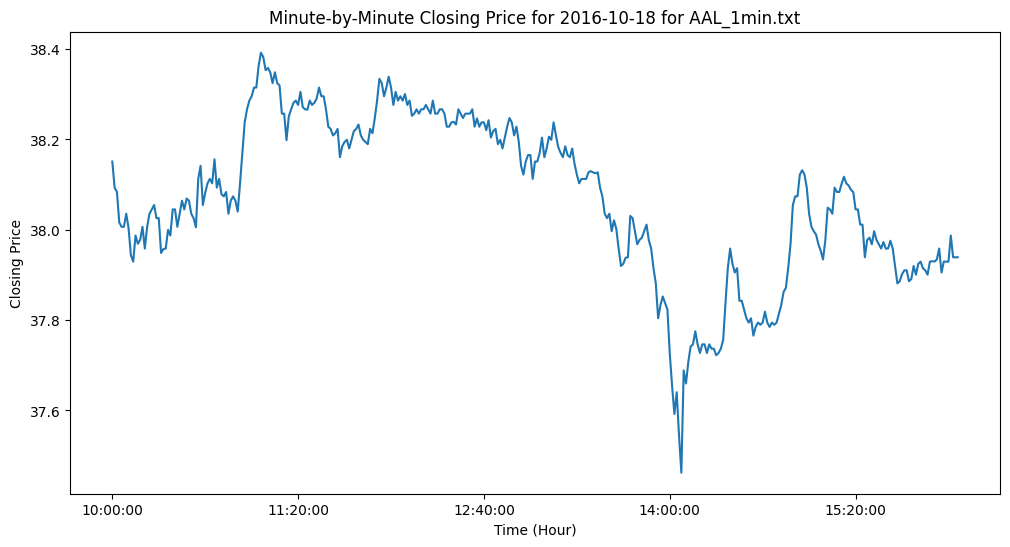

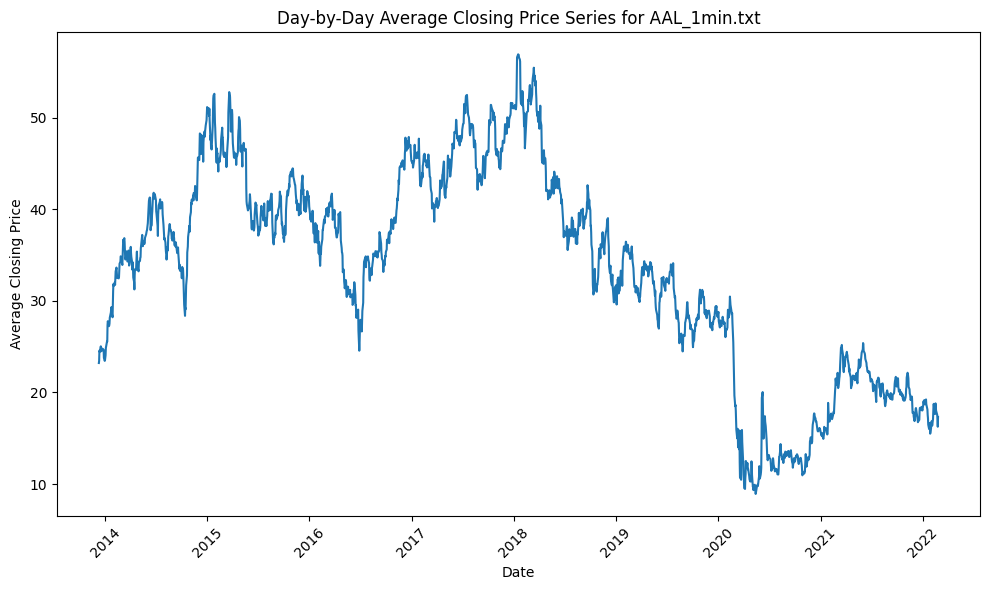

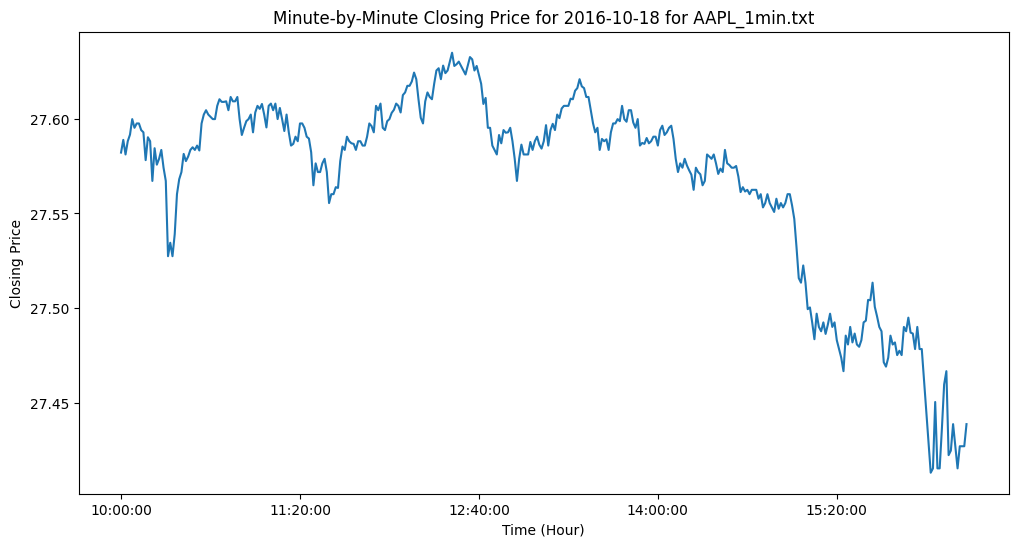

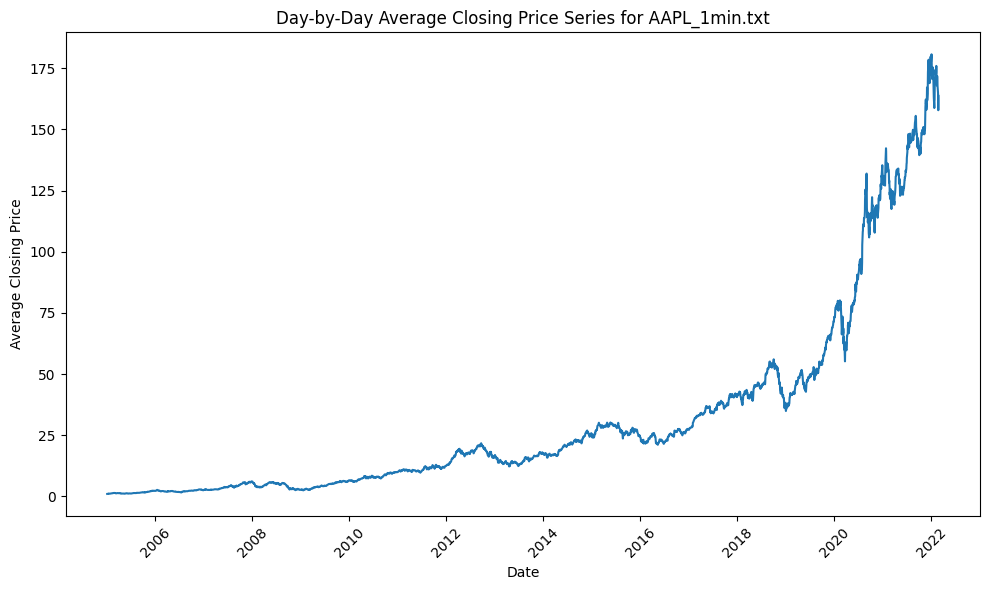

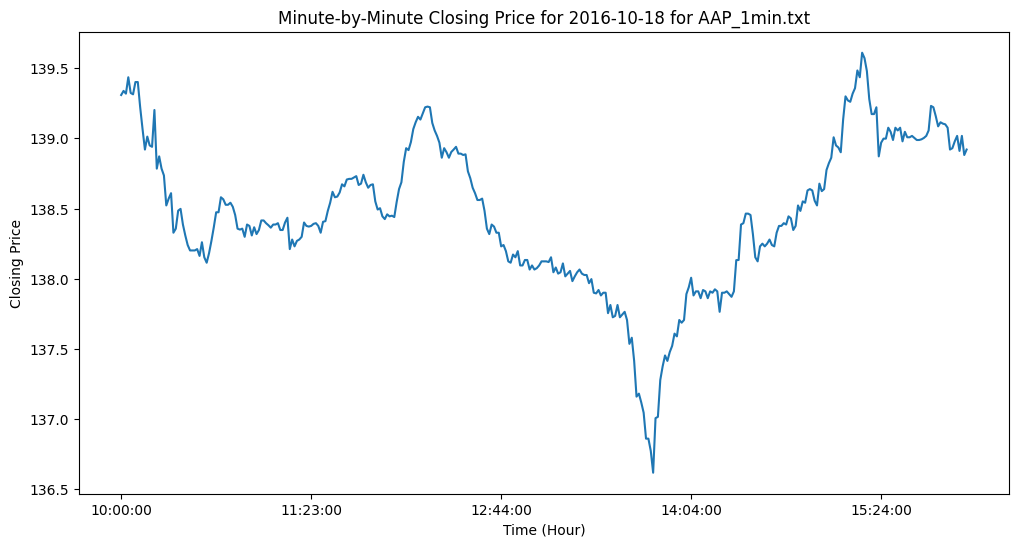

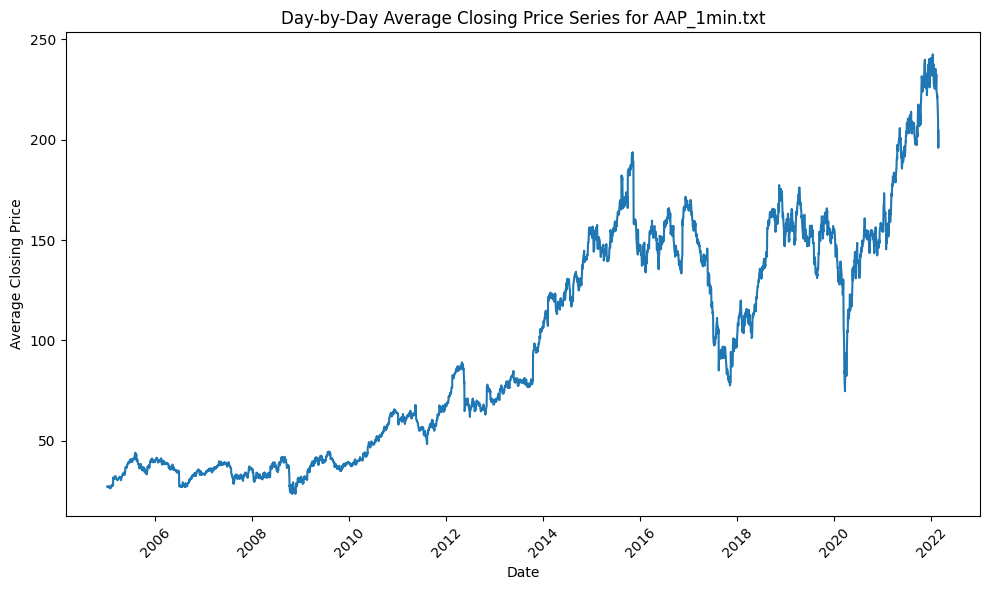

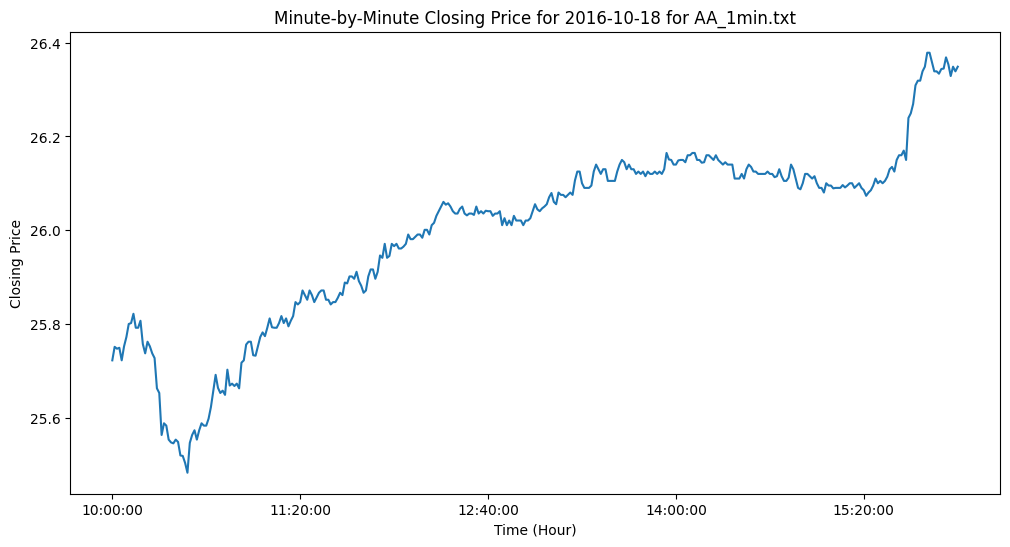

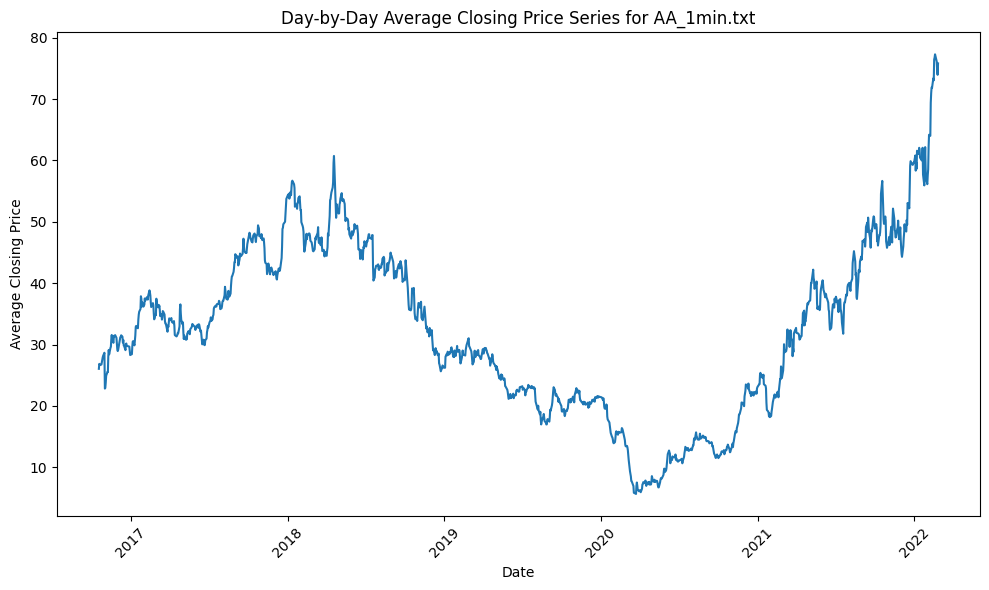

In [6]:
# Specify the directory containing the text files
df_folder = "./sp500_tickers_A-D_1min_1pppix"

# Get a list of text files in the directory and limit to the first 4 files
txt_files = [f for f in os.listdir(df_folder) if f.endswith(".txt")]
txt_files = txt_files[:4]  # Limit to the first 4 files

# Print the list of selected text files
print(txt_files)

# Initialize an empty dictionary to store DataFrames
df = {}

# Loop through the selected text files and process each DataFrame
for txt_file in txt_files:
    # Create the full path to the text file
    txt_file_path = os.path.join(df_folder, txt_file)

    try:
        # Extract the symbol from the text file name
        symbol = os.path.splitext(txt_file)[0]

        # Read the text file into a DataFrame with column names
        df[txt_file] = pd.read_csv(txt_file_path, names=["DateTime", "Open", "High", "Low", "Close", "Volume"])

        # Convert the "DateTime" column to datetime format
        df[txt_file]['DateTime'] = pd.to_datetime(df[txt_file]['DateTime'])

        # Extract the date and time components from the "DateTime" column
        df[txt_file]['Date'] = df[txt_file]['DateTime'].dt.date
        df[txt_file]['Time'] = df[txt_file]['DateTime'].dt.time

        # Convert the "Close" column to numeric, handling errors by coercing to NaN
        df[txt_file]['Close'] = pd.to_numeric(df[txt_file]['Close'], errors='coerce')

        # Specify a specific date for plotting
        selected_date = pd.to_datetime('2016-10-18').date()

        # Call functions to plot minute-by-minute and day-by-day data
        plot_minute_by_minute(df[txt_file], selected_date, txt_file)
        plot_day_by_day(df[txt_file], txt_file)

    except Exception as e:
        # Handle exceptions and print an error message
        print(f"Error processing {txt_file_path}: {e}")


### Q1 CandleStick Plots

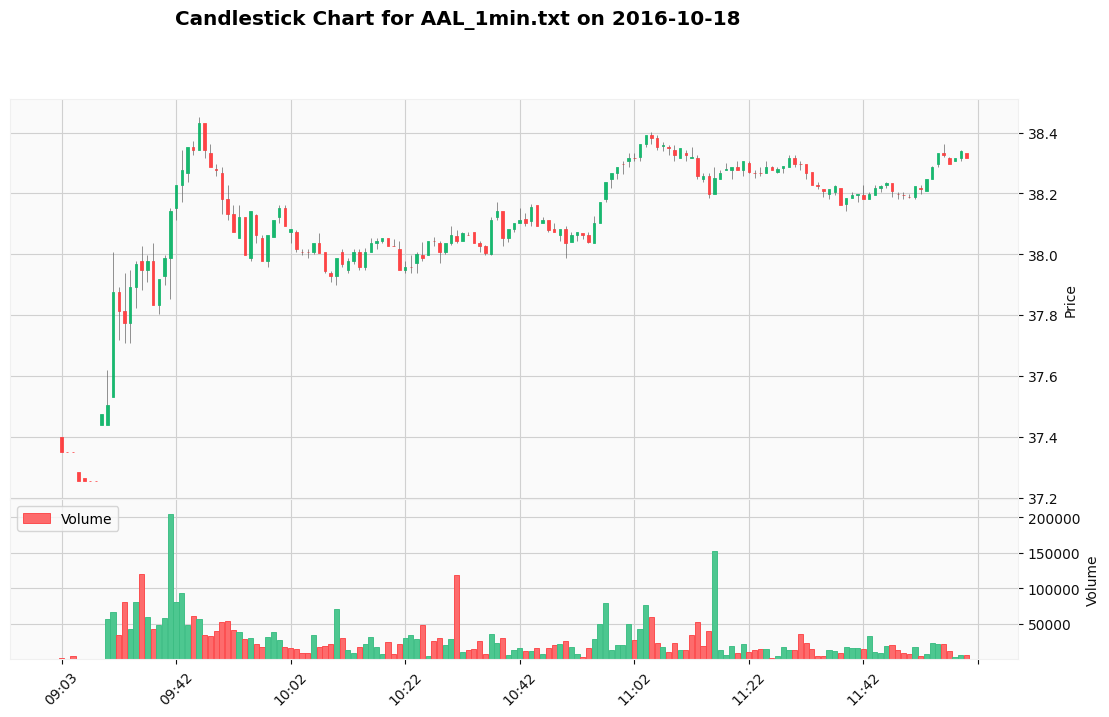

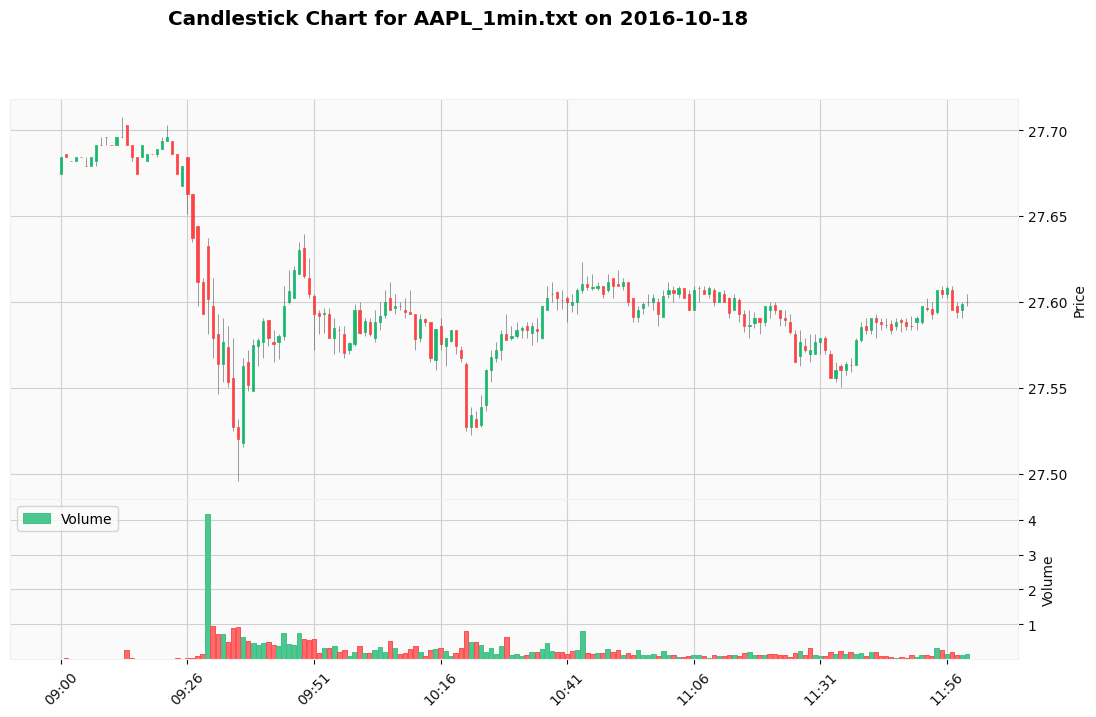

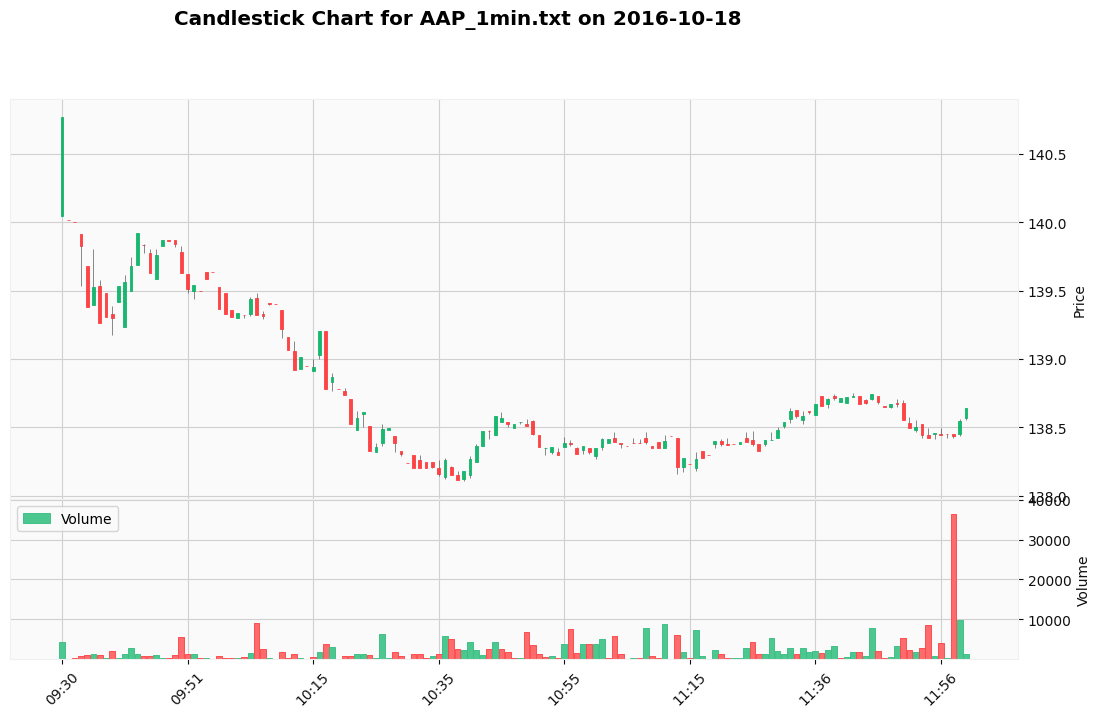

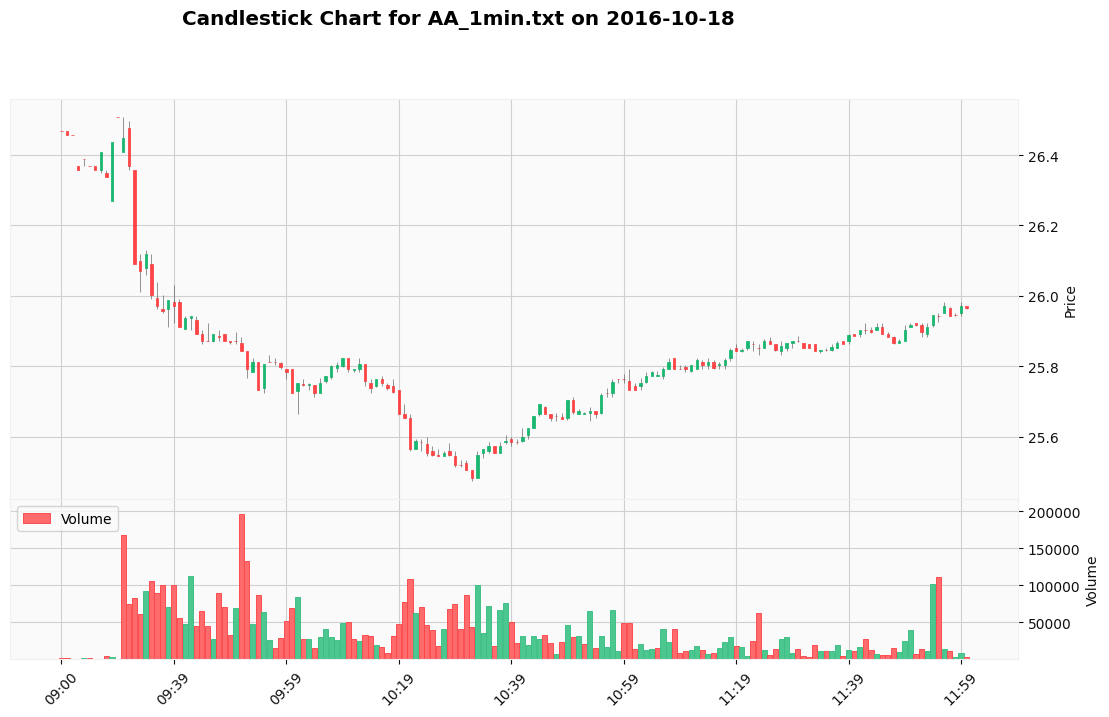

In [9]:
import mplfinance as mpf

for txt_file in txt_files:
    try:
        # Create a copy of the DataFrame filtered by time
        plot_df = filter_by_time(df[txt_file].copy(), '09:00:00', '12:00:00')
        
        # Set the "DateTime" column as the index for plotting
        plot_df.set_index('DateTime', inplace=True)

        # Specify the year, month, and day you want to plot
        selected_year = 2016
        selected_month = 10
        selected_day = 18

        # Filter the DataFrame for the selected date
        yearly_df = plot_df[
            (plot_df.index.year == selected_year) &
            (plot_df.index.month == selected_month) &
            (plot_df.index.day == selected_day)
        ]

        # Create a larger candlestick chart for the selected date
        fig, axes = mpf.plot(yearly_df, type='candle', style='yahoo', title=f"Candlestick Chart for {txt_file} on {selected_year}-{selected_month}-{selected_day}",
                             ylabel='Price', volume=True, ylabel_lower='Volume', returnfig=True, figsize=(14, 8))
        
        # Add labels and move legends
        axes[0].set_ylabel('Price')
        axes[2].set_ylabel('Volume')
        # axes[0].legend(['Open', 'High', 'Low', 'Close'])
        axes[2].legend(['Volume'], loc='upper left')

        # Show the plot
        mpf.show()
        
    except Exception as e:
        # Handle exceptions and print an error message
        print(f"Error processing {txt_file}: {e}")


**Observations:**

1. **Missing Data**: There are no missing data points, which is expected as financial markets are closed on Saturday and Sundays. Hence, data for those days is not available.

2. **Trends and Seasonality**: The plots reveal a general noticeable upward or downward trend in the average closing price over time. However, within each trading day, the closing price exhibits random fluctuations.

3. **Data Volume**: The dataset provides a substantial volume of data, allowing for various trading strategies, including intraday, interday, and even interweek analysis.

## Q2

In [12]:
# Create a copy of the 'AA_1min.txt' DataFrame from the original dataset
df_inuse = df['AA_1min.txt'].copy()

# Extract the year from the 'DateTime' column and create a new 'Year' column
df_inuse['Year'] = df_inuse['DateTime'].dt.year

# Create copies of DataFrames for minmax normalization
norm_df = {}
for key, value in df.items():
    norm_df[key] = value.copy()

# Create copies of DataFrames for Z-score normalization
norm_df_z = {}
for key, value in df.items():
    norm_df_z[key] = value.copy()


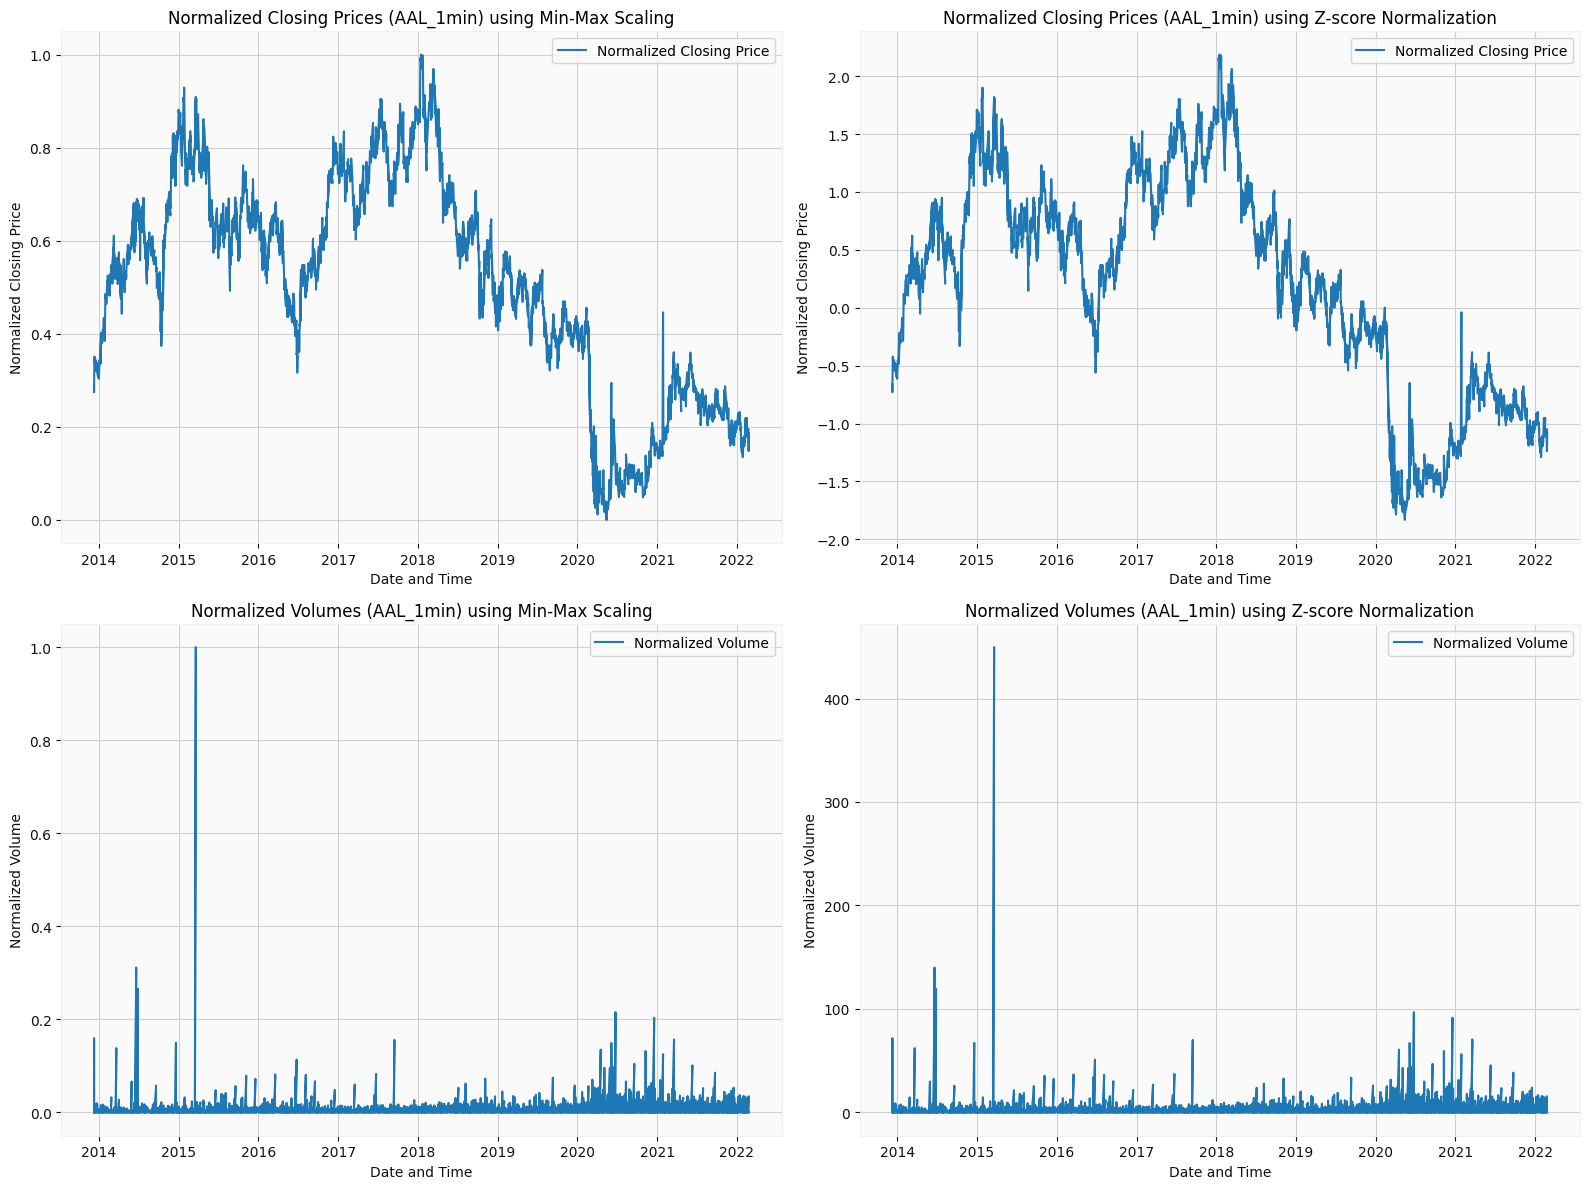

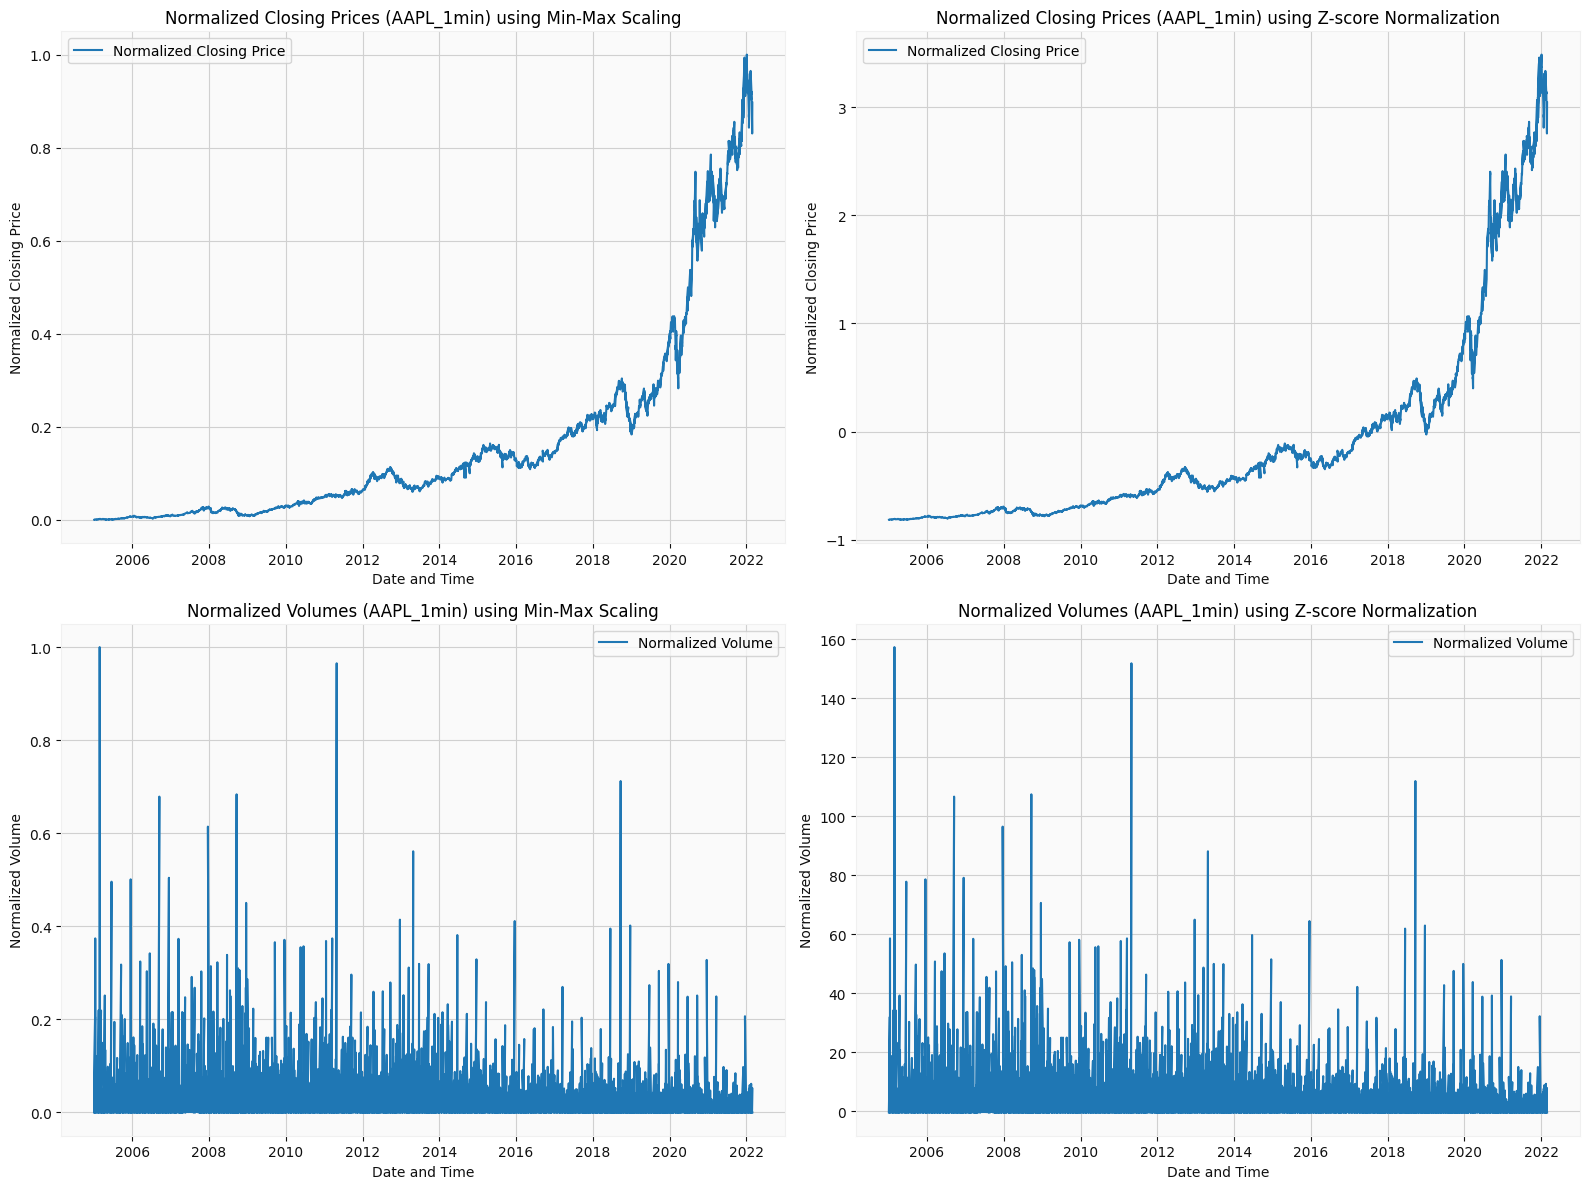

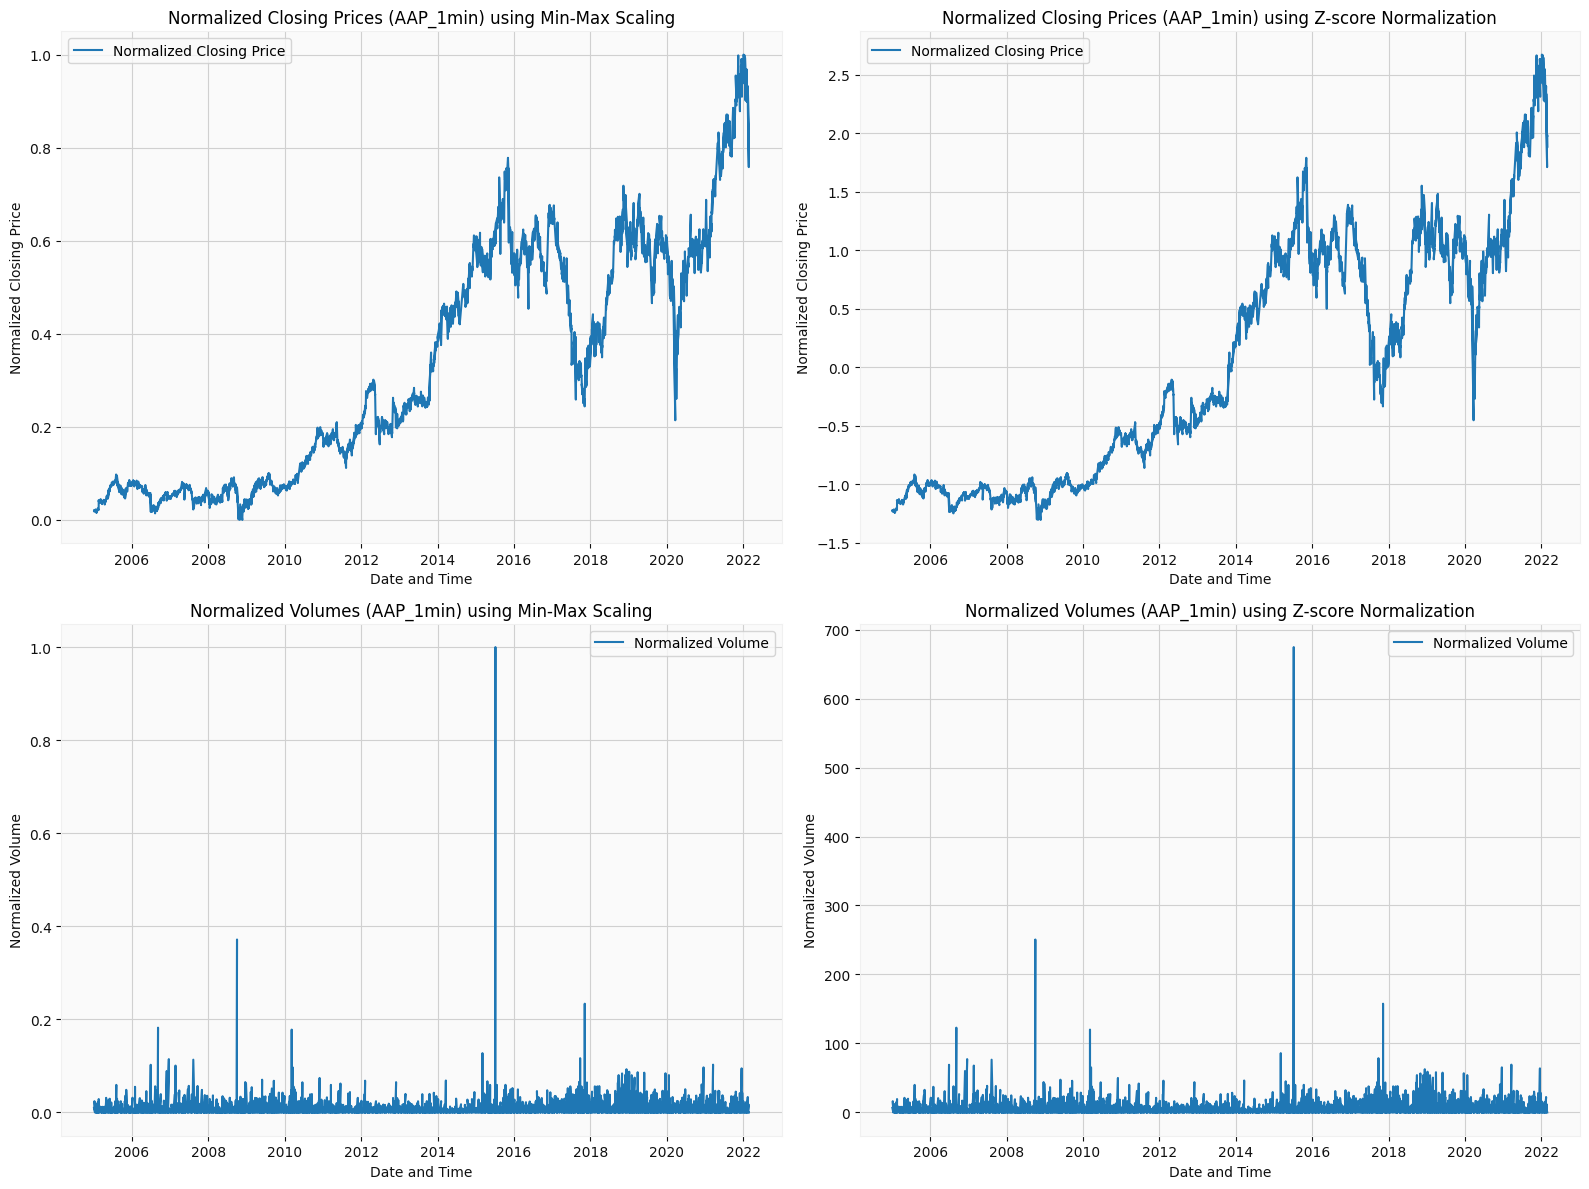

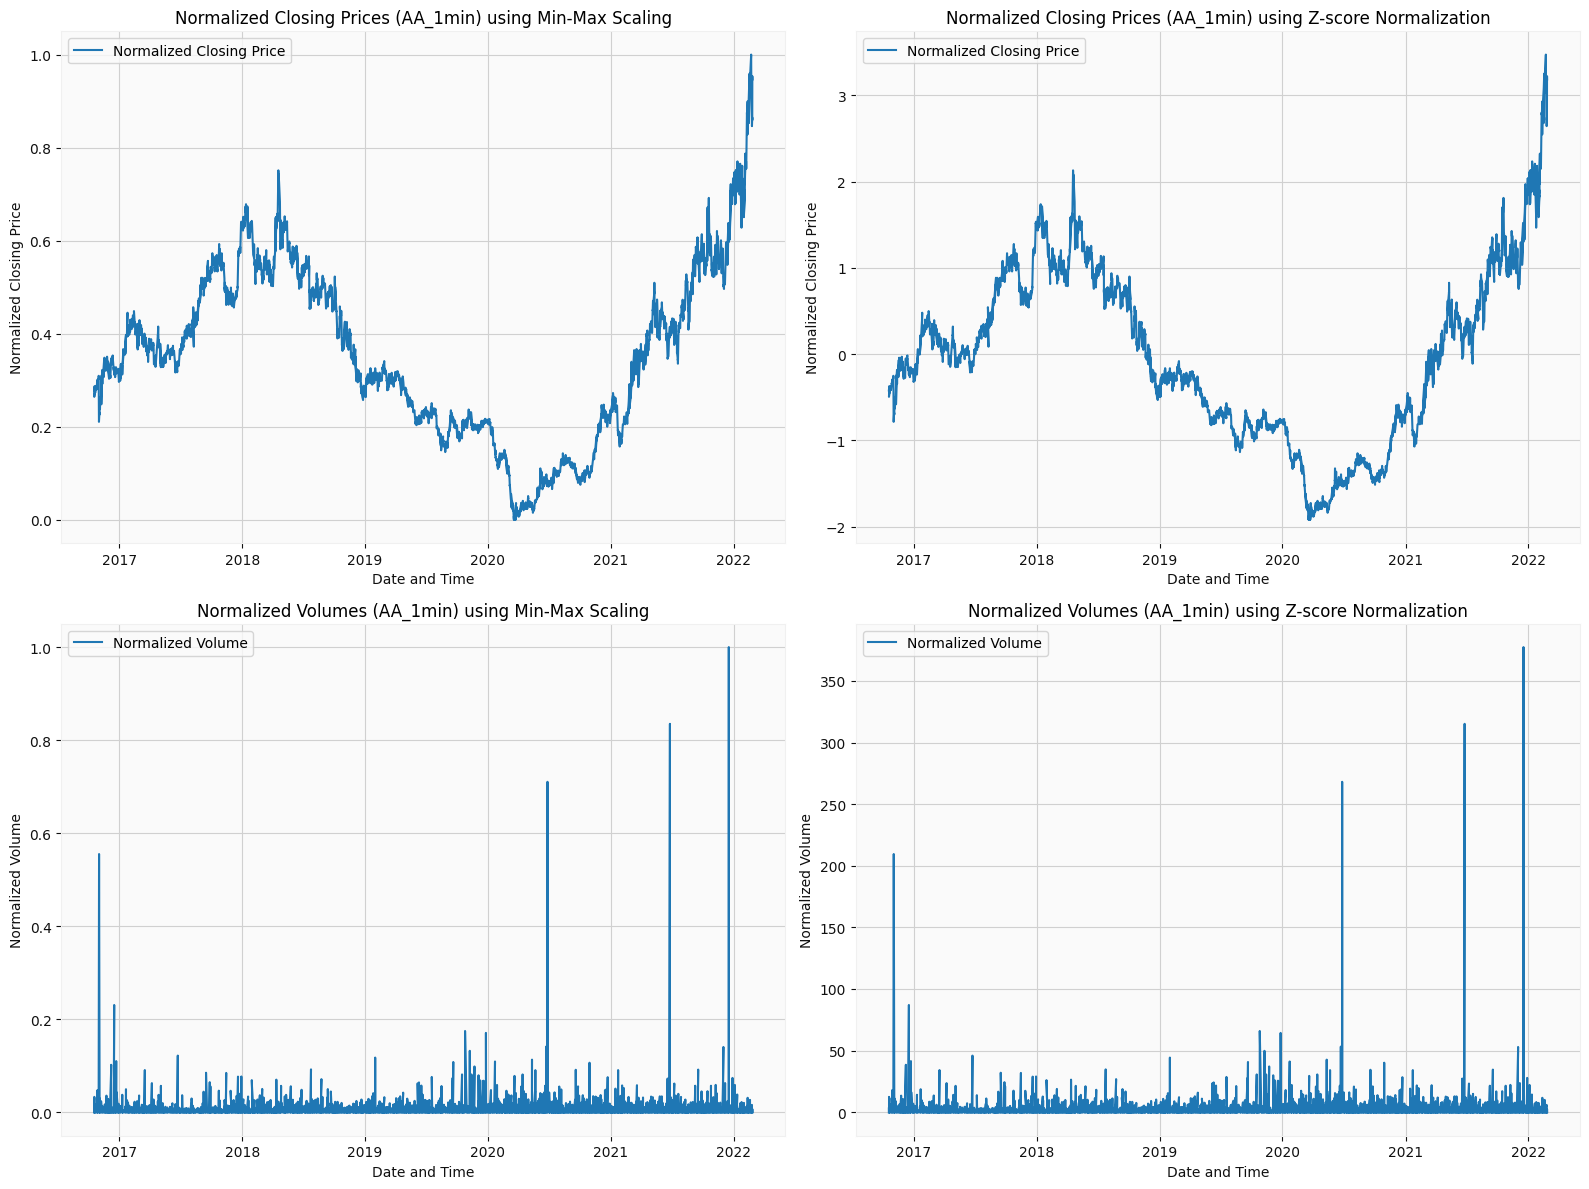

In [13]:
from sklearn.preprocessing import MinMaxScaler

# Loop through selected files and process df
for txt_file in txt_files:
    try:
        # Normalize closing prices and volumes using Min-Max Scaling
        scaler = MinMaxScaler()
        norm_df[txt_file][['Open', 'High', 'Low', 'Volume', 'Close']] = scaler.fit_transform(df[txt_file][['Open', 'High', 'Low', 'Volume', 'Close']])
        
        # Apply Z-score normalization to a separate DataFrame
        norm_df_z[txt_file] = manual_zscore_normalization(norm_df_z[txt_file], ['Open', 'High', 'Low', 'Volume', 'Close'])
        
        # Create a subplot with four graphs
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
        
        # Get the stock name from the txt_file
        stock_name = os.path.splitext(txt_file)[0]
        
        # Plot normalized closing prices using Min-Max Scaling
        axes[0, 0].plot(norm_df[txt_file]['DateTime'], norm_df[txt_file]['Close'], label='Normalized Closing Price')
        axes[0, 0].set_title(f'Normalized Closing Prices ({stock_name}) using Min-Max Scaling')
        axes[0, 0].set_xlabel('Date and Time')
        axes[0, 0].set_ylabel('Normalized Closing Price')
        axes[0, 0].legend()
        
        # Plot normalized closing prices using Z-score normalization
        axes[0, 1].plot(norm_df[txt_file]['DateTime'], norm_df_z[txt_file]['Close'], label='Normalized Closing Price')
        axes[0, 1].set_title(f'Normalized Closing Prices ({stock_name}) using Z-score Normalization')
        axes[0, 1].set_xlabel('Date and Time')
        axes[0, 1].set_ylabel('Normalized Closing Price')
        axes[0, 1].legend()
        
        # Plot normalized volumes using Min-Max Scaling
        axes[1, 0].plot(norm_df[txt_file]['DateTime'], norm_df[txt_file]['Volume'], label='Normalized Volume')
        axes[1, 0].set_title(f'Normalized Volumes ({stock_name}) using Min-Max Scaling')
        axes[1, 0].set_xlabel('Date and Time')
        axes[1, 0].set_ylabel('Normalized Volume')
        axes[1, 0].legend()
        
        # Plot normalized volumes using Z-score normalization
        axes[1, 1].plot(norm_df[txt_file]['DateTime'], norm_df_z[txt_file]['Volume'], label='Normalized Volume')
        axes[1, 1].set_title(f'Normalized Volumes ({stock_name}) using Z-score Normalization')
        axes[1, 1].set_xlabel('Date and Time')
        axes[1, 1].set_ylabel('Normalized Volume')
        axes[1, 1].legend()
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error processing {txt_file_path}: {e}")


Z-score normalization (Standardization):

1. Preserves Relative Relationships: Z-score normalization maintains the relative relationships between data points while centering the data around mean zero and scaling it with the standard deviation. This is crucial for algorithms that rely on distance-based metrics, such as k-nearest neighbors (KNN) and clustering algorithms.

2. Outlier Robustness: Z-score normalization is more robust to outliers compared to Min-Max scaling. The z-score formula uses the mean and standard deviation, which are less influenced by extreme values in the dataset.

3. Interpretability: Standardized data is more interpretable because the values are in terms of standard deviations from the mean. Positive z-scores indicate values above the mean, while negative z-scores indicate values below the mean.

Min-Max scaling:

1. Rescaling to a Fixed Range: Min-Max scaling transforms the data to a specific range, usually between 0 and 1. This can be helpful for algorithms that are sensitive to the scale of features, such as gradient descent optimization algorithms.

2. Comparison Between Features: Min-Max scaling ensures that all features have the same scale, making it easier to compare their importance and contributions to the model.

3. Neural Networks and Deep Learning: Min-Max scaling is commonly used in deep learning and neural networks, where activation functions like the sigmoid and hyperbolic tangent function are sensitive to the range of input values.

In summary, Z-score normalization (standardization) is beneficial when maintaining relative relationships between data points is critical, and the algorithm requires features with zero mean and unit variance. It is also more suitable when the dataset contains outliers.

On the other hand, Min-Max scaling is useful when a fixed range is desired for the features, making them comparable and more suitable for certain algorithms like gradient-based optimization and neural networks. Since, we are working with a time series data with very few outliers and very gradual data (in terms of the change of values from one day to the next)

We will hence be using Min-Max scaling for our model, and rescale it when evaluating the model for more realistic loss values.
reference - "https://www.quora.com/What-are-the-benefits-of-normalizing-data-with-z-scores-or-min-max-scaling-in-machine-learning"

## Q3
Scenario decisions:

1) high-frequency trading or intra-day swing, or inter-day trade, or long-term (multi-day or multi-week or multi-month)? <br>
Ans - We will be performing inter day trading, since this way we are making sure there is a trend visible to the model, in high frequency and intra-day swing we would have to set a very large sequence lenght for the model to see any particular trend, otherwise it will predict a constant value.

2) Assume a buy-ask spread (inversely related to volume and directly related to price) and trade commission based on a quick market research. Your trade will lose the buy-ask spread and commissions every time you trade. <br>
We will assume a bid-ask spread of 1 percent and a commission of 0.5 percent of the trade made

3) Decide if you will trade only one stock, or have a model to trade a basket from a particular industry, or any stock. <br>
Ans - We will be trading a single stock since we need the model to understand the trend of this stock from a specific length of past inputs, by predicting mulitple stocks that are unrelated to each other, the model could be inefficient.

In [14]:
df_inuse

DateTime     Open     High      Low    Close  Volume  \
0      2016-10-18 04:04:00  26.5376  26.5376  26.5376  26.5376     100   
1      2016-10-18 04:10:00  26.5873  26.5972  26.5873  26.5972     400   
2      2016-10-18 04:11:00  26.5972  26.5972  26.5873  26.5873     700   
3      2016-10-18 04:14:00  26.5773  26.5773  26.5376  26.5376     700   
4      2016-10-18 06:30:00  26.5376  26.5376  26.5376  26.5376     500   
...                    ...      ...      ...      ...      ...     ...   
575054 2022-02-25 19:10:00  77.7800  77.7800  77.7800  77.7800     775   
575055 2022-02-25 19:23:00  77.7700  77.7700  77.7700  77.7700     100   
575056 2022-02-25 19:45:00  77.7700  77.7700  77.7700  77.7700     369   
575057 2022-02-25 19:47:00  77.7900  77.7900  77.7900  77.7900    1175   
575058 2022-02-25 19:59:00  77.9000  77.9000  77.7900  77.7900    1000   

              Date      Time  Year  
0       2016-10-18  04:04:00  2016  
1       2016-10-18  04:10:00  2016  
2       2016-10-18  04:11:00  2016  
3       2016-10-18  04:14:00  2016  
4       2016-10-18  06:30:00  2016  
...            ...       ...   ...  
575054  2022-02-25  19:10:00  2022  
575055  2022-02-25  19:23:00  2022  
575056  2022-02-25  19:45:00  2022  
575057  2022-02-25  19:47:00  2022  
575058  2022-02-25  19:59:00  2022  

[575059 rows x 9 columns]

In [15]:
norm_df_inuse = norm_df['AA_1min.txt']
norm_df_inuse

DateTime      Open      High       Low     Close    Volume  \
0      2016-10-18 04:04:00  0.278291  0.278057  0.278713  0.278338  0.000005   
1      2016-10-18 04:10:00  0.278939  0.278834  0.279361  0.279115  0.000022   
2      2016-10-18 04:11:00  0.279068  0.278834  0.279361  0.278986  0.000038   
3      2016-10-18 04:14:00  0.278809  0.278575  0.278713  0.278338  0.000038   
4      2016-10-18 06:30:00  0.278291  0.278057  0.278713  0.278338  0.000027   
...                    ...       ...       ...       ...       ...       ...   
575054 2022-02-25 19:10:00  0.946412  0.946395  0.946443  0.946416  0.000043   
575055 2022-02-25 19:23:00  0.946282  0.946264  0.946313  0.946285  0.000005   
575056 2022-02-25 19:45:00  0.946282  0.946264  0.946313  0.946285  0.000020   
575057 2022-02-25 19:47:00  0.946542  0.946525  0.946574  0.946546  0.000065   
575058 2022-02-25 19:59:00  0.947977  0.947960  0.946574  0.946546  0.000055   

              Date      Time  
0       2016-10-18  04:04:00  
1       2016-10-18  04:10:00  
2       2016-10-18  04:11:00  
3       2016-10-18  04:14:00  
4       2016-10-18  06:30:00  
...            ...       ...  
575054  2022-02-25  19:10:00  
575055  2022-02-25  19:23:00  
575056  2022-02-25  19:45:00  
575057  2022-02-25  19:47:00  
575058  2022-02-25  19:59:00  

[575059 rows x 8 columns]

In [16]:
# Calculate differences and skip the first element
df_inuse['CloseDiff'] = df_inuse['Close'].diff()
df_inuse = df_inuse.dropna()  # Remove the first row with NaN
norm_df_inuse['CloseDiff'] = norm_df_inuse['Close'].diff()
norm_df_inuse = norm_df_inuse.dropna()  # Remove the first row with NaN

In [17]:
norm_df_inuse

DateTime      Open      High       Low     Close    Volume  \
1      2016-10-18 04:10:00  0.278939  0.278834  0.279361  0.279115  0.000022   
2      2016-10-18 04:11:00  0.279068  0.278834  0.279361  0.278986  0.000038   
3      2016-10-18 04:14:00  0.278809  0.278575  0.278713  0.278338  0.000038   
4      2016-10-18 06:30:00  0.278291  0.278057  0.278713  0.278338  0.000027   
5      2016-10-18 06:43:00  0.278549  0.278315  0.278842  0.278467  0.000055   
...                    ...       ...       ...       ...       ...       ...   
575054 2022-02-25 19:10:00  0.946412  0.946395  0.946443  0.946416  0.000043   
575055 2022-02-25 19:23:00  0.946282  0.946264  0.946313  0.946285  0.000005   
575056 2022-02-25 19:45:00  0.946282  0.946264  0.946313  0.946285  0.000020   
575057 2022-02-25 19:47:00  0.946542  0.946525  0.946574  0.946546  0.000065   
575058 2022-02-25 19:59:00  0.947977  0.947960  0.946574  0.946546  0.000055   

              Date      Time  CloseDiff  
1       2016-10-18  04:10:00   0.000777  
2       2016-10-18  04:11:00  -0.000129  
3       2016-10-18  04:14:00  -0.000648  
4       2016-10-18  06:30:00   0.000000  
5       2016-10-18  06:43:00   0.000129  
...            ...       ...        ...  
575054  2022-02-25  19:10:00   0.000000  
575055  2022-02-25  19:23:00  -0.000130  
575056  2022-02-25  19:45:00   0.000000  
575057  2022-02-25  19:47:00   0.000261  
575058  2022-02-25  19:59:00   0.000000  

[575058 rows x 9 columns]

In [18]:
data_list = norm_df_inuse.copy()  # Create a copy of the normalized DataFrame

# Filter data to include only the time range from 09:30 AM to 04:00 PM
data_list = filter_by_time(data_list, '09:30:00', '16:00:00')

# Group the filtered data by date to calculate daily statistics
data_list = group_by_date(data_list)

# Display the resulting DataFrame with daily statistics
data_list


Date      Open      High       Low    Volume     Close  CloseDiff  \
0     2016-10-18  0.276607  0.277667  0.264855  0.670472  0.275875  -0.002073   
1     2016-10-19  0.274792  0.287519  0.274439  0.517210  0.282744   0.008941   
2     2016-10-20  0.281789  0.284214  0.277612  0.411859  0.278208  -0.003888   
3     2016-10-21  0.276607  0.282723  0.273921  0.329320  0.280671   0.003111   
4     2016-10-24  0.282308  0.282593  0.279490  0.297673  0.280411  -0.000129   
...          ...       ...       ...       ...       ...       ...        ...   
1344  2022-02-18  0.923595  0.954090  0.917385  0.253444  0.951891   0.027379   
1345  2022-02-22  0.975357  0.976393  0.885589  0.397241  0.898307  -0.077052   
1346  2022-02-23  0.900386  0.919005  0.885591  0.295330  0.914343   0.006780   
1347  2022-02-24  0.913946  0.942091  0.843109  0.528423  0.888007  -0.023468   
1348  2022-02-25  0.885523  0.954220  0.868272  0.323183  0.947328   0.063754   

      Year  
0     2016  
1     2016  
2     2016  
3     2016  
4     2016  
...    ...  
1344  2022  
1345  2022  
1346  2022  
1347  2022  
1348  2022  

[1349 rows x 8 columns]

In [19]:
# Find the last two years in your data by subtracting 1 from the maximum year
last_two_years = data_list['Year'].max() - 1

# Split the data into training and testing sets based on the 'Year' column
train_data = data_list[data_list['Year'] < last_two_years]
test_data = data_list[data_list['Year'] >= last_two_years]

# Extract and group the final testing data for analysis
test_data_final = df_inuse[df_inuse['Year'] >= last_two_years]
test_data_final = group_by_date(test_data_final)

In [21]:
train_data

Date      Open      High       Low    Volume     Close  CloseDiff  \
0     2016-10-18  0.276607  0.277667  0.264855  0.670472  0.275875  -0.002073   
1     2016-10-19  0.274792  0.287519  0.274439  0.517210  0.282744   0.008941   
2     2016-10-20  0.281789  0.284214  0.277612  0.411859  0.278208  -0.003888   
3     2016-10-21  0.276607  0.282723  0.273921  0.329320  0.280671   0.003111   
4     2016-10-24  0.282308  0.282593  0.279490  0.297673  0.280411  -0.000129   
...          ...       ...       ...       ...       ...       ...        ...   
1054  2020-12-24  0.222536  0.222674  0.216490  0.054296  0.218294  -0.004163   
1055  2020-12-28  0.219803  0.231523  0.220131  0.196662  0.221676   0.002342   
1056  2020-12-29  0.219934  0.222674  0.207908  0.172828  0.219075   0.000651   
1057  2020-12-30  0.219413  0.233606  0.218700  0.171044  0.230913   0.010798   
1058  2020-12-31  0.231513  0.236859  0.224161  0.170759  0.232214   0.001042   

      Year  
0     2016  
1     2016  
2     2016  
3     2016  
4     2016  
...    ...  
1054  2020  
1055  2020  
1056  2020  
1057  2020  
1058  2020  

[1059 rows x 8 columns]

In [20]:
test_data

Date      Open      High       Low    Volume     Close  CloseDiff  \
1059  2021-01-04  0.238799  0.250134  0.233588  0.219552  0.234815  -0.003512   
1060  2021-01-05  0.235416  0.245839  0.234823  0.200052  0.240279   0.008456   
1061  2021-01-06  0.251028  0.265881  0.250165  0.280558  0.260183   0.009366   
1062  2021-01-07  0.265729  0.272909  0.257447  0.216163  0.260573  -0.004424   
1063  2021-01-08  0.261436  0.263409  0.251727  0.143708  0.257451  -0.005335   
...          ...       ...       ...       ...       ...       ...        ...   
1344  2022-02-18  0.923595  0.954090  0.917385  0.253444  0.951891   0.027379   
1345  2022-02-22  0.975357  0.976393  0.885589  0.397241  0.898307  -0.077052   
1346  2022-02-23  0.900386  0.919005  0.885591  0.295330  0.914343   0.006780   
1347  2022-02-24  0.913946  0.942091  0.843109  0.528423  0.888007  -0.023468   
1348  2022-02-25  0.885523  0.954220  0.868272  0.323183  0.947328   0.063754   

      Year  
1059  2021  
1060  2021  
1061  2021  
1062  2021  
1063  2021  
...    ...  
1344  2022  
1345  2022  
1346  2022  
1347  2022  
1348  2022  

[290 rows x 8 columns]

## Q4

In [22]:
import torch
import torch.nn as nn

class InterdayLSTM(nn.Module):
    def __init__(self, input_dim, hidden_units, num_layers, output_dim):
        super(InterdayLSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        self.output_dim = output_dim
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_units, num_layers, batch_first=True)
        
        # Define the output layer
        self.output_layer = nn.Linear(hidden_units, output_dim)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_units).to(x.device)
        
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_units).to(x.device)
        
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Index hidden state of last time step
        out = self.output_layer(out[:, -1, :])
        return out


## Q5

In [23]:
import torch
import torch.utils.data as data

# Define the StockDataset class for creating datasets
class StockDataset(data.Dataset):
    def __init__(self, stock_data, sequence_length, window_length):
        self.stock_data = stock_data
        self.sequence_length = sequence_length  # Number of time steps in each input sequence
        self.window = window_length  # Length of the prediction window

    def __len__(self):
        return len(self.stock_data) - self.sequence_length - self.window + 1

    def __getitem__(self, index):
        # Extract input sequence and target values
        input_seq = self.stock_data.iloc[index:index + self.sequence_length][['Open', 'High', 'Low', 'Volume', 'CloseDiff', 'Close']].values
        target = self.stock_data.iloc[index + self.sequence_length:index + self.sequence_length+self.window]['Close'].values
        input_seq = [list(map(float, row)) for row in input_seq]
        target = [float(val) for val in target]
        # Convert to PyTorch tensors
        input_seq = torch.tensor(input_seq, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)  # Convert to NumPy array first

        return input_seq, target

# Function to create data loaders for training and testing
def create_dataloader(stock_data, sequence_length, batch_size, window_length=1, shuffle=False):
    dataset = StockDataset(stock_data, sequence_length, window_length)
    dataloader = data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)
    return dataloader

# Define parameters
sequence_length = 100  # Number of time steps in each input sequence
batch_size = 64  # Batch size for training
window_length = 10  # Length of the prediction window

# Create data loaders for training and testing
train_dataloader = create_dataloader(train_data, sequence_length, batch_size, window_length)
test_dataloader = create_dataloader(test_data, sequence_length, batch_size, window_length)


In [25]:
# Load a batch of training data
for batch_X, batch_y in train_dataloader:
    # Print the shapes of batch_X and batch_y
    print("Batch X shape:", batch_X.shape)
    print("Batch y shape:", batch_y.shape)

    # Print the first sequence in the batch
    # print("First sequence in the batch:")
    # print(batch_X[0])
    # print("Corresponding target:")
    # print(batch_y[0])

    # Break the loop to only inspect one batch
    break


Batch X shape: torch.Size([64, 100, 6])
Batch y shape: torch.Size([64, 10])


## Q6

Epoch [1/30], Train Loss: 0.0671
Epoch [1/30], Test Loss: 0.0014
Epoch [2/30], Train Loss: 0.0561
Epoch [2/30], Test Loss: 0.0002
Epoch [3/30], Train Loss: 0.0192
Epoch [3/30], Test Loss: 0.0001
Epoch [4/30], Train Loss: 0.0049
Epoch [4/30], Test Loss: 0.0001
Epoch [5/30], Train Loss: 0.0017
Epoch [5/30], Test Loss: 0.0001
Epoch [6/30], Train Loss: 0.0048
Epoch [6/30], Test Loss: 0.0000
Epoch [7/30], Train Loss: 0.0010
Epoch [7/30], Test Loss: 0.0001
Epoch [8/30], Train Loss: 0.0016
Epoch [8/30], Test Loss: 0.0000
Epoch [9/30], Train Loss: 0.0010
Epoch [9/30], Test Loss: 0.0001
Epoch [10/30], Train Loss: 0.0013
Epoch [10/30], Test Loss: 0.0000
Epoch [11/30], Train Loss: 0.0008
Epoch [11/30], Test Loss: 0.0000
Epoch [12/30], Train Loss: 0.0008
Epoch [12/30], Test Loss: 0.0000
Epoch [13/30], Train Loss: 0.0008
Epoch [13/30], Test Loss: 0.0000
Epoch [14/30], Train Loss: 0.0008
Epoch [14/30], Test Loss: 0.0000
Epoch [15/30], Train Loss: 0.0007
Epoch [15/30], Test Loss: 0.0000
Epoch [16/30]

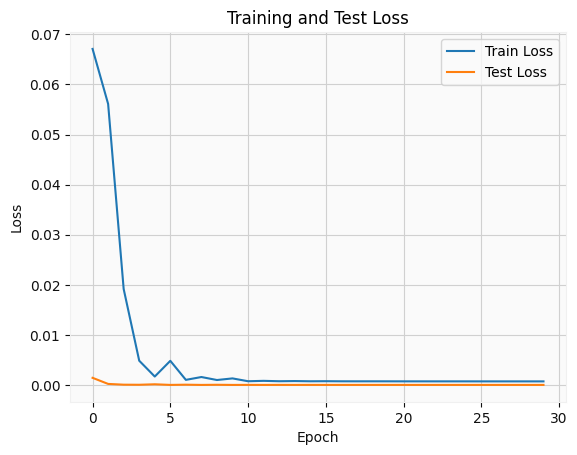

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_dim = 6  # Number of input features (Open, High, Low, Volume)
hidden_units = 100  # Number of hidden units in the LSTM layer
num_layers = 1  # Number of LSTM layers
output_dim = 10  # Number of output features (e.g., predicting Close price)
learning_rate = 0.01
num_epochs = 30
batch_size = 64

# Define a custom weight initialization function
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)

# Instantiate the model and move it to the appropriate device (CPU or GPU)
model = InterdayLSTM(input_dim, hidden_units, num_layers, output_dim).to(device)

# Apply weight initialization
model.apply(init_weights)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean squared error loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler to gradually reduce learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Lists to store training and test losses for each epoch
train_losses = []
test_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    
    for batch_X, batch_y in train_dataloader:  # train_dataloader is created using create_dataloader function
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move data to the same device as the model
        
        optimizer.zero_grad()  # Clear gradients
        
        # Forward pass
        outputs = model(batch_X)
        
        # Calculate loss
        loss = criterion(outputs, batch_y)
        
        # Backpropagation
        loss.backward()
        
        # Clip gradients to prevent exploding gradients
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item() * len(batch_X)
    
    average_loss = total_loss / len(train_dataloader.dataset)
    train_losses.append(average_loss)  # Append the loss value to the list
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_loss:.4f}")
    
    # Validation loop (on the test dataset)
    model.eval()
    total_test_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            test_loss = criterion(outputs, batch_y)
            total_test_loss += test_loss.item()
    
    average_test_loss = total_test_loss / len(test_dataloader.dataset)
    test_losses.append(average_test_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {average_test_loss:.4f}")
    
    # Adjust learning rate using the scheduler
    scheduler.step()

print("Training finished!")

# Plot the loss
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')
plt.show()

# Save the model state dictionary to a file
torch.save(model.state_dict(), 'model_weights.pth')


1. https://pytorch.org/docs/stable/optim.html for adam the optimiser and learning rate scheduler

2. During training, we use the clip_grad_norm_ function to clip the gradients of the neural network parameters to a maximum norm of 1.0. This ensures that the gradients are scaled down to a reasonable size, preventing exploding gradients - source -> https://saturncloud.io/blog/how-to-do-gradient-clipping-in-pytorch/#:~:text=During%20training%2C%20we%20use%20the,reasonable%20size%2C%20preventing%20exploding%20gradients.

3. Noticed, the test loss was almost always less than the training loss for any hyperparameter setting

In [29]:
def evaluate_model(model, test_dataloader, batch_size=64):
    """
    Evaluate the model on the test data using L1 loss.

    Args:
        model (torch.nn.Module): The trained model.
        test_dataloader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        batch_size (int): Batch size for processing data. Default is 64.

    Returns:
        float: Average test loss (L1 loss).
        list: Model predictions.
        list: True target values.
    """
    model.eval()  # Set the model to evaluation mode
    criterion = torch.nn.L1Loss()  # L1 loss criterion
    total_loss = 0.0
    num_batches = 0
    outputs = []  # List to store model predictions
    targets = []  # List to store true target values

    with torch.no_grad():
        for batch_X, batch_y in test_dataloader:
            batch_X, batch_y = batch_X.to('cuda'), batch_y.to('cuda')  # Move data to CUDA if available

            # Modify target shape to match model output if needed
            # For example, if your model outputs a 1D tensor but targets are 2D, you might need to reshape.

            output = model(batch_X)  # Forward pass
            outputs.extend(output.tolist())  # Append model predictions to the list
            targets.extend(batch_y.tolist())  # Append true target values to the list
            loss = criterion(output, batch_y)  # Calculate L1 loss
            total_loss += loss.item()
            num_batches += 1

    avg_test_loss = total_loss / (num_batches * batch_size)  # Calculate average test loss

    return avg_test_loss, outputs, targets


**Explanation of Subtle Points:**

1. *Evaluation Mode*: The function sets the model to evaluation mode using `model.eval()`. This is crucial because certain layers, such as dropout and batch normalization, behave differently during training and evaluation. In evaluation mode, these layers do not apply dropout and use population statistics for batch normalization, ensuring consistent and reliable results during inference.

2. *Gradient Calculation*: Within the `torch.no_grad()` context manager, gradient calculations are disabled during evaluation. This practice is important for two reasons: it reduces memory consumption and speeds up the inference process. During evaluation, we don't need gradients for backpropagation since we are not updating the model's parameters.

3. *Storing Predictions and Targets*: The `outputs` and `targets` lists are used to store model predictions and true target values, respectively. These lists are essential for further analysis or visualization of the model's performance. You can use them to calculate additional metrics or create visualizations to assess how well the model's predictions align with the actual target values.

4. *Modifying Target Shape*: The comment regarding modifying the target shape is included because in some cases, the model's output shape may differ from the target shape. For example, the model may output a 1D tensor, while the targets are in a 2D format. Depending on your specific model and data, you might need to reshape or preprocess the targets to match the model's output shape before calculating the loss.

5. *Average Test Loss*: The final test loss is computed by summing the losses from each batch and normalizing by the total number of samples in the test set. This calculation ensures that the reported test loss is an average value, making it easier to compare models or track the model's performance over time.

These subtle points collectively ensure that the evaluation process is conducted accurately and efficiently, allowing you to assess how well the trained model performs on unseen data.


In [30]:
# Example usage:
avg_test_loss, test_outputs, targets = evaluate_model(model, test_dataloader)
print(f"Average Test Loss: {avg_test_loss:.4f}")
print(f"Total Loss: {total_loss:.4f}")
print(f"Number of Batches: {len(test_dataloader)}")


Average Test Loss: 0.0006
Total Loss: 0.6915
Number of Batches: 2


## Visualizing Predictions and Error Analysis

Now that we have generated predictions, it's essential to visualize how well our model performs. We'll accomplish this by:

1. Plotting the Denormalized Targets and Predictions.
2. Calculating the Average Absolute Error over the Entire Target Set.
3. Plotting the Absolute Difference between Targets and Predictions to Assess Performance Beyond the Training Period.

### 1. Denormalized Targets and Predictions

To understand the accuracy of our predictions, we'll plot both the denormalized targets and denormalized predictions. This visualization will help us assess how closely our model's predictions align with the actual values.

### 2. Average Absolute Error

We've also calculated the average absolute error over the entire set of targets. This metric provides a quantitative measure of how well our model performs on average across all data points.

### 3. Absolute Difference Analysis

To gain insight into how our model performs as we move farther away from the training period, we've created plots displaying the absolute difference between the targets and predictions. These plots allow us to see if our model's accuracy deteriorates over time. clearly the average absolute difference error increases as we move farther in the prediction window as shown in the last plot of the following code cell

These visualizations and analyses are crucial for evaluating the effectiveness of our predictive model and identifying any areas for improvement.


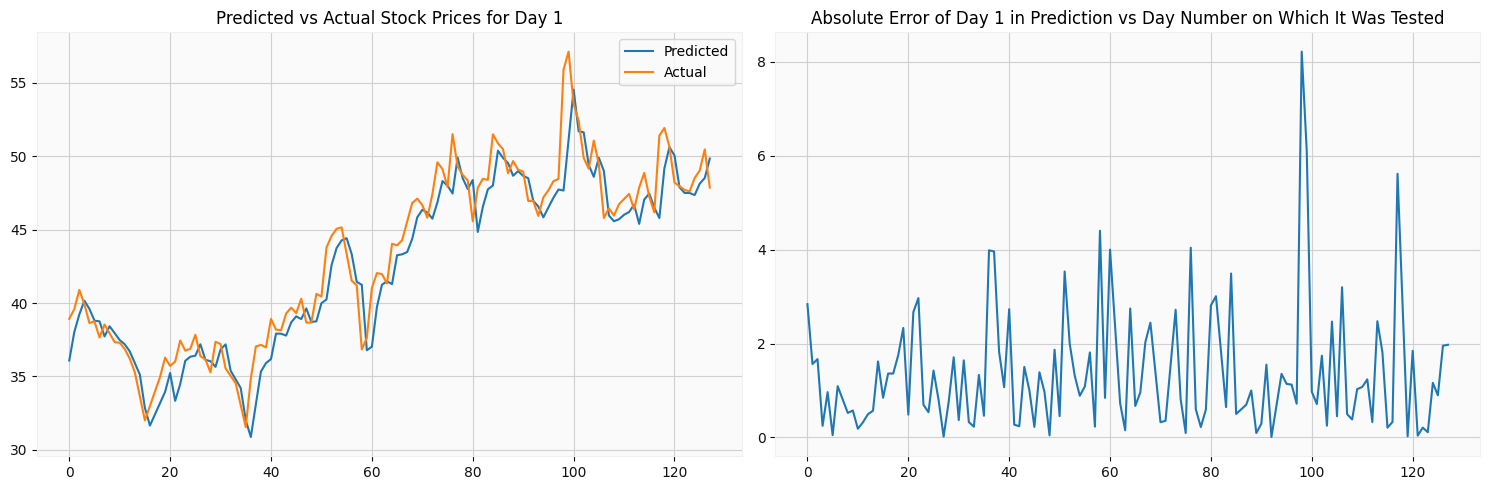

Average Absolute Error of Day 1:  1.3711713111427608


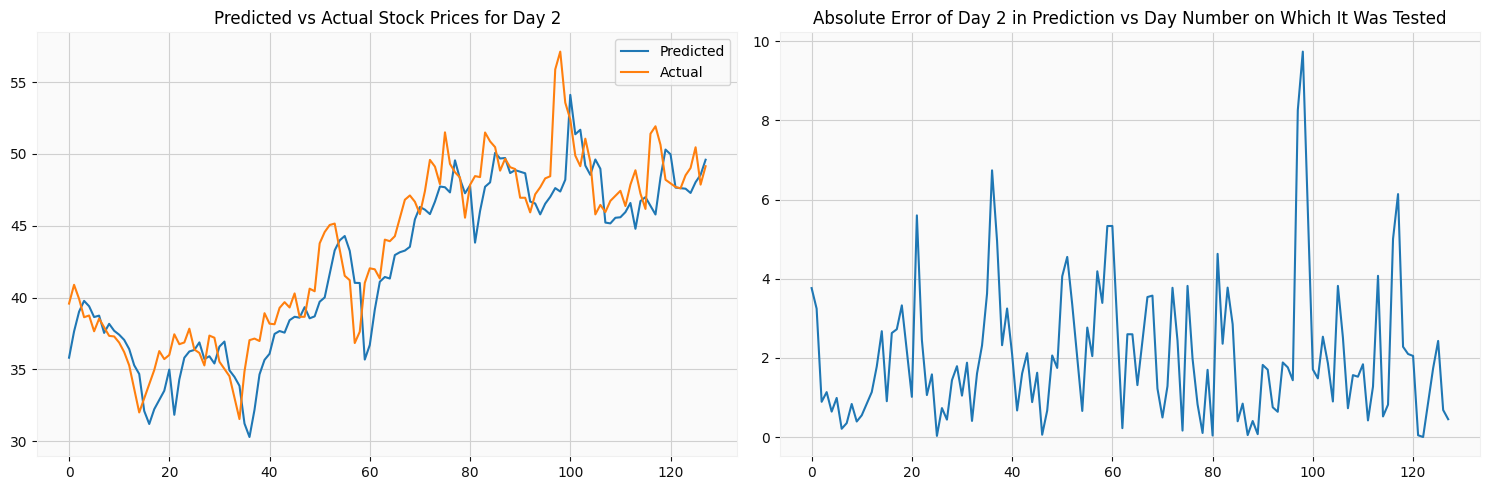

Average Absolute Error of Day 2:  2.0601756920160024


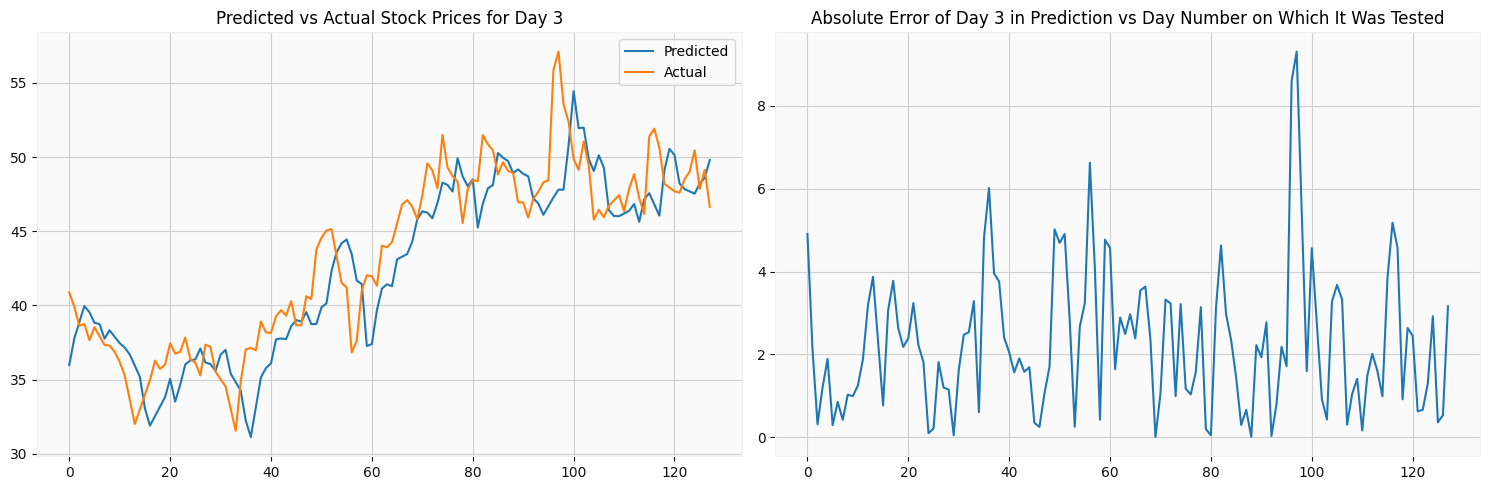

Average Absolute Error of Day 3:  2.275774526619748


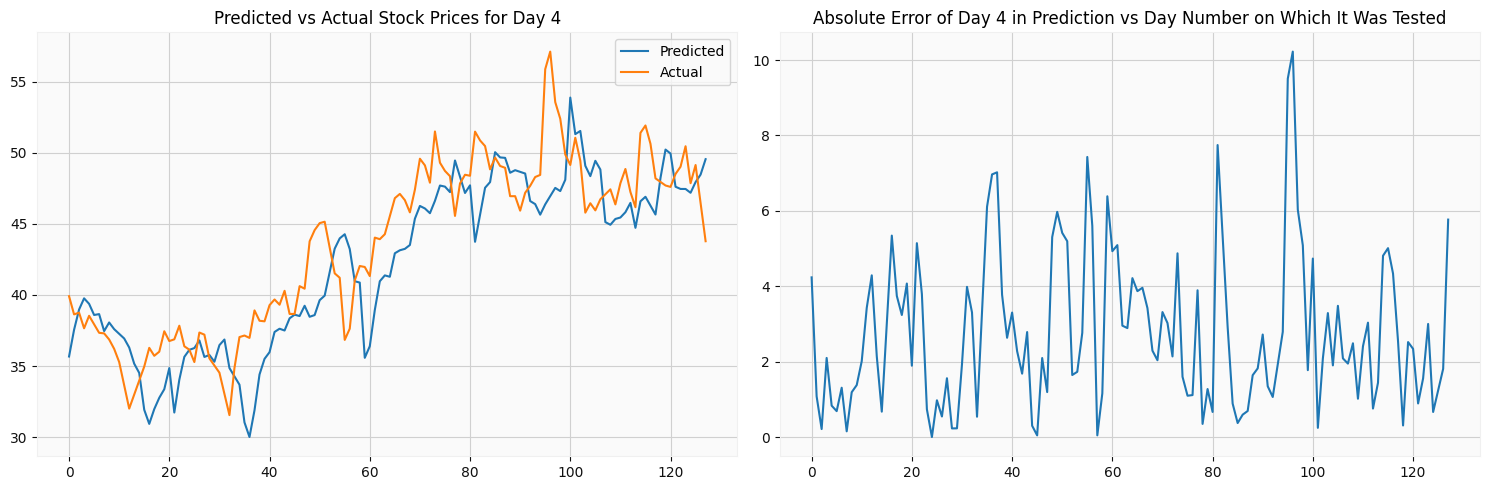

Average Absolute Error of Day 4:  2.7640345579953394


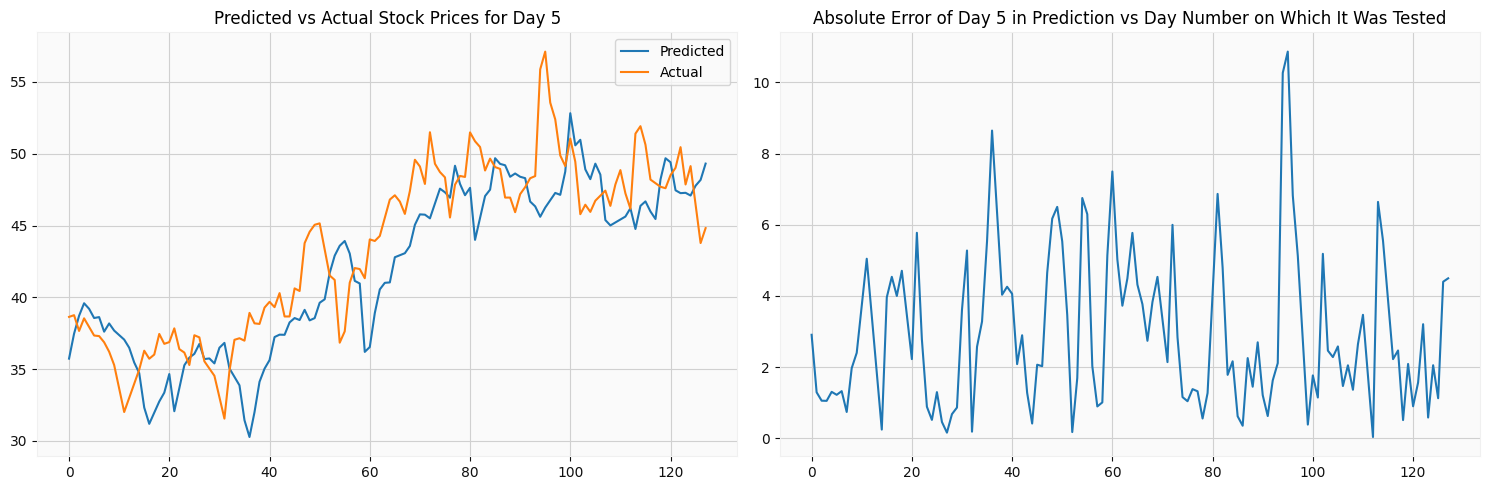

Average Absolute Error of Day 5:  2.9648048379087353


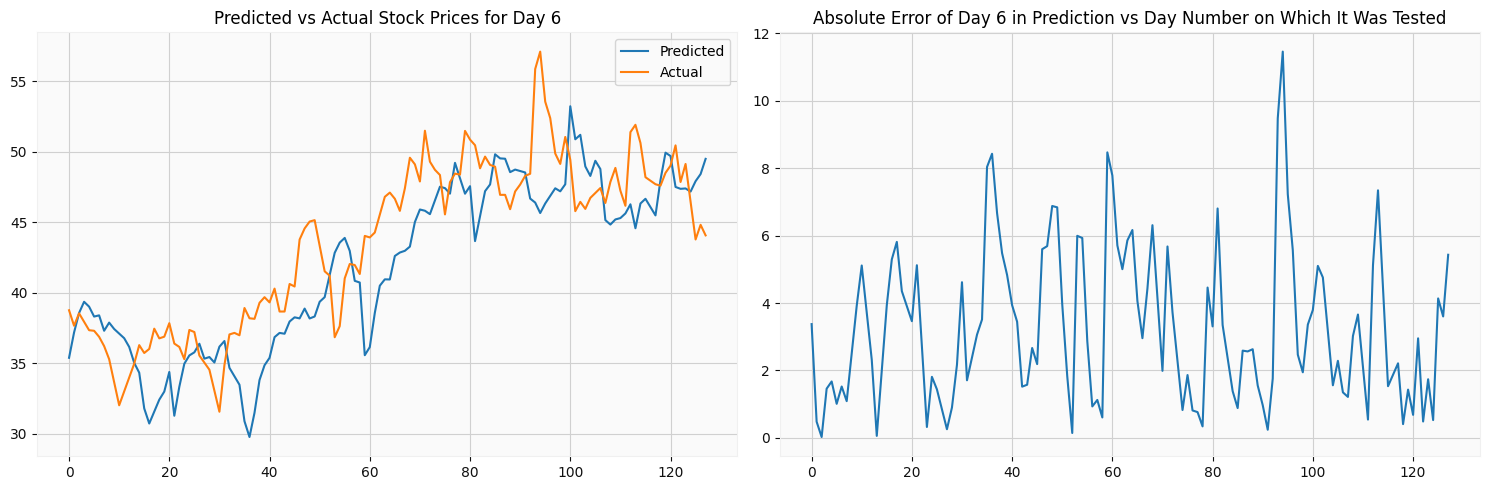

Average Absolute Error of Day 6:  3.256258389155845


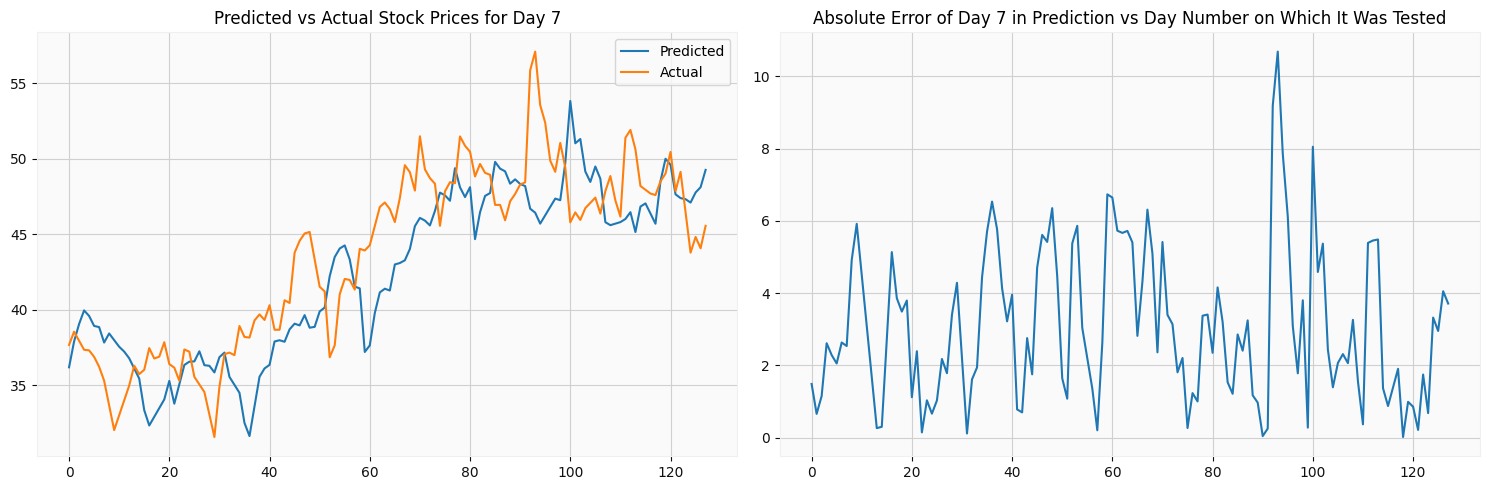

Average Absolute Error of Day 7:  3.0522564865340938


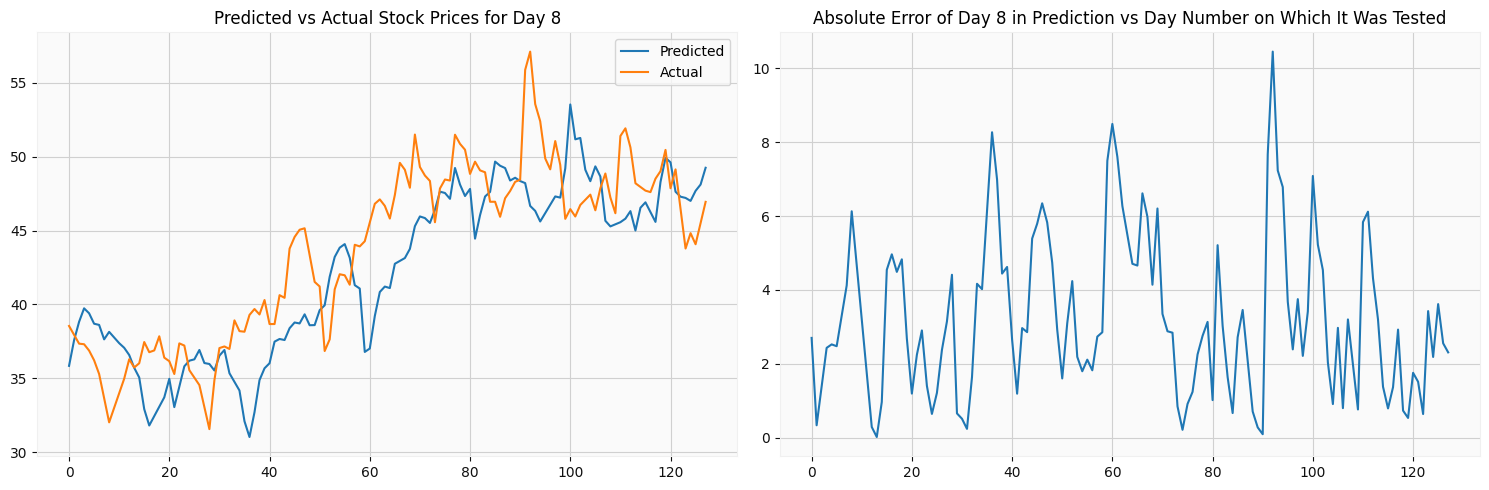

Average Absolute Error of Day 8:  3.2355118063991424


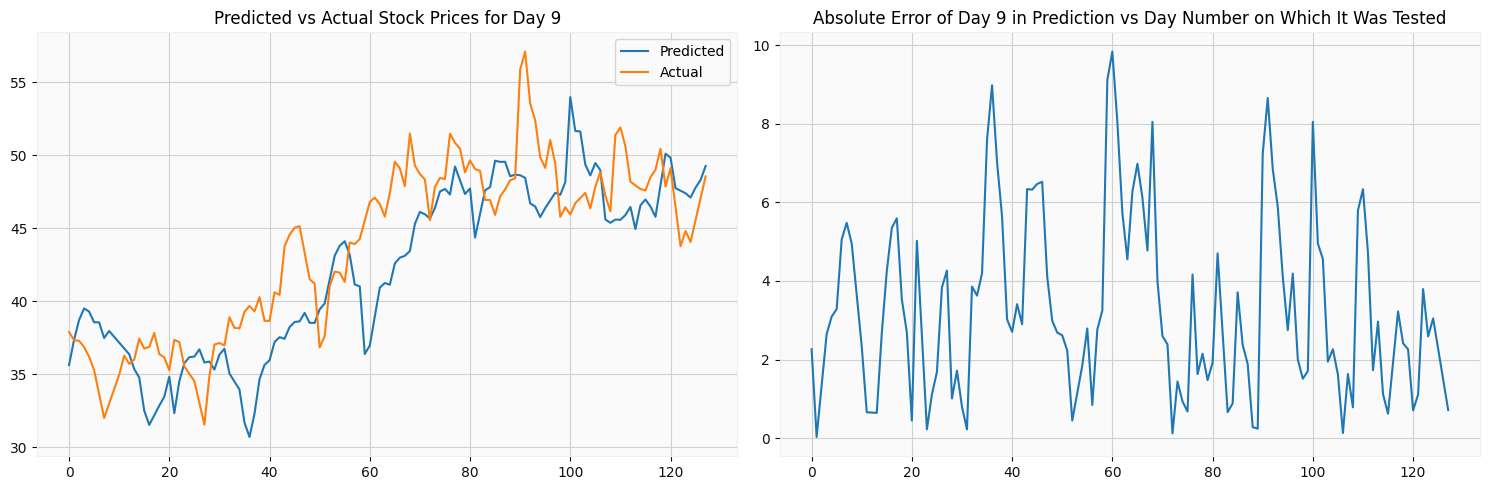

Average Absolute Error of Day 9:  3.2784985424294133


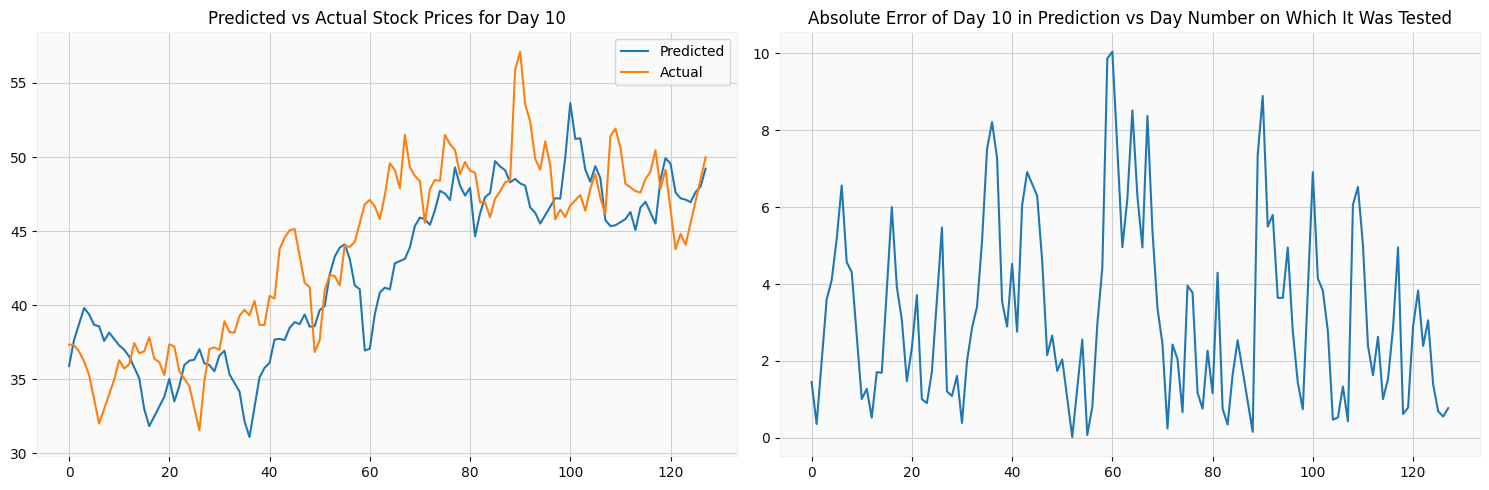

Average Absolute Error of Day 10:  3.232352045944891


Text(0, 0.5, 'Absolute difference')

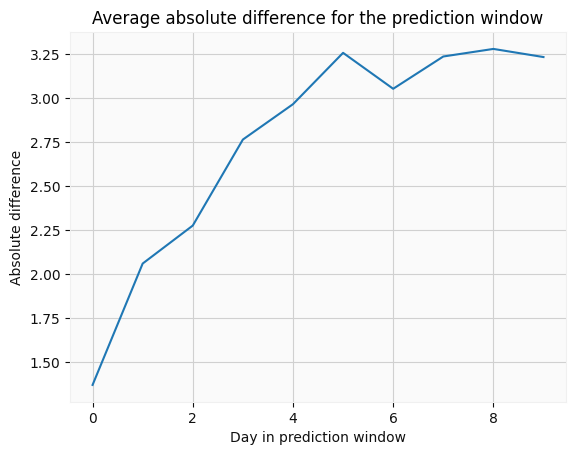

In [31]:
import numpy as np
import matplotlib.pyplot as plt
average_abs_diff = np.array([])
for i in range(output_dim): 
    # Convert `outputs` to a NumPy array
    normalized_close = np.array(np.array(test_outputs)[:, i], dtype=np.float64)
    targets_close = np.array(np.array(targets)[:, i], dtype=np.float64)
    # Denormalize the "Close" column
    min_close = np.float64(scaler.data_min_[-1])  # Minimum value of the original "Close" column
    max_close = np.float64(scaler.data_max_[-1])  # Maximum value of the original "Close" column
    denormalized_close = (normalized_close * (max_close - min_close)) + min_close
    denormalized_targets = (targets_close * (max_close - min_close)) + min_close
    
    # Create subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot predicted and actual values
    ax1.plot(denormalized_close.reshape(-1), label='Predicted')
    ax1.plot(denormalized_targets.reshape(-1), label='Actual')
    ax1.set_title(f"Predicted vs Actual Stock Prices for Day {i+1}")
    ax1.legend()

    # Plot absolute error
    abs_diff = np.abs(denormalized_close - denormalized_targets)
    ax2.plot(abs_diff)
    ax2.set_title(f"Absolute Error of Day {i+1} in Prediction vs Day Number on Which It Was Tested")

    plt.tight_layout()
    plt.show()

    average_abs_diff = np.append(average_abs_diff,np.abs(denormalized_close - denormalized_targets).mean())
    print(f"Average Absolute Error of Day {i+1}: ", average_abs_diff[-1])

plt.plot(average_abs_diff)
plt.title("Average absolute difference for the prediction window")
plt.xlabel("Day in prediction window")
plt.ylabel("Absolute difference")

## Q7 and Q8

In [32]:
class TradingStrategy:
    def __init__(self, initial_balance=10000):
        # Initialize the trading strategy with an initial balance
        self.balance = initial_balance  # Initial account balance
        self.initial_balance = initial_balance
        self.stock_quantity = 0  # Initial stock quantity
        self.stock_price = 0  # Current stock price
        self.portfolio_value = initial_balance  # Initial portfolio value (balance)
        self.portfolio_history = []  # List to store portfolio value over time

    def buy(self, price, bid_ask_commission, quantity):
        # Buy shares, deducting the cost and updating balance and stock quantity
        cost = price * quantity  # Calculate the cost without bid-ask spread and commission
        total_cost = cost + bid_ask_commission

        if total_cost <= self.balance:
            self.balance -= total_cost
            self.stock_quantity += quantity
            self.stock_price = price
            print(f"Bought {quantity} shares at ${price:.2f} each. Cost: ${total_cost:.2f}")
        else:
            print("Insufficient balance to buy.")

    def sell(self, price, bid_ask_commission, quantity):
        # Sell shares, adding earnings and updating balance and stock quantity
        if quantity <= self.stock_quantity:
            total_earnings = (price - bid_ask_commission) * quantity
            self.balance += total_earnings
            self.stock_quantity -= quantity
            self.stock_price = price
            print(f"Sold {quantity} shares at ${price:.2f} each. Earnings: ${total_earnings:.2f}")
        else:
            print("Holding")

    def hold(self):
        # Do nothing, just print that we are holding
        print("Holding.")

    def update_portfolio_value(self):
        # Update and record the portfolio value
        self.portfolio_value = self.balance + (self.stock_quantity * self.stock_price)
        self.portfolio_history.append(self.portfolio_value)  # Append to portfolio history
        return self.portfolio_value

def simulate_trading(strategy, closing_prices, predicted_prices, bid_ask_percentage, commission_percentage):
    # Simulate trading over a series of time steps
    for i in range(len(closing_prices)):
        current_price = closing_prices[i]
        predicted_price = predicted_prices[i]
        
        # Calculate bid-ask spread and commission based on percentages
        bid_ask = bid_ask_percentage * current_price
        commission = commission_percentage * current_price
        
        # Replace this logic with your trading strategy
        if predicted_price > current_price + bid_ask + commission:
            strategy.buy(current_price, bid_ask + commission, 5)
        elif predicted_price < current_price - bid_ask - commission:
            strategy.sell(current_price, bid_ask + commission, 5)
        else:
            strategy.hold()
        
        # Update and print portfolio value
        portfolio_value = strategy.update_portfolio_value()
        print(f"Portfolio Value: ${portfolio_value:.2f}")

Holding.
Bought 5 shares at $37.30 each. Cost: $187.05
Bought 5 shares at $36.87 each. Cost: $184.90
Bought 5 shares at $36.21 each. Cost: $181.60
Bought 5 shares at $35.28 each. Cost: $176.94
Bought 5 shares at $33.51 each. Cost: $168.04
Bought 5 shares at $32.01 each. Cost: $160.53
Bought 5 shares at $33.02 each. Cost: $165.58
Bought 5 shares at $33.84 each. Cost: $169.69
Bought 5 shares at $34.96 each. Cost: $175.34
Bought 5 shares at $36.28 each. Cost: $181.95
Bought 5 shares at $35.72 each. Cost: $179.15
Holding.
Sold 5 shares at $37.45 each. Earnings: $184.43
Sold 5 shares at $36.76 each. Earnings: $181.04
Sold 5 shares at $36.88 each. Earnings: $181.63
Sold 5 shares at $37.84 each. Earnings: $186.35
Sold 5 shares at $36.39 each. Earnings: $179.22
Sold 5 shares at $36.15 each. Earnings: $178.04
Holding.
Sold 5 shares at $37.36 each. Earnings: $183.99
Sold 5 shares at $37.21 each. Earnings: $183.25
Holding.
Bought 5 shares at $35.06 each. Cost: $175.84
Bought 5 shares at $34.53 ea

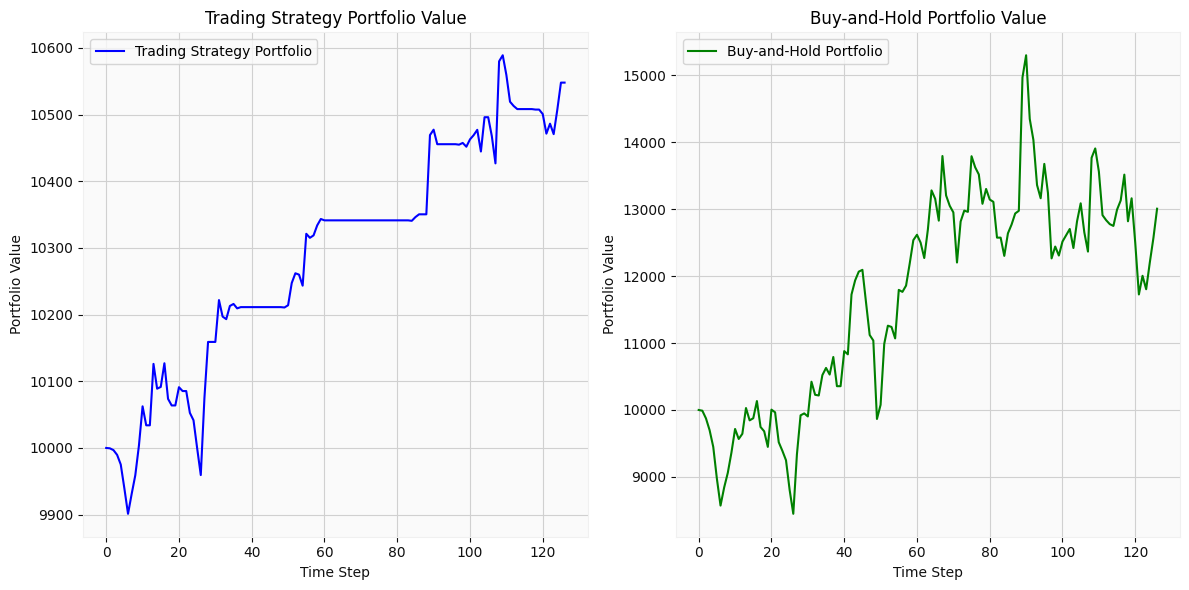

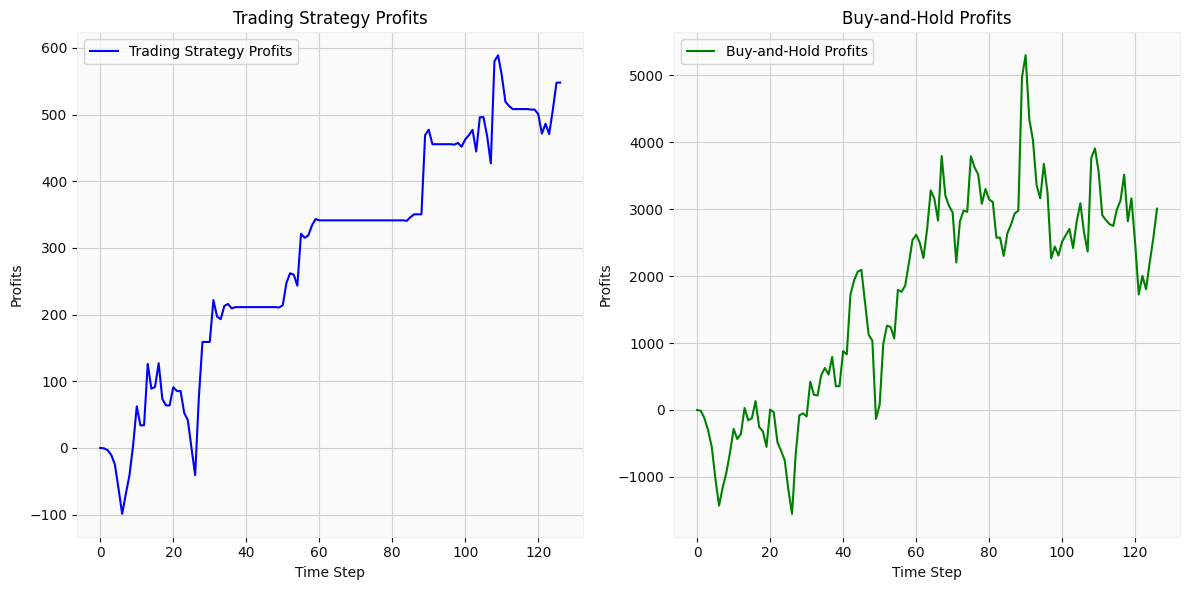

Buy-and-Hold Strategy Returns: 30.05%
Trading Strategy Returns: 5.48%


In [33]:
import matplotlib.pyplot as plt

if __name__ == "__main__":
    # Actual closing prices
    closing_prices = denormalized_targets[:-1]

    # Model predictions
    predicted_prices = denormalized_close[1:]

    # Define bid-ask spread and commission percentages (adjust these values)
    bid_ask_percentage = 0.01  # 1% of current price
    commission_percentage = 0.005  # 0.5% of current price

    strategy = TradingStrategy()

    # Lists to store portfolio values for both strategies
    trading_portfolio_values = []
    buy_and_hold_portfolio_values = []

    # Simulate trading using predicted prices
    for i in range(len(closing_prices)):
        current_price = closing_prices[i]
        predicted_price = predicted_prices[i]
        
        # Calculate bid-ask spread and commission based on percentages
        bid_ask = bid_ask_percentage * current_price
        commission = commission_percentage * current_price
        
        # Replace this logic with your trading strategy
        if predicted_price > current_price + bid_ask + commission:
            strategy.buy(current_price, bid_ask + commission, 5)
        elif predicted_price < current_price - bid_ask - commission:
            strategy.sell(current_price, bid_ask + commission, 5)
        else:
            strategy.hold()
        
        # Update and record portfolio values for both strategies
        trading_portfolio_values.append(strategy.update_portfolio_value())

    # Buy-and-Hold Strategy
    initial_investment = strategy.initial_balance
    buy_and_hold_portfolio_values = [initial_investment * (cp / closing_prices[0]) for cp in closing_prices]

    # Print final portfolio value
    final_portfolio_value = strategy.update_portfolio_value()
    print(f"Final Portfolio Value (Trading Strategy): ${final_portfolio_value:.2f}")
    print(f"Final Portfolio Value (Buy and Hold Strategy): ${buy_and_hold_portfolio_values[-1]:.2f}")
    # Calculate returns for buy-and-hold and trading strategies
    trading_strategy_returns = (final_portfolio_value - initial_investment)/ initial_investment
    buy_and_hold_returns = (buy_and_hold_portfolio_values[-1] -  initial_investment)/initial_investment
    # Create separate plots for portfolio values
    plt.figure(figsize=(12, 6))

    # Plot for Trading Strategy Portfolio
    plt.subplot(1, 2, 1)
    plt.plot(trading_portfolio_values, label='Trading Strategy Portfolio', color='blue')
    plt.xlabel('Time Step')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.title('Trading Strategy Portfolio Value')

    # Plot for Buy-and-Hold Portfolio
    plt.subplot(1, 2, 2)
    plt.plot(buy_and_hold_portfolio_values, label='Buy-and-Hold Portfolio', color='green')
    plt.xlabel('Time Step')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.title('Buy-and-Hold Portfolio Value')

    plt.tight_layout()
    plt.show()

    # Create separate plots for profits
    plt.figure(figsize=(12, 6))

    # Profits for Trading Strategy
    trading_profits = [value - initial_investment for value in trading_portfolio_values]
    plt.subplot(1, 2, 1)
    plt.plot(trading_profits, label='Trading Strategy Profits', color='blue')
    plt.xlabel('Time Step')
    plt.ylabel('Profits')
    plt.legend()
    plt.title('Trading Strategy Profits')

    # Profits for Buy-and-Hold Strategy
    buy_and_hold_profits = [value - initial_investment for value in buy_and_hold_portfolio_values]
    plt.subplot(1, 2, 2)
    plt.plot(buy_and_hold_profits, label='Buy-and-Hold Profits', color='green')
    plt.xlabel('Time Step')
    plt.ylabel('Profits')
    plt.legend()
    plt.title('Buy-and-Hold Profits')

    plt.tight_layout()
    plt.show()

    # Compare profitability
    print(f"Buy-and-Hold Strategy Returns: {buy_and_hold_returns:.2%}")
    print(f"Trading Strategy Returns: {trading_strategy_returns:.2%}")


## Evaluating the Trading System

### a) Price Prediction Error Trend
a) The price prediction error doesn't exhibit a consistent pattern as we move further away from the last time the model was trained. This variability in prediction error can be observed in the plots provided in the analysis of Question 7 (Q7).

### b) Profitability with Bid-Ask Spread and Commissions
b) Yes, we can profitably trade with bid-ask spread and commissions taken into account. The detailed statistics and results of our trading system are provided in the code and results presented above. These results demonstrate the trading module's ability to make profitable decisions even with transaction costs.

### c) Comparison with Buy-and-Hold Strategy
c) The profitability of our trading module, while successful, is notably lower when compared to a simple buy-and-hold strategy over the long term, such as one or two years. The reason for this difference is that our trading module is designed to make frequent trading decisions based on short-term predictions. In contrast, a buy-and-hold strategy involves holding an asset for an extended period, allowing it to benefit from overall market growth without reacting to short-term fluctuations.

In summary, while our trading system can generate profits, it doesn't outperform a buy-and-hold strategy in terms of long-term profitability.


## Q9
## Merging data from different stocks

In [34]:
# Function to get day of the year
def get_day_of_year(date):
    return date.timetuple().tm_yday

# Function to get day of the week (0 = Monday, 1 = Tuesday, ..., 6 = Sunday)
def get_day_of_week(date):
    return date.weekday()

In [35]:
for txt_file in txt_files:
    df[txt_file]['Year'] = df[txt_file]['DateTime'].dt.year
    # Normalize closing prices and volumes using Min-Max Scaling
    scaler = MinMaxScaler()
    norm_df[txt_file][['Open', 'High', 'Low', 'Volume', 'Close']] = scaler.fit_transform(df[txt_file][['Open', 'High', 'Low', 'Volume', 'Close']])
    min_close = np.float64(scaler.data_min_[-1])  # Minimum value of the original "Close" column
    max_close = np.float64(scaler.data_max_[-1])  # Maximum value of the original "Close" column
    norm_df[txt_file]['CloseDiff'] = norm_df[txt_file]['Close'].diff()

df_daywise = {}

for txt_file in txt_files:
    df_daywise[txt_file] = norm_df[txt_file].copy()
    df_daywise[txt_file] = group_by_date(df_daywise[txt_file])
    df_daywise[txt_file] = filter_by_date(df_daywise[txt_file], '2016-10-18', '2022-2-25')
    # Convert the "Date" column to datetime type
    df_daywise[txt_file]['Date'] = pd.to_datetime(df_daywise[txt_file]['Date'])
    # Apply the functions to create new columns
    df_daywise[txt_file]['DayOfYear'] = df_daywise[txt_file]['Date'].apply(get_day_of_year)
    df_daywise[txt_file]['DayOfWeek'] = df_daywise[txt_file]['Date'].apply(get_day_of_week)
    # Extract day, month, and year from the "Date" column
    df_daywise[txt_file]['Day'] = df_daywise[txt_file]['Date'].dt.day
    df_daywise[txt_file]['Month'] = df_daywise[txt_file]['Date'].dt.month
    for i, col in enumerate(df_daywise[txt_file].columns):
        if col != 'Date':
            new_col_name = col + "_" + txt_file
            df_daywise[txt_file].rename(columns={col: new_col_name}, inplace=True) 

In [36]:
df_merge = df_daywise['AAL_1min.txt'].copy()
for txt_file in txt_files[1:]:
    df_merge = pd.merge(df_merge, df_daywise[txt_file], on='Date')
df_merge['Year'] = df_merge['Date'].dt.year

In [37]:
def merge_and_rename_columns(df, prefix, new_column_name):
    # Get the list of columns with the specified prefix
    columns_to_merge = [col for col in df.columns if col.startswith(prefix)]
    
    # Merge the columns into a single new column with the specified name
    df[new_column_name] = df[columns_to_merge].apply(lambda row: row.iloc[0], axis=1)
    
    # Drop the original columns
    df.drop(columns_to_merge, axis=1, inplace=True)


# Merge and rename year columns
merge_and_rename_columns(df_merge, 'Year_', 'Year')

# Merge and rename day columns
merge_and_rename_columns(df_merge, 'Day_', 'Day')

# Merge and rename month columns
merge_and_rename_columns(df_merge, 'Month_', 'Month')

# Merge and rename dayofyear columns
merge_and_rename_columns(df_merge, 'DayOfYear_', 'DayOfYear')

# Merge and rename dayofweek columns
merge_and_rename_columns(df_merge, 'DayOfWeek_', 'DayOfWeek')


In [38]:
# Find the last two years in your data
last_two_years = df_merge['Year'].max() - 1

# Split the data into training and testing sets based on the 'Year' column
train_data_merged = df_merge[df_merge['Year'] < last_two_years]
test_data_merged = df_merge[df_merge['Year'] >= last_two_years]

In [39]:
def manual_normalize(column):
    # Calculate the minimum and maximum values of the column
    min_val = np.min(column)
    max_val = np.max(column)
    
    # Check for zero range to avoid division by zero
    if max_val == min_val:
        return 0.0  # If the range is zero, return a constant value (e.g., 0.0)
    else:
        # Normalize the column using Min-Max normalization
        normalized_column = (column - min_val) / (max_val - min_val)
        return normalized_column

In [40]:
# Apply manual_normalize function to the specified columns
train_data_merged['DayOfYear'] = manual_normalize(train_data_merged['DayOfYear']).values
train_data_merged['DayOfWeek'] = manual_normalize(train_data_merged['DayOfWeek']).values

C:\Users\Kaishva Shah\AppData\Local\Temp\ipykernel_37548\2308753711.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_merged['DayOfYear'] = manual_normalize(train_data_merged['DayOfYear']).values
C:\Users\Kaishva Shah\AppData\Local\Temp\ipykernel_37548\2308753711.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_merged['DayOfWeek'] = manual_normalize(train_data_merged['DayOfWeek']).values


In [41]:
train_data_merged

Date  Open_AAL_1min.txt  High_AAL_1min.txt  Low_AAL_1min.txt  \
0    2016-10-18           0.592419           0.611448          0.587701   
1    2016-10-19           0.603165           0.636868          0.602349   
2    2016-10-20           0.642830           0.652708          0.602643   
3    2016-10-21           0.625440           0.625136          0.607232   
4    2016-10-24           0.613912           0.624353          0.609576   
...         ...                ...                ...               ...   
1054 2020-12-24           0.155880           0.158441          0.147509   
1055 2020-12-28           0.161150           0.165339          0.155006   
1056 2020-12-29           0.162772           0.164933          0.151562   
1057 2020-12-30           0.153853           0.160064          0.151359   
1058 2020-12-31           0.159529           0.159050          0.149434   

      Volume_AAL_1min.txt  Close_AAL_1min.txt  CloseDiff_AAL_1min.txt  \
0                0.191084            0.602196                0.013480   
1                0.229433            0.637170                0.034974   
2                0.267012            0.625447               -0.011722   
3                0.174152            0.612943               -0.012505   
4                0.116077            0.610598               -0.002345   
...                   ...                 ...                     ...   
1054             0.573412            0.149816               -0.005473   
1055             1.113170            0.160357                0.010540   
1056             0.955565            0.151843               -0.008513   
1057             0.919146            0.159748                0.007905   
1058             1.070321            0.153465               -0.006284   

      Open_AAPL_1min.txt  High_AAPL_1min.txt  Low_AAPL_1min.txt  ...  \
0               0.146054            0.146819           0.147271  ...   
1               0.145002            0.145870           0.142892  ...   
2               0.145182            0.145382           0.146132  ...   
3               0.145117            0.145228           0.146068  ...   
4               0.144476            0.145844           0.146567  ...   
...                  ...                 ...                ...  ...   
1054            0.708734            0.721863           0.707562  ...   
1055            0.717833            0.743002           0.717781  ...   
1056            0.743876            0.750897           0.727407  ...   
1057            0.732489            0.735647           0.722293  ...   
1058            0.723771            0.728837           0.713161  ...   

      High_AA_1min.txt  Low_AA_1min.txt  Volume_AA_1min.txt  \
0             0.278834         0.264855            0.679221   
1             0.287519         0.274180            0.520906   
2             0.284214         0.277612            0.415286   
3             0.282723         0.273921            0.331190   
4             0.287390         0.279490            0.300055   
...                ...              ...                 ...   
1054          0.224757         0.216490            0.054398   
1055          0.231523         0.219611            0.198530   
1056          0.224757         0.207908            0.174655   
1057          0.233606         0.218700            0.172596   
1058          0.236859         0.224161            0.172165   

      Close_AA_1min.txt  CloseDiff_AA_1min.txt  Year  Day  Month  DayOfYear  \
0              0.274450              -0.003888  2016   18     10   0.796703   
1              0.282873               0.008422  2016   19     10   0.799451   
2              0.279375              -0.003498  2016   20     10   0.802198   
3              0.281319               0.001944  2016   21     10   0.804945   
4              0.281188              -0.000130  2016   24     10   0.813187   
...                 ...                    ...   ...  ...    ...        ...   
1054           0.217253              -0.007545  2020   24 

### Q9 a) We now predict AA closing prices from the data received from 4 stocks

In [242]:
import torch
import torch.utils.data as data

class StockDataset(data.Dataset):
    def __init__(self, stock_data, sequence_length, window_length):
        self.stock_data = stock_data
        self.sequence_length = sequence_length
        self.window = window_length

    def __len__(self):
        return len(self.stock_data) - self.sequence_length - self.window + 1

    def __getitem__(self, index):
        input_seq = self.stock_data.iloc[index:index + self.sequence_length][['Open_AAL_1min.txt', 'High_AAL_1min.txt', 'Low_AAL_1min.txt', 'Volume_AAL_1min.txt',
    'Close_AAL_1min.txt', 'CloseDiff_AAL_1min.txt', 'Open_AAPL_1min.txt', 'High_AAPL_1min.txt',
    'Low_AAPL_1min.txt', 'Volume_AAPL_1min.txt', 'Close_AAPL_1min.txt', 'CloseDiff_AAPL_1min.txt',
    'Open_AAP_1min.txt', 'High_AAP_1min.txt', 'Low_AAP_1min.txt', 'Volume_AAP_1min.txt',
    'Close_AAP_1min.txt', 'CloseDiff_AAP_1min.txt', 'Open_AA_1min.txt', 'High_AA_1min.txt',
    'Low_AA_1min.txt', 'Volume_AA_1min.txt', 'Close_AA_1min.txt', 'CloseDiff_AA_1min.txt'
]].values
        target = self.stock_data.iloc[index + self.sequence_length:index + self.sequence_length+self.window]['Close_AA_1min.txt'].values
        input_seq = [list(map(float, row)) for row in input_seq]
        target = [float(val) for val in target]
        # Convert to PyTorch tensors
        input_seq = torch.tensor(input_seq, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)  # Convert to NumPy array first

        return input_seq, target

def create_dataloader(stock_data, sequence_length, batch_size, window_length=1, shuffle=False):
    dataset = StockDataset(stock_data, sequence_length, window_length)
    dataloader = data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)
    return dataloader

sequence_length = 100  # Number of time steps in each sequence
batch_size = 64  # Batch size for training
window_length = 10
# Create data loaders for training and testing
train_dataloader_merged = create_dataloader(train_data_merged, sequence_length, batch_size, window_length)
test_dataloader_merged = create_dataloader(test_data_merged, sequence_length, batch_size, window_length)


In [243]:
import torch
import torch.nn as nn

class InterdayLSTM_merged(nn.Module):
    def __init__(self, input_dim, hidden_units, num_layers, output_dim):
        super(InterdayLSTM_merged, self).__init__()
        self.input_dim = input_dim
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        self.output_dim = output_dim
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_units, num_layers, batch_first=True)
        
        # Define the output layer
        self.output_layer = nn.Linear(hidden_units, output_dim)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_units).to(x.device)
        
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_units).to(x.device)
        
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Index hidden state of last time step
        out = self.output_layer(out[:, -1, :])
        return out


Epoch [1/30], Train Loss: 0.0775
Epoch [1/30], Test Loss: 0.0002
Epoch [2/30], Train Loss: 0.0201
Epoch [2/30], Test Loss: 0.0002
Epoch [3/30], Train Loss: 0.0082
Epoch [3/30], Test Loss: 0.0005
Epoch [4/30], Train Loss: 0.0049
Epoch [4/30], Test Loss: 0.0007
Epoch [5/30], Train Loss: 0.0048
Epoch [5/30], Test Loss: 0.0006
Epoch [6/30], Train Loss: 0.0026
Epoch [6/30], Test Loss: 0.0006
Epoch [7/30], Train Loss: 0.0026
Epoch [7/30], Test Loss: 0.0006
Epoch [8/30], Train Loss: 0.0024
Epoch [8/30], Test Loss: 0.0005
Epoch [9/30], Train Loss: 0.0024
Epoch [9/30], Test Loss: 0.0006
Epoch [10/30], Train Loss: 0.0023
Epoch [10/30], Test Loss: 0.0005
Epoch [11/30], Train Loss: 0.0022
Epoch [11/30], Test Loss: 0.0006
Epoch [12/30], Train Loss: 0.0020
Epoch [12/30], Test Loss: 0.0005
Epoch [13/30], Train Loss: 0.0020
Epoch [13/30], Test Loss: 0.0005
Epoch [14/30], Train Loss: 0.0020
Epoch [14/30], Test Loss: 0.0005
Epoch [15/30], Train Loss: 0.0019
Epoch [15/30], Test Loss: 0.0005
Epoch [16/30]

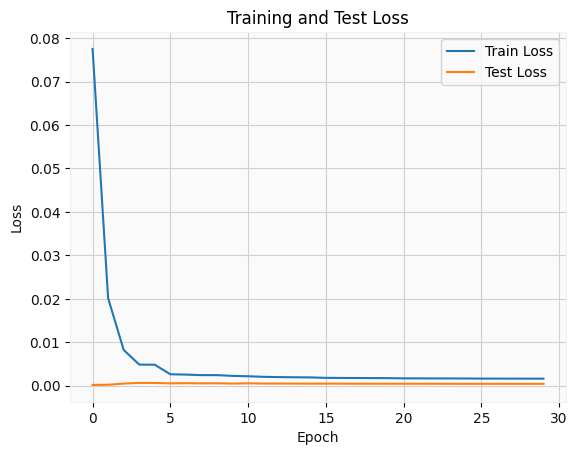

In [244]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# input_dim = 5  # Number of input features
# hidden_dim = 100  # Number of hidden units in the LSTM
# num_layers = 2  # Number of LSTM layers
# output_dim = 1  # Number of output units (1 for a single output)


# Instantiate the model and move it to the appropriate device (CPU or GPU)
# model = SingleOutputLSTM(input_dim, hidden_units, num_layers, output_dim).to(device)


# # Hyperparameters
input_dim = 24  # Number of input features (Open, High, Low, Volume)
hidden_units = 100  # Number of hidden units in the LSTM layer
num_layers = 1  # Number of LSTM layers
output_dim = 10  # Number of output features (e.g., predicting Close price)
learning_rate = 0.001
num_epochs = 30
batch_size = 64

# Define a custom weight initialization function
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)

# Instantiate the model and move it to the appropriate device (CPU or GPU)
model = InterdayLSTM_merged(input_dim, hidden_units, num_layers, output_dim).to(device)

# Apply weight initialization
model.apply(init_weights)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean squared error loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler to gradually reduce learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    
    for batch_X, batch_y in train_dataloader_merged:  # train_dataloader_merged is created using create_dataloader function
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move data to the same device as the model
        
        optimizer.zero_grad()  # Clear gradients
        
        # Forward pass
        outputs = model(batch_X)
        
        # Reshape batch_y to match the shape of outputs
#         batch_y = batch_y.view(-1, 1)
        
        # Calculate loss
        loss = criterion(outputs, batch_y)
        
        # Backpropagation
        loss.backward()
        
        # Clip gradients to prevent exploding gradients
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item() * len(batch_X)
    
    average_loss = total_loss / len(train_dataloader_merged.dataset)
    train_losses.append(average_loss)  # Append the loss value to the list
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_loss:.4f}")
    
    # Validation loop (on the test dataset)
    model.eval()
    total_test_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_dataloader_merged:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            # Inside the training loop
            # Reshape batch_y to match the shape of outputs
#             batch_y = batch_y.view(-1, 1)
            outputs = model(batch_X)
            test_loss = criterion(outputs, batch_y)
            total_test_loss += test_loss.item()
    
    average_test_loss = total_test_loss / len(test_dataloader_merged.dataset)
    test_losses.append(average_test_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {average_test_loss:.4f}")
    
    # Adjust learning rate using the scheduler
    scheduler.step()

print("Training finished!")

# Plot the loss
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')
plt.show()

# Save the model state dictionary to a file
torch.save(model.state_dict(), 'model_weights.pth')


In [245]:
# Example usage:
avg_test_loss, test_outputs, targets = evaluate_model(model, test_dataloader_merged)
print(f"Average Test Loss: {avg_test_loss:.4f}")
print(f"Total Loss: {total_loss:.4f}")
print(f"Number of Batches: {len(test_dataloader_merged)}")

Average Test Loss: 0.0029
Total Loss: 1.5458
Number of Batches: 2


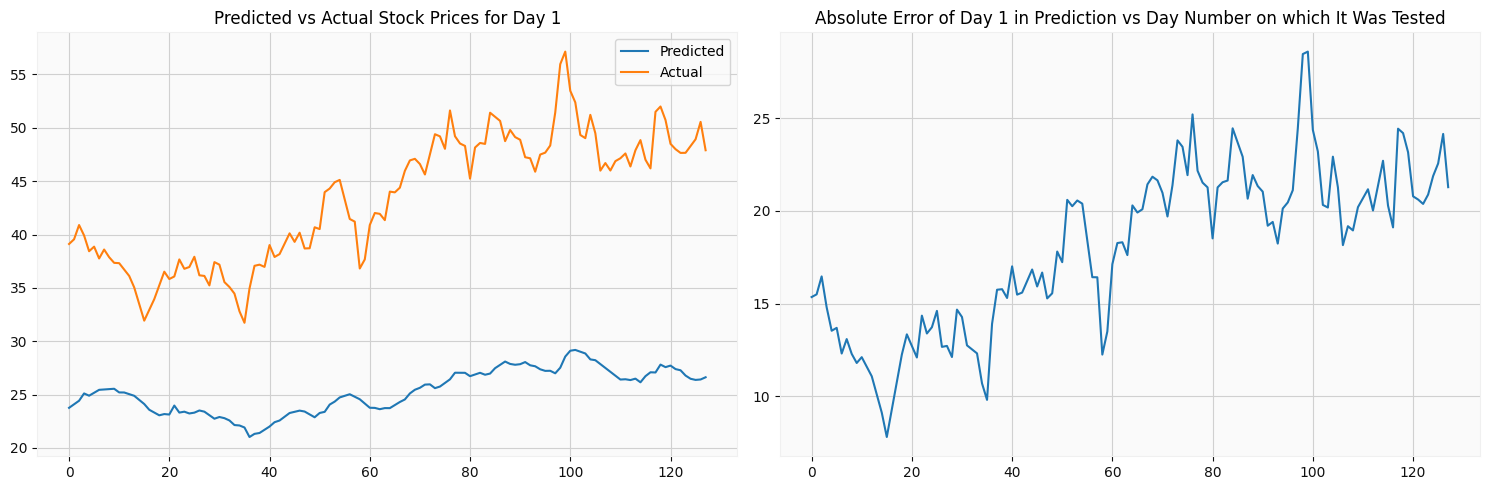

Average Absolute Error of Day 1:  18.01550966811378


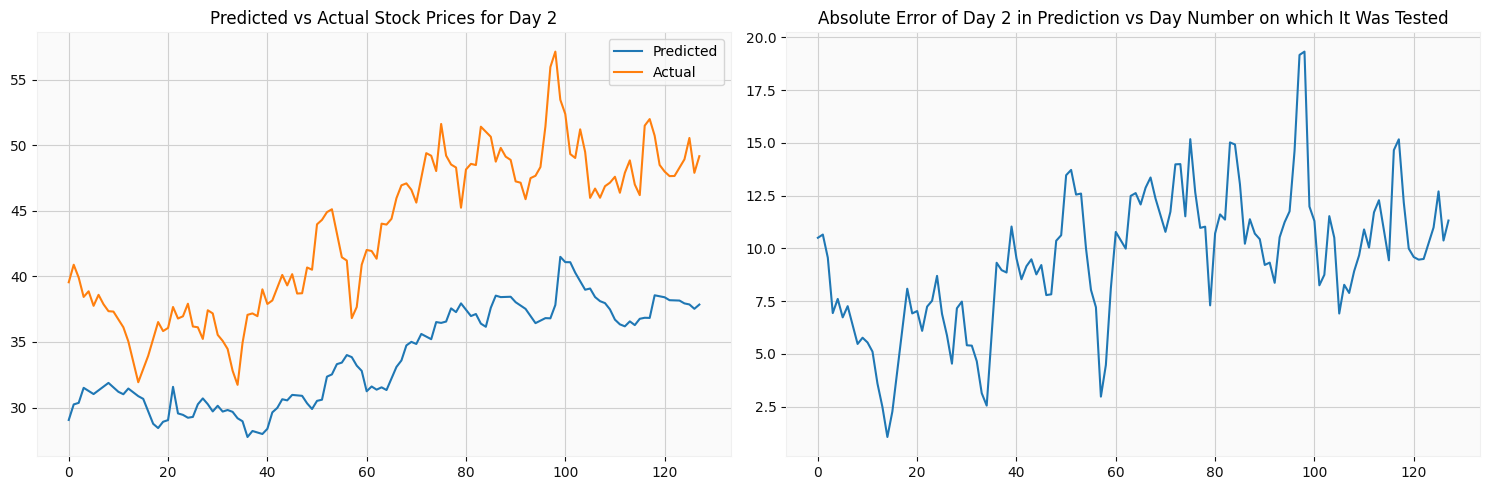

Average Absolute Error of Day 2:  9.502943009986868


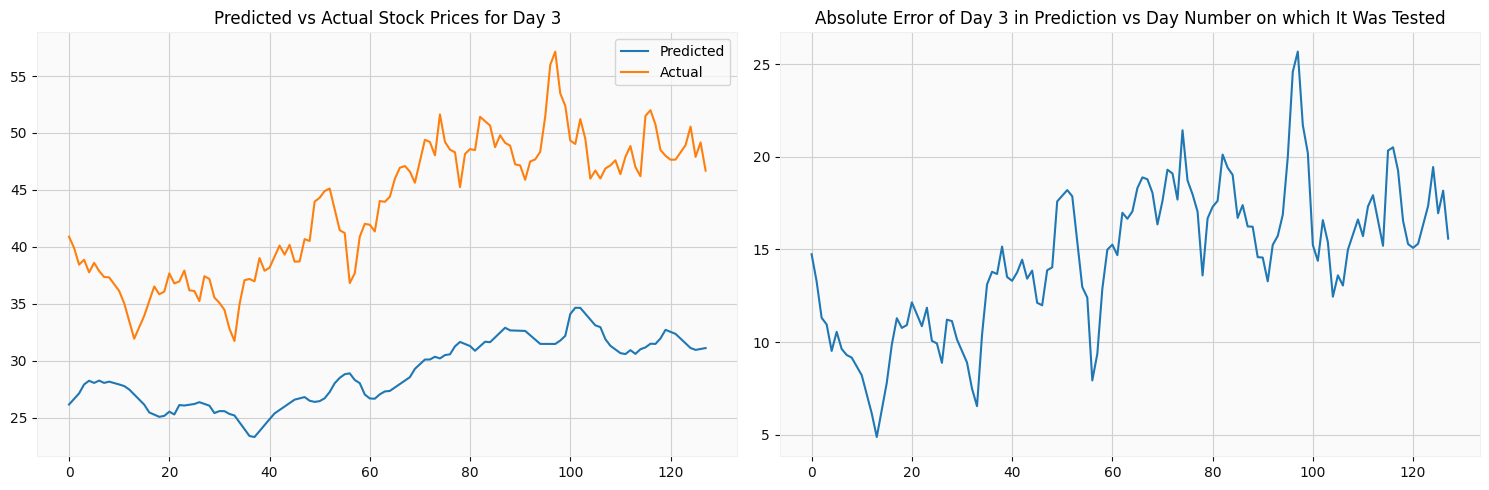

Average Absolute Error of Day 3:  14.513527882082746


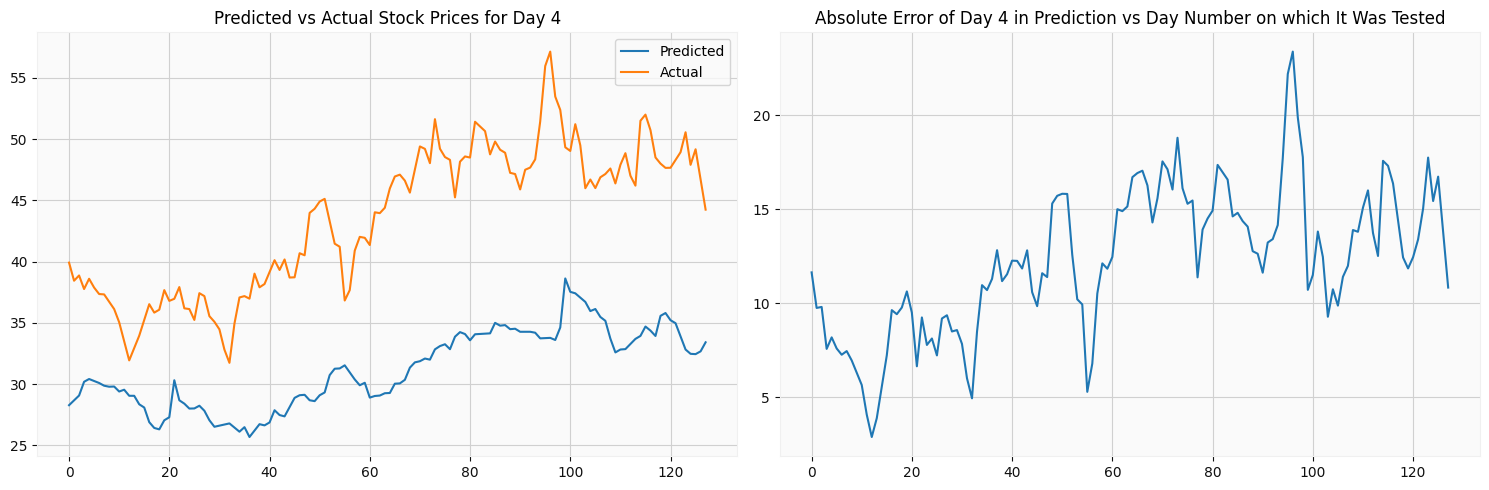

Average Absolute Error of Day 4:  12.275178901307237


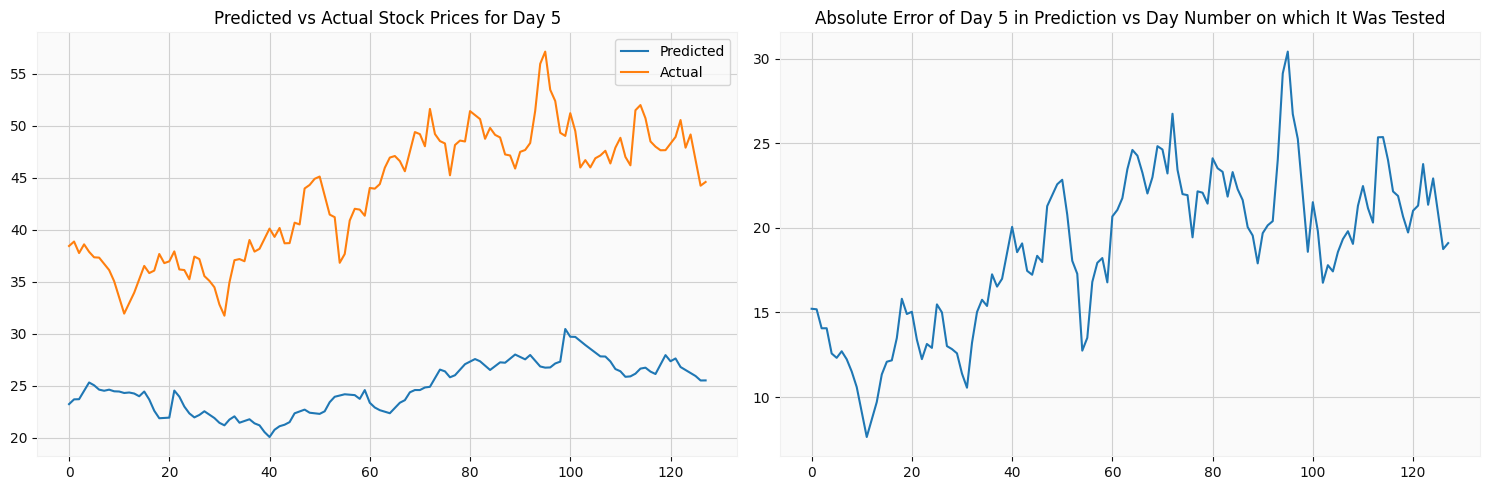

Average Absolute Error of Day 5:  18.706067838072684


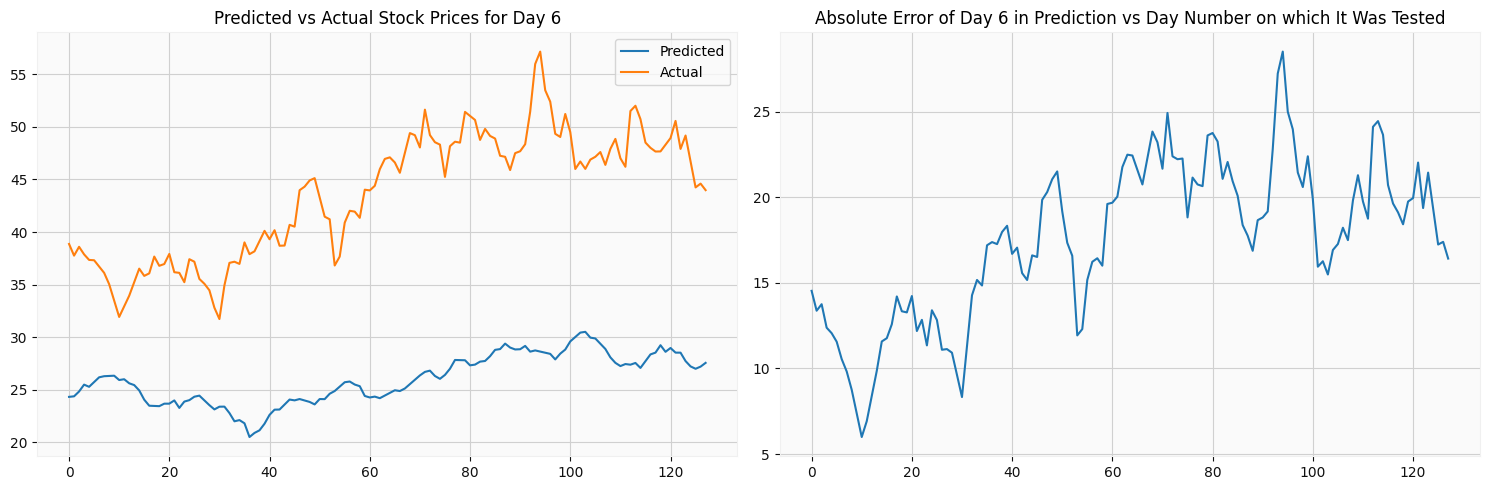

Average Absolute Error of Day 6:  17.530382172041747


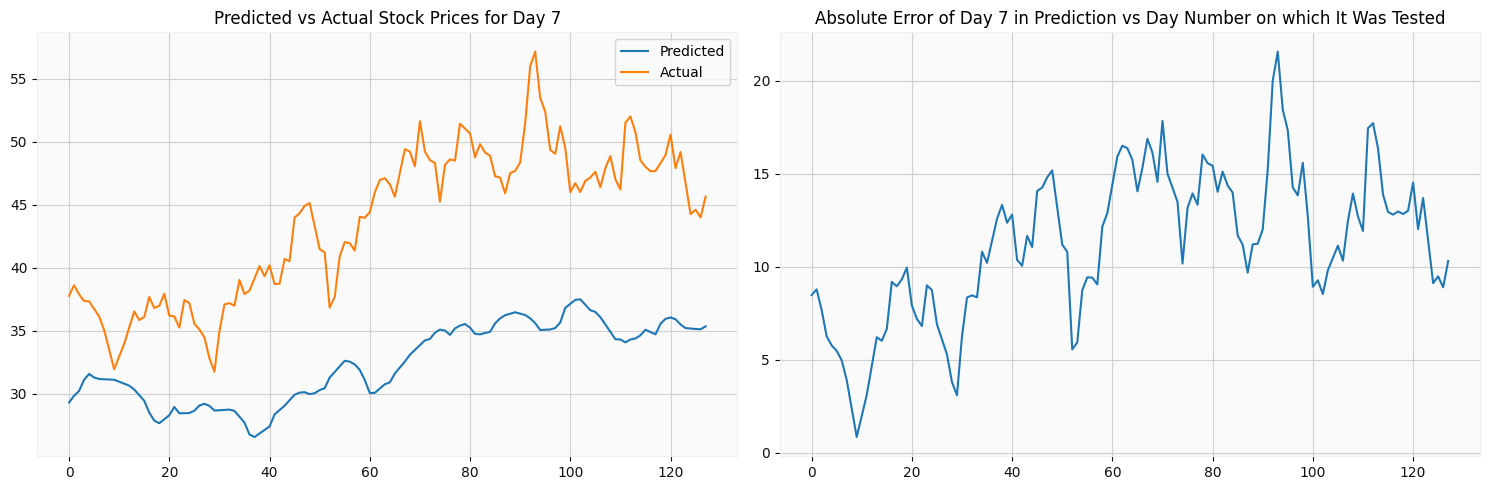

Average Absolute Error of Day 7:  11.21665886339871


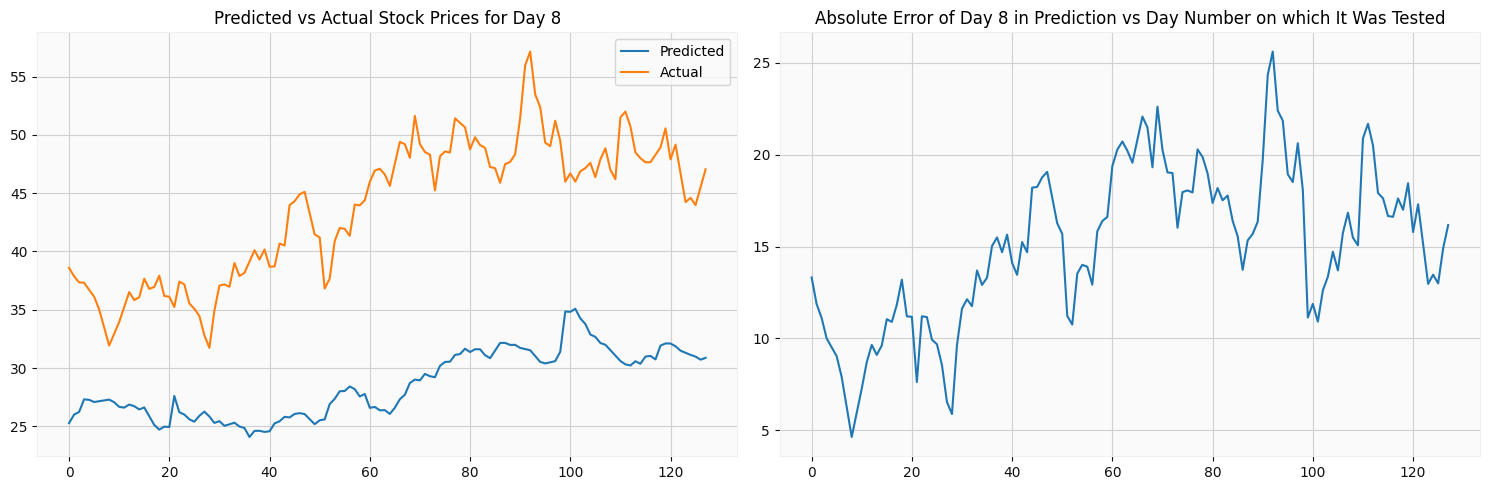

Average Absolute Error of Day 8:  15.075750950911964


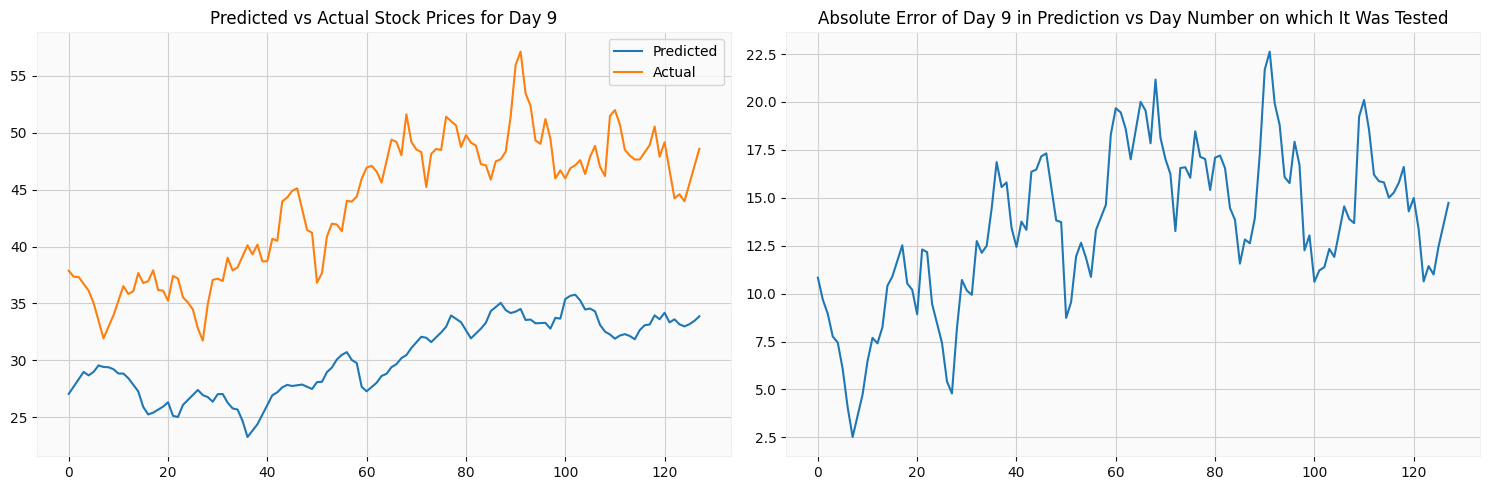

Average Absolute Error of Day 9:  13.536569868539178


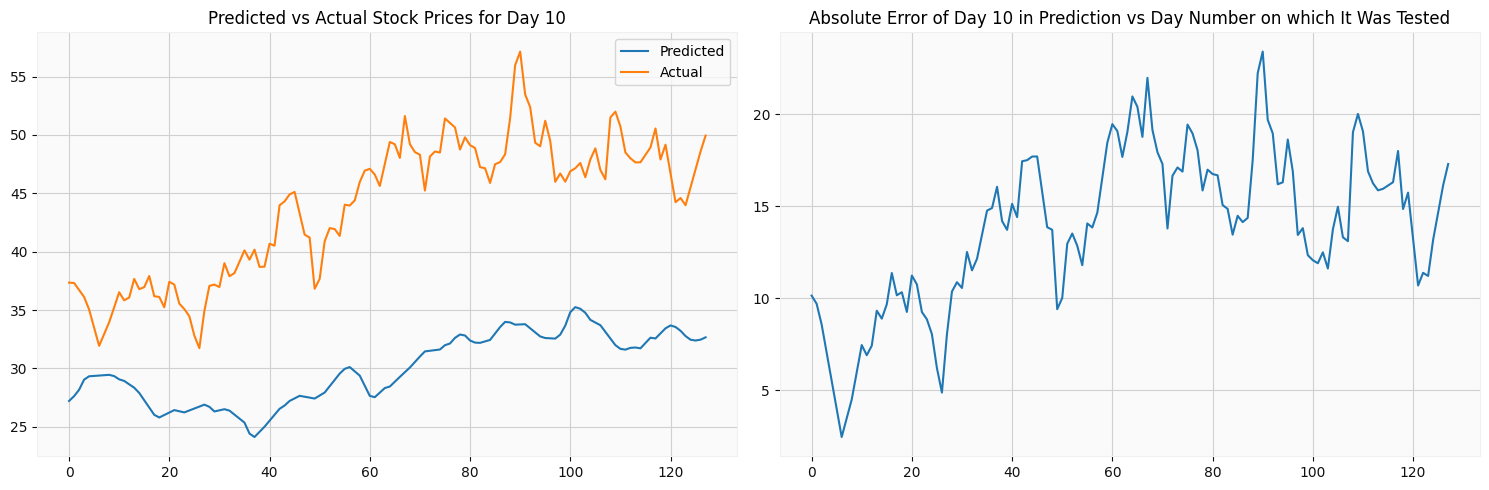

Average Absolute Error of Day 10:  13.87100370892945


Text(0, 0.5, 'Absolute difference')

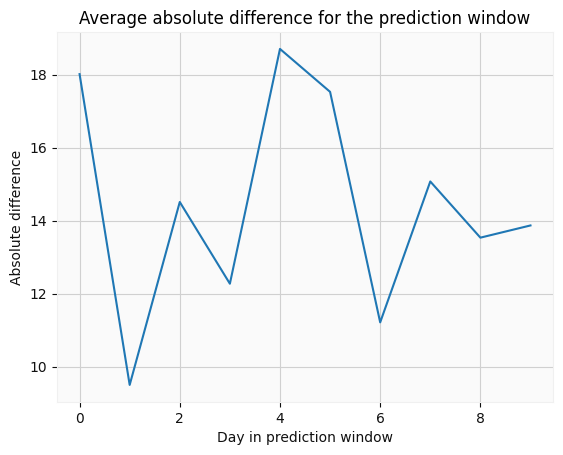

In [248]:
import numpy as np
import matplotlib.pyplot as plt
average_abs_diff = np.array([])
for i in range(output_dim): 
    # Convert `outputs` to a NumPy array
    normalized_close = np.array(np.array(test_outputs)[:, i], dtype=np.float64)
    targets_close = np.array(np.array(targets)[:, i], dtype=np.float64)
    # Denormalize the "Close" column
    min_close = np.float64(scaler.data_min_[-1])  # Minimum value of the original "Close" column
    max_close = np.float64(scaler.data_max_[-1])  # Maximum value of the original "Close" column
    denormalized_close = (normalized_close * (max_close - min_close)) + min_close
    denormalized_targets = (targets_close * (max_close - min_close)) + min_close
    
    # Create subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot predicted and actual values
    ax1.plot(denormalized_close.reshape(-1), label='Predicted')
    ax1.plot(denormalized_targets.reshape(-1), label='Actual')
    ax1.set_title(f"Predicted vs Actual Stock Prices for Day {i+1}")
    ax1.legend()

    # Plot absolute error
    abs_diff = np.abs(denormalized_close - denormalized_targets)
    ax2.plot(abs_diff)
    ax2.set_title(f"Absolute Error of Day {i+1} in Prediction vs Day Number on which It Was Tested")

    plt.tight_layout()
    plt.show()

    average_abs_diff = np.append(average_abs_diff,np.abs(denormalized_close - denormalized_targets).mean())
    print(f"Average Absolute Error of Day {i+1}: ", average_abs_diff[-1])

plt.plot(average_abs_diff)
plt.title("Average absolute difference for the prediction window")
plt.xlabel("Day in prediction window")
plt.ylabel("Absolute difference")

### Q9 a) Results


As observed, the average prediction error has notably increased. This phenomenon can be attributed to the fact that the model is now handling multiple potentially uncorrelated stocks. Consequently, these diverse stocks may not contribute significantly to the learning process, and their inclusion in the dataset may introduce noise that adversely impacts the prediction accuracy. Moreover, the dataset may contain numerous features that are irrelevant for the prediction task. The model struggles to discern their contributions and eliminate their noise, further exacerbating the prediction error. In essence, the presence of these extraneous features has a detrimental effect on the model's ability to make accurate predictions.

### Q9 b)

In [60]:
train_data_merged 

Date  Open_AAL_1min.txt  High_AAL_1min.txt  Low_AAL_1min.txt  \
0    2016-10-18           0.592419           0.611448          0.587701   
1    2016-10-19           0.603165           0.636868          0.602349   
2    2016-10-20           0.642830           0.652708          0.602643   
3    2016-10-21           0.625440           0.625136          0.607232   
4    2016-10-24           0.613912           0.624353          0.609576   
...         ...                ...                ...               ...   
1054 2020-12-24           0.155880           0.158441          0.147509   
1055 2020-12-28           0.161150           0.165339          0.155006   
1056 2020-12-29           0.162772           0.164933          0.151562   
1057 2020-12-30           0.153853           0.160064          0.151359   
1058 2020-12-31           0.159529           0.159050          0.149434   

      Volume_AAL_1min.txt  Close_AAL_1min.txt  CloseDiff_AAL_1min.txt  \
0                0.191084            0.602196                0.013480   
1                0.229433            0.637170                0.034974   
2                0.267012            0.625447               -0.011722   
3                0.174152            0.612943               -0.012505   
4                0.116077            0.610598               -0.002345   
...                   ...                 ...                     ...   
1054             0.573412            0.149816               -0.005473   
1055             1.113170            0.160357                0.010540   
1056             0.955565            0.151843               -0.008513   
1057             0.919146            0.159748                0.007905   
1058             1.070321            0.153465               -0.006284   

      Open_AAPL_1min.txt  High_AAPL_1min.txt  Low_AAPL_1min.txt  ...  \
0               0.146054            0.146819           0.147271  ...   
1               0.145002            0.145870           0.142892  ...   
2               0.145182            0.145382           0.146132  ...   
3               0.145117            0.145228           0.146068  ...   
4               0.144476            0.145844           0.146567  ...   
...                  ...                 ...                ...  ...   
1054            0.708734            0.721863           0.707562  ...   
1055            0.717833            0.743002           0.717781  ...   
1056            0.743876            0.750897           0.727407  ...   
1057            0.732489            0.735647           0.722293  ...   
1058            0.723771            0.728837           0.713161  ...   

      High_AA_1min.txt  Low_AA_1min.txt  Volume_AA_1min.txt  \
0             0.278834         0.264855            0.679221   
1             0.287519         0.274180            0.520906   
2             0.284214         0.277612            0.415286   
3             0.282723         0.273921            0.331190   
4             0.287390         0.279490            0.300055   
...                ...              ...                 ...   
1054          0.224757         0.216490            0.054398   
1055          0.231523         0.219611            0.198530   
1056          0.224757         0.207908            0.174655   
1057          0.233606         0.218700            0.172596   
1058          0.236859         0.224161            0.172165   

      Close_AA_1min.txt  CloseDiff_AA_1min.txt  Year  DayOfYear  DayOfWeek  \
0              0.274450              -0.003888  2016   0.796703       0.25   
1              0.282873               0.008422  2016   0.799451       0.50   
2              0.279375              -0.003498  2016   0.802198       0.75   
3              0.281319               0.001944  2016   0.804945       1.00   
4              0.281188              -0.000130  2016   0.813187       0.00   
...                 ...                    ...   ...        ...        ...   
1054           0.217253              -0.007545  2020   0.980769  

In [61]:
train_data_merged

Date  Open_AAL_1min.txt  High_AAL_1min.txt  Low_AAL_1min.txt  \
0    2016-10-18           0.592419           0.611448          0.587701   
1    2016-10-19           0.603165           0.636868          0.602349   
2    2016-10-20           0.642830           0.652708          0.602643   
3    2016-10-21           0.625440           0.625136          0.607232   
4    2016-10-24           0.613912           0.624353          0.609576   
...         ...                ...                ...               ...   
1054 2020-12-24           0.155880           0.158441          0.147509   
1055 2020-12-28           0.161150           0.165339          0.155006   
1056 2020-12-29           0.162772           0.164933          0.151562   
1057 2020-12-30           0.153853           0.160064          0.151359   
1058 2020-12-31           0.159529           0.159050          0.149434   

      Volume_AAL_1min.txt  Close_AAL_1min.txt  CloseDiff_AAL_1min.txt  \
0                0.191084            0.602196                0.013480   
1                0.229433            0.637170                0.034974   
2                0.267012            0.625447               -0.011722   
3                0.174152            0.612943               -0.012505   
4                0.116077            0.610598               -0.002345   
...                   ...                 ...                     ...   
1054             0.573412            0.149816               -0.005473   
1055             1.113170            0.160357                0.010540   
1056             0.955565            0.151843               -0.008513   
1057             0.919146            0.159748                0.007905   
1058             1.070321            0.153465               -0.006284   

      Open_AAPL_1min.txt  High_AAPL_1min.txt  Low_AAPL_1min.txt  ...  \
0               0.146054            0.146819           0.147271  ...   
1               0.145002            0.145870           0.142892  ...   
2               0.145182            0.145382           0.146132  ...   
3               0.145117            0.145228           0.146068  ...   
4               0.144476            0.145844           0.146567  ...   
...                  ...                 ...                ...  ...   
1054            0.708734            0.721863           0.707562  ...   
1055            0.717833            0.743002           0.717781  ...   
1056            0.743876            0.750897           0.727407  ...   
1057            0.732489            0.735647           0.722293  ...   
1058            0.723771            0.728837           0.713161  ...   

      High_AA_1min.txt  Low_AA_1min.txt  Volume_AA_1min.txt  \
0             0.278834         0.264855            0.679221   
1             0.287519         0.274180            0.520906   
2             0.284214         0.277612            0.415286   
3             0.282723         0.273921            0.331190   
4             0.287390         0.279490            0.300055   
...                ...              ...                 ...   
1054          0.224757         0.216490            0.054398   
1055          0.231523         0.219611            0.198530   
1056          0.224757         0.207908            0.174655   
1057          0.233606         0.218700            0.172596   
1058          0.236859         0.224161            0.172165   

      Close_AA_1min.txt  CloseDiff_AA_1min.txt  Year  DayOfYear  DayOfWeek  \
0              0.274450              -0.003888  2016   0.796703       0.25   
1              0.282873               0.008422  2016   0.799451       0.50   
2              0.279375              -0.003498  2016   0.802198       0.75   
3              0.281319               0.001944  2016   0.804945       1.00   
4              0.281188              -0.000130  2016   0.813187       0.00   
...                 ...                    ...   ...        ...        ...   
1054           0.217253              -0.007545  2020   0.980769  

In [62]:
df_merge

Date  Open_AAL_1min.txt  High_AAL_1min.txt  Low_AAL_1min.txt  \
0    2016-10-18           0.592419           0.611448          0.587701   
1    2016-10-19           0.603165           0.636868          0.602349   
2    2016-10-20           0.642830           0.652708          0.602643   
3    2016-10-21           0.625440           0.625136          0.607232   
4    2016-10-24           0.613912           0.624353          0.609576   
...         ...                ...                ...               ...   
1344 2022-02-18           0.204732           0.206724          0.190465   
1345 2022-02-22           0.192164           0.195566          0.178308   
1346 2022-02-23           0.191759           0.194349          0.168177   
1347 2022-02-24           0.166826           0.176293          0.146496   
1348 2022-02-25           0.166826           0.191103          0.167164   

      Volume_AAL_1min.txt  Close_AAL_1min.txt  CloseDiff_AAL_1min.txt  \
0                0.191084            0.602196                0.013480   
1                0.229433            0.637170                0.034974   
2                0.267012            0.625447               -0.011722   
3                0.174152            0.612943               -0.012505   
4                0.116077            0.610598               -0.002345   
...                   ...                 ...                     ...   
1344             0.547586            0.192181               -0.008919   
1345             0.590516            0.188329               -0.003851   
1346             0.644384            0.167857               -0.020473   
1347             1.036779            0.171911                0.004054   
1348             0.812050            0.186910                0.015000   

      Open_AAPL_1min.txt  High_AAPL_1min.txt  Low_AAPL_1min.txt  ...  \
0               0.146054            0.146819           0.147271  ...   
1               0.145002            0.145870           0.142892  ...   
2               0.145182            0.145382           0.146132  ...   
3               0.145117            0.145228           0.146068  ...   
4               0.144476            0.145844           0.146567  ...   
...                  ...                 ...                ...  ...   
1344            0.926962            0.933274           0.907253  ...   
1345            0.905885            0.915314           0.873356  ...   
1346            0.905885            0.908574           0.868428  ...   
1347            0.862524            0.888595           0.829000  ...   
1348            0.888266            0.901054           0.876258  ...   

      High_AA_1min.txt  Low_AA_1min.txt  Volume_AA_1min.txt  \
0             0.278834         0.264855            0.679221   
1             0.287519         0.274180            0.520906   
2             0.284214         0.277612            0.415286   
3             0.282723         0.273921            0.331190   
4             0.287390         0.279490            0.300055   
...                ...              ...                 ...   
1344          0.954481         0.917385            0.254930   
1345          1.000000         0.885589            0.403013   
1346          0.924874         0.885591            0.297150   
1347          0.949264         0.843109            0.535546   
1348          0.954220         0.859007            0.327635   

      Close_AA_1min.txt  CloseDiff_AA_1min.txt  Year  DayOfYear  DayOfWeek  \
0              0.274450              -0.003888  2016        292          1   
1              0.282873               0.008422  2016        293          2   
2              0.279375              -0.003498  2016        294          3   
3              0.281319               0.001944  2016        295          4   
4              0.281188              -0.000130  2016        298          0   
...                 ...                    ...   ...        ...        ...   
1344           0.951239               0.021512  2022         49  

In [249]:
import torch
import torch.utils.data as data

class StockDataset(data.Dataset):
    def __init__(self, stock_data, sequence_length, window_length):
        self.stock_data = stock_data
        self.sequence_length = sequence_length
        self.window = window_length

    def __len__(self):
        return len(self.stock_data) - self.sequence_length - self.window + 1

    def __getitem__(self, index):
        input_seq = self.stock_data.iloc[index:index + self.sequence_length][['Open_AA_1min.txt', 'High_AA_1min.txt',
    'Low_AA_1min.txt', 'Volume_AA_1min.txt', 'Close_AA_1min.txt', 'CloseDiff_AA_1min.txt', 'DayOfWeek', 'DayOfYear']].values
#         input_seq = self.stock_data.iloc[index:index + self.sequence_length][[ 'CloseDiff']].values
        target = self.stock_data.iloc[index + self.sequence_length:index + self.sequence_length+self.window]['Close_AA_1min.txt'].values
        input_seq = [list(map(float, row)) for row in input_seq]
        target = [float(val) for val in target]
        # Convert to PyTorch tensors
        input_seq = torch.tensor(input_seq, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)  # Convert to NumPy array first

        return input_seq, target

def create_dataloader(stock_data, sequence_length, batch_size, window_length=1, shuffle=False):
    dataset = StockDataset(stock_data, sequence_length, window_length)
    dataloader = data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)
    return dataloader

sequence_length = 100  # Number of time steps in each sequence
batch_size = 64  # Batch size for training
window_length = 10
# Create data loaders for training and testing
train_dataloader_merged = create_dataloader(train_data_merged, sequence_length, batch_size, window_length)
test_dataloader_merged = create_dataloader(test_data_merged, sequence_length, batch_size, window_length)


In [250]:
# Load a batch of training data
for batch_X, batch_y in train_dataloader_merged:
    # Print the shapes of batch_X and batch_y
    print("Batch X shape:", batch_X.shape)
    print("Batch y shape:", batch_y.shape)

    # Print the first sequence in the batch
#     print("First sequence in the batch:")
#     print(batch_X[0])
#     print("Corresponding target:")
#     print(batch_y[0])

    # Break the loop to only inspect one batch
    break


Batch X shape: torch.Size([64, 100, 8])
Batch y shape: torch.Size([64, 10])


Epoch [1/30], Train Loss: 0.0889
Epoch [1/30], Test Loss: 0.0010
Epoch [2/30], Train Loss: 0.0325
Epoch [2/30], Test Loss: 0.0009
Epoch [3/30], Train Loss: 0.0214
Epoch [3/30], Test Loss: 0.0010
Epoch [4/30], Train Loss: 0.0111
Epoch [4/30], Test Loss: 0.0013
Epoch [5/30], Train Loss: 0.0027
Epoch [5/30], Test Loss: 0.0015
Epoch [6/30], Train Loss: 0.0028
Epoch [6/30], Test Loss: 0.0015
Epoch [7/30], Train Loss: 0.0056
Epoch [7/30], Test Loss: 0.0015
Epoch [8/30], Train Loss: 0.0035
Epoch [8/30], Test Loss: 0.0015
Epoch [9/30], Train Loss: 0.0115
Epoch [9/30], Test Loss: 0.0014
Epoch [10/30], Train Loss: 0.0036
Epoch [10/30], Test Loss: 0.0015
Epoch [11/30], Train Loss: 0.0108
Epoch [11/30], Test Loss: 0.0014
Epoch [12/30], Train Loss: 0.0027
Epoch [12/30], Test Loss: 0.0014
Epoch [13/30], Train Loss: 0.0015
Epoch [13/30], Test Loss: 0.0014
Epoch [14/30], Train Loss: 0.0016
Epoch [14/30], Test Loss: 0.0015
Epoch [15/30], Train Loss: 0.0012
Epoch [15/30], Test Loss: 0.0015
Epoch [16/30]

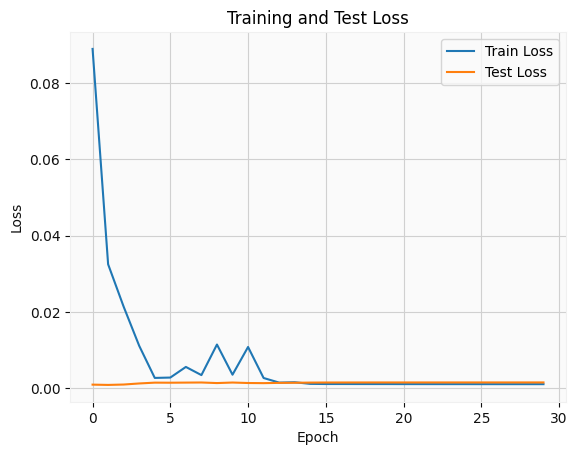

In [252]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# input_dim = 5  # Number of input features
# hidden_dim = 100  # Number of hidden units in the LSTM
# num_layers = 2  # Number of LSTM layers
# output_dim = 1  # Number of output units (1 for a single output)


# Instantiate the model and move it to the appropriate device (CPU or GPU)
# model = SingleOutputLSTM(input_dim, hidden_units, num_layers, output_dim).to(device)


# # Hyperparameters
input_dim = 8  # Number of input features (Open, High, Low, Volume)
hidden_units = 100  # Number of hidden units in the LSTM layer
num_layers = 2  # Number of LSTM layers
output_dim = 10  # Number of output features (e.g., predicting Close price)
learning_rate = 0.001
num_epochs = 30
batch_size = 64

# Define a custom weight initialization function
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)

# Instantiate the model and move it to the appropriate device (CPU or GPU)
model = InterdayLSTM_merged(input_dim, hidden_units, num_layers, output_dim).to(device)

# Apply weight initialization
model.apply(init_weights)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean squared error loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler to gradually reduce learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    
    for batch_X, batch_y in train_dataloader_merged:  # train_dataloader_merged is created using create_dataloader function
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move data to the same device as the model
        
        optimizer.zero_grad()  # Clear gradients
        
        # Forward pass
        outputs = model(batch_X)
        
        # Reshape batch_y to match the shape of outputs
#         batch_y = batch_y.view(-1, 1)
        
        # Calculate loss
        loss = criterion(outputs, batch_y)
        
        # Backpropagation
        loss.backward()
        
        # Clip gradients to prevent exploding gradients
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item() * len(batch_X)
    
    average_loss = total_loss / len(train_dataloader_merged.dataset)
    train_losses.append(average_loss)  # Append the loss value to the list
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_loss:.4f}")
    
    # Validation loop (on the test dataset)
    model.eval()
    total_test_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_dataloader_merged:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            # Inside the training loop
            # Reshape batch_y to match the shape of outputs
#             batch_y = batch_y.view(-1, 1)
            outputs = model(batch_X)
            test_loss = criterion(outputs, batch_y)
            total_test_loss += test_loss.item()
    
    average_test_loss = total_test_loss / len(test_dataloader_merged.dataset)
    test_losses.append(average_test_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {average_test_loss:.4f}")
    
    # Adjust learning rate using the scheduler
    scheduler.step()

print("Training finished!")

# Plot the loss
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')
plt.show()

# Save the model state dictionary to a file
torch.save(model.state_dict(), 'model_weights.pth')


In [253]:
# Example usage:
avg_test_loss, test_outputs, targets = evaluate_model(model, test_dataloader_merged)
print(f"Average Test Loss: {avg_test_loss:.4f}")
print(f"Total Loss: {total_loss:.4f}")
print(f"Number of Batches: {len(test_dataloader_merged)}")

Average Test Loss: 0.0054
Total Loss: 1.0530
Number of Batches: 2


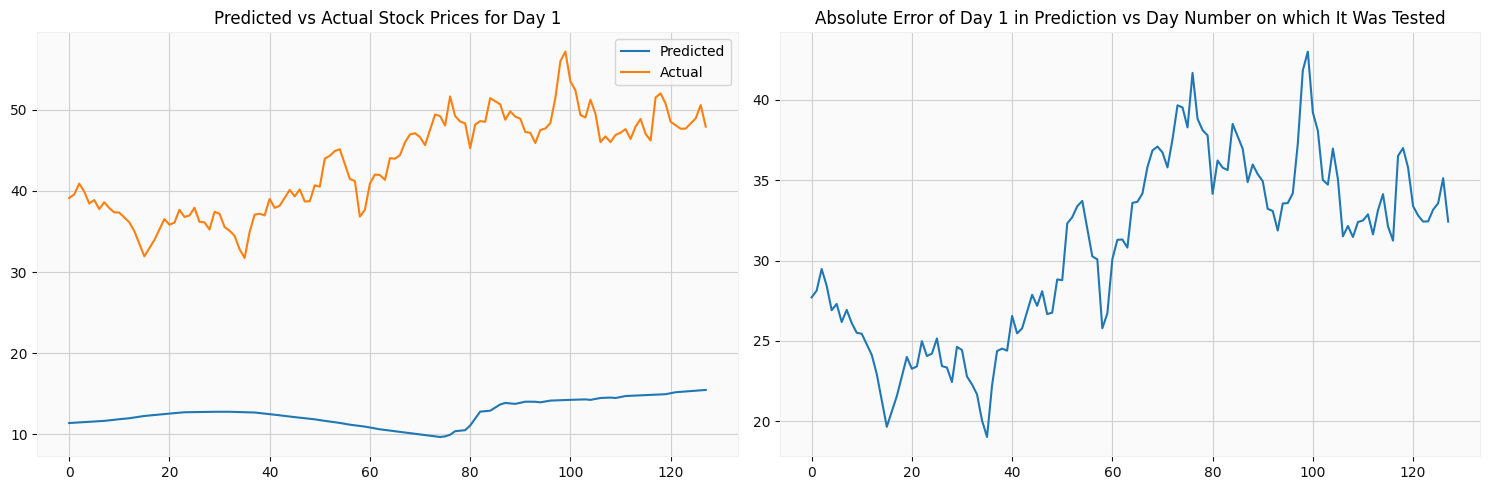

Average Absolute Error of Day 1:  30.66836334249289


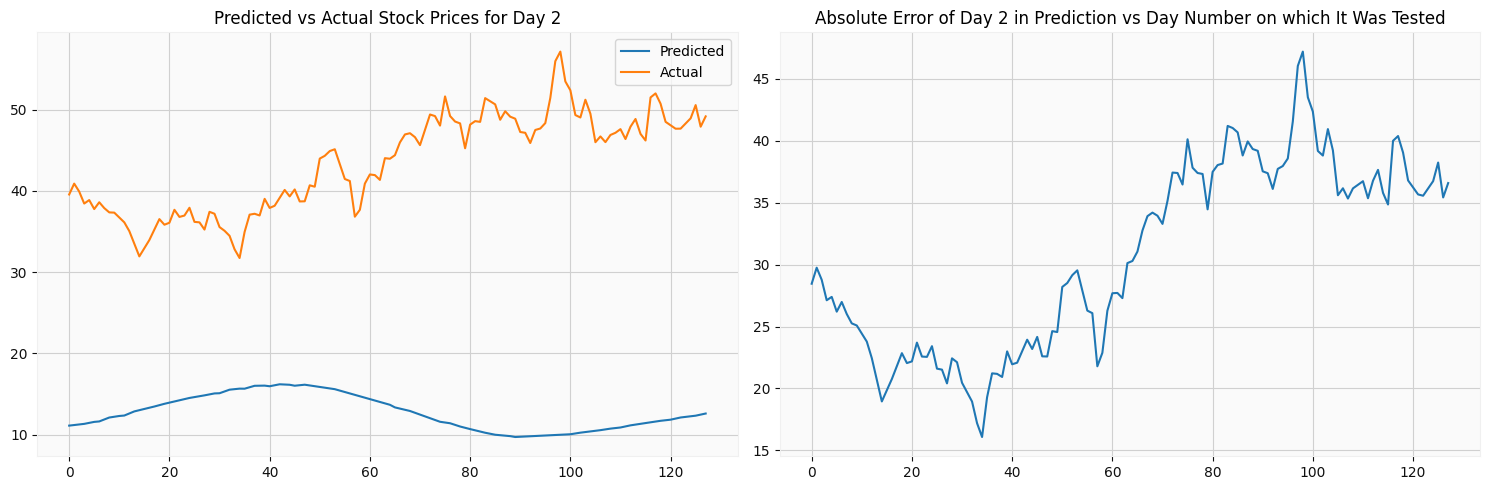

Average Absolute Error of Day 2:  30.673450318146543


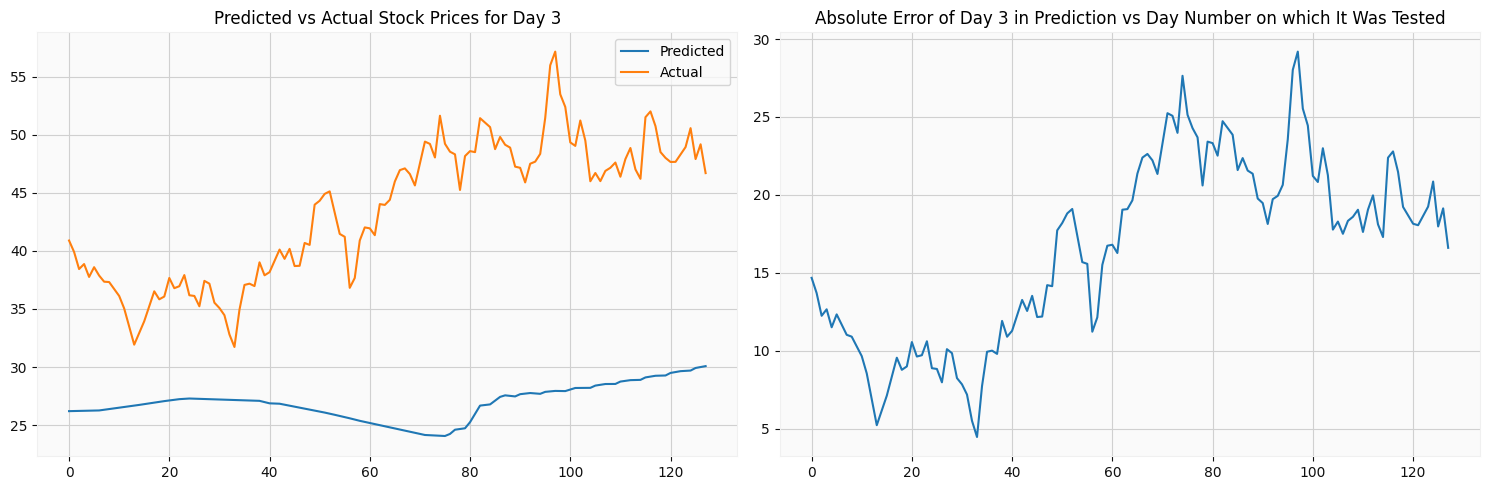

Average Absolute Error of Day 3:  16.504224971674834


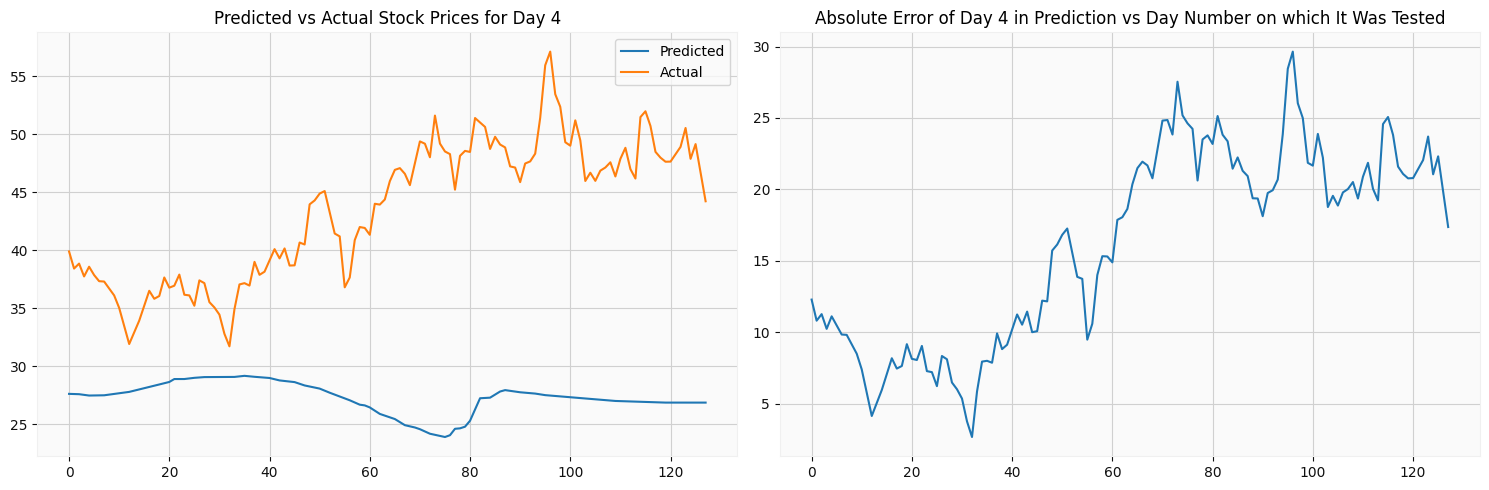

Average Absolute Error of Day 4:  16.122260098824043


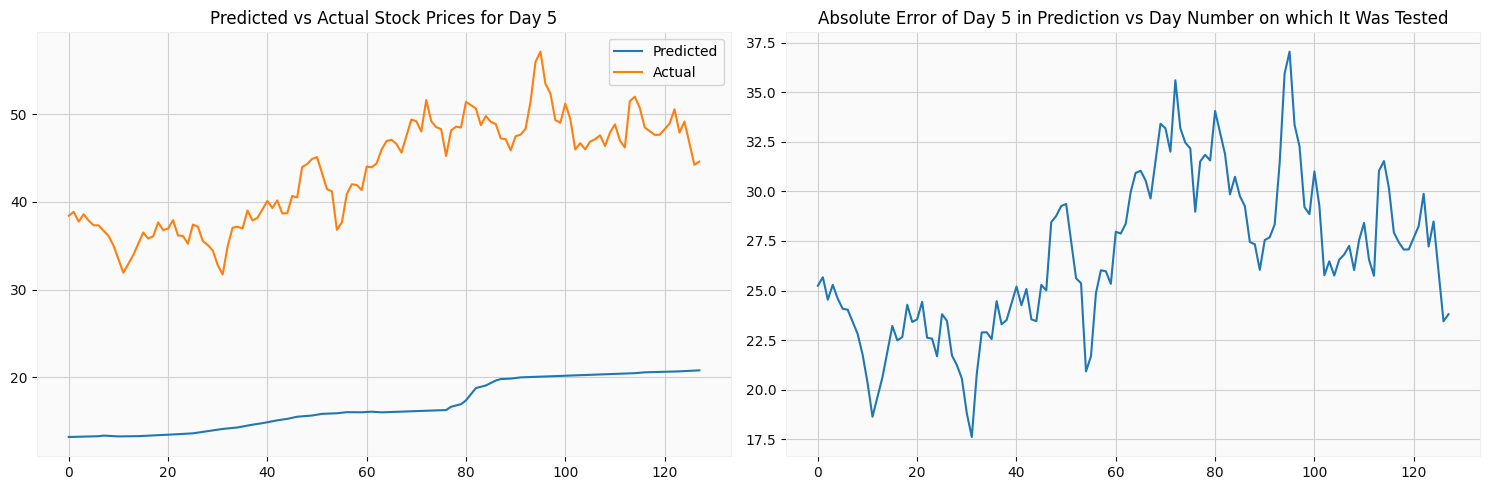

Average Absolute Error of Day 5:  26.729078961966252


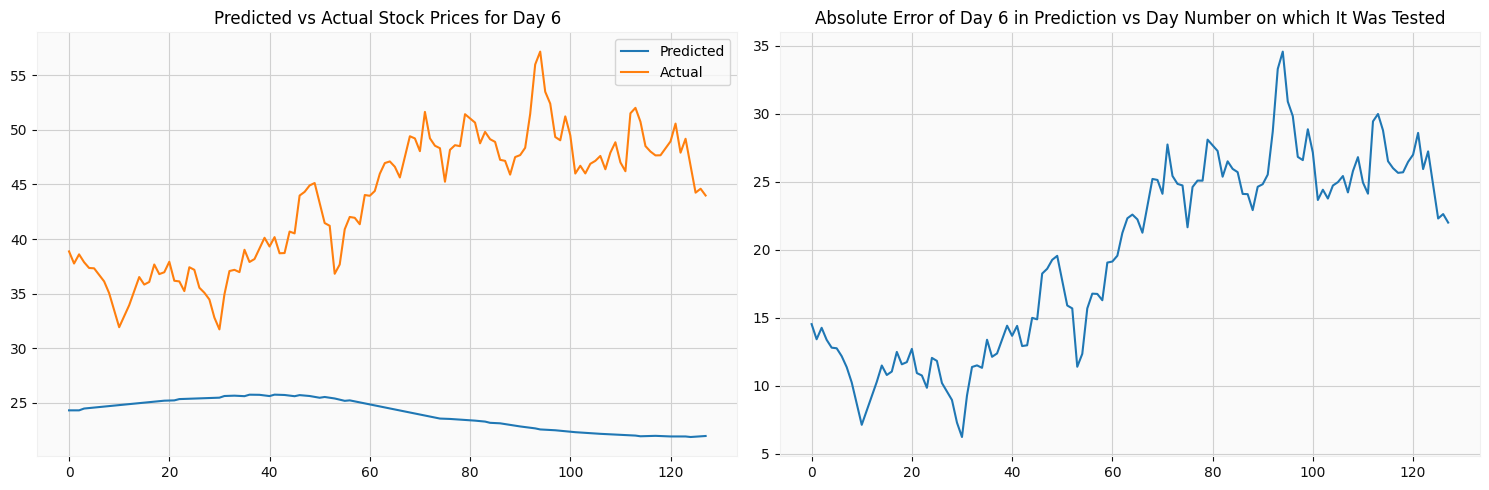

Average Absolute Error of Day 6:  19.54134127421089


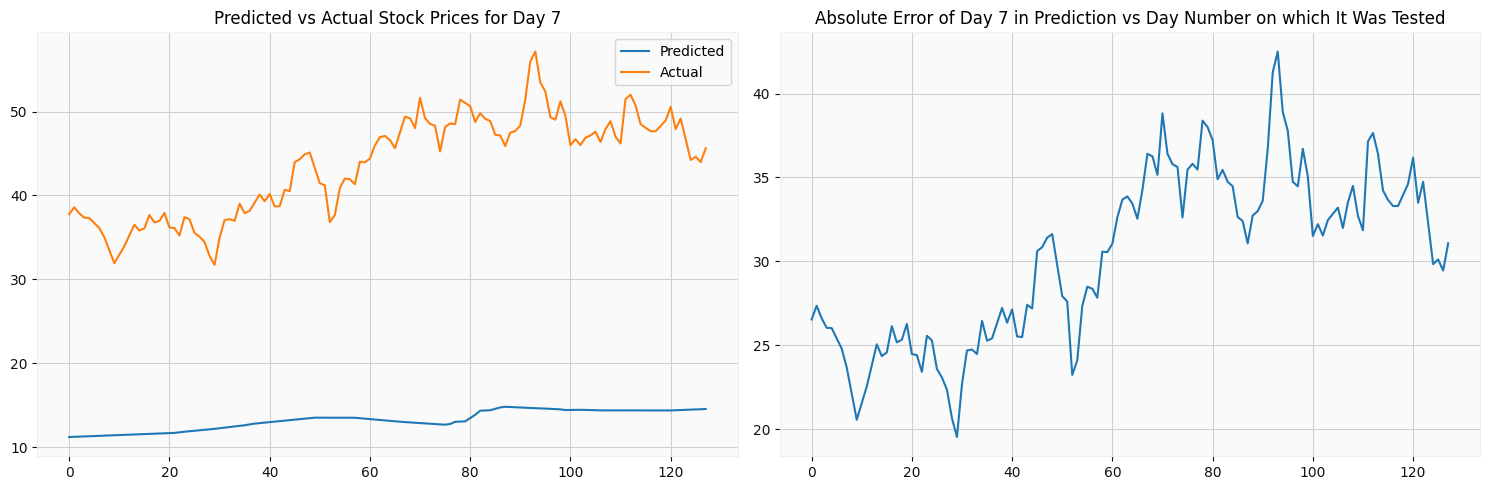

Average Absolute Error of Day 7:  30.355270613752708


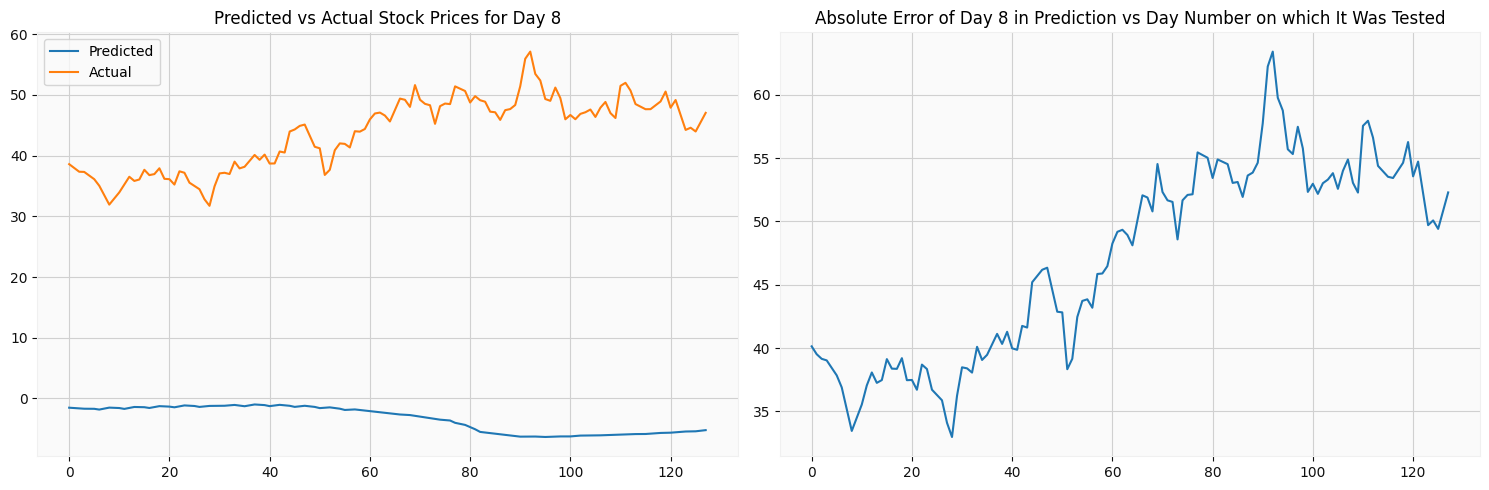

Average Absolute Error of Day 8:  47.031743162538476


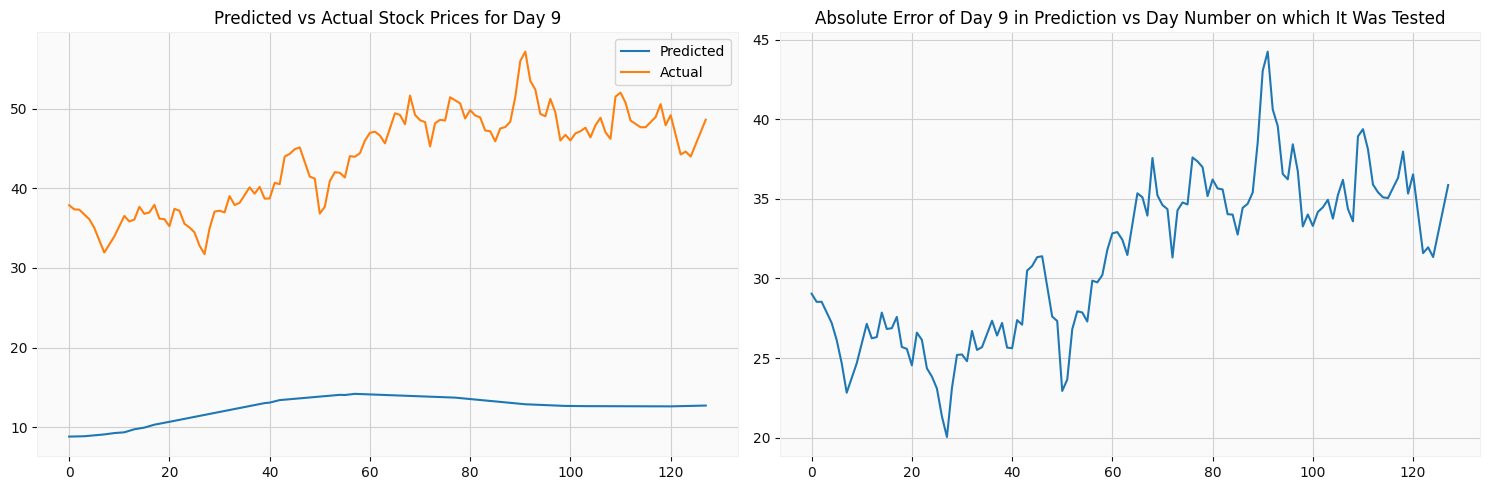

Average Absolute Error of Day 9:  31.268341641329627


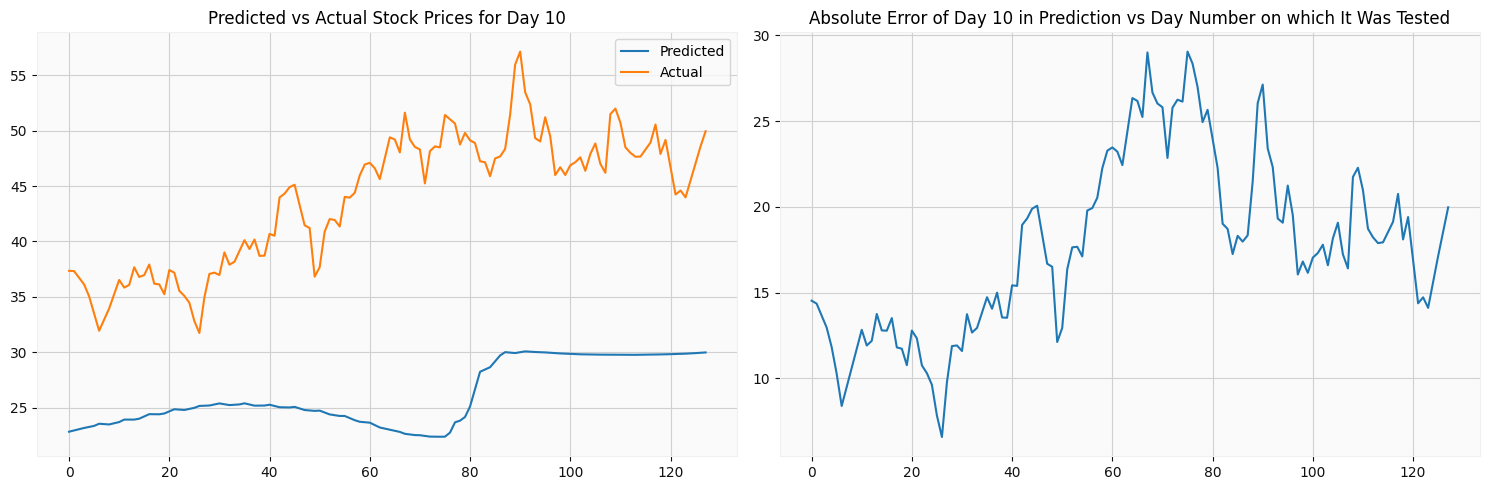

Average Absolute Error of Day 10:  17.70224386009894


Text(0, 0.5, 'Absolute difference')

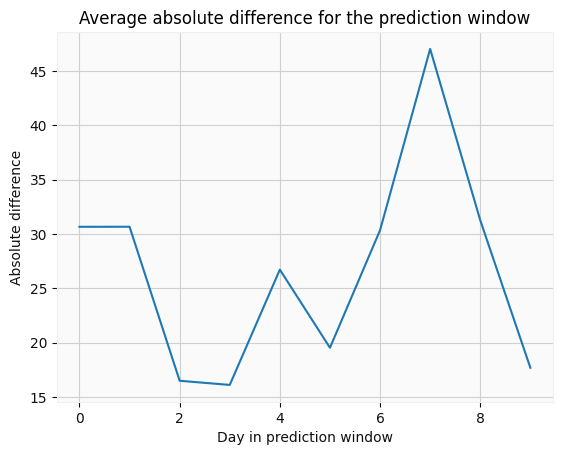

In [254]:
import numpy as np
import matplotlib.pyplot as plt
average_abs_diff = np.array([])
for i in range(output_dim): 
    # Convert `outputs` to a NumPy array
    normalized_close = np.array(np.array(test_outputs)[:, i], dtype=np.float64)
    targets_close = np.array(np.array(targets)[:, i], dtype=np.float64)
    # Denormalize the "Close" column
    min_close = np.float64(scaler.data_min_[-1])  # Minimum value of the original "Close" column
    max_close = np.float64(scaler.data_max_[-1])  # Maximum value of the original "Close" column
    denormalized_close = (normalized_close * (max_close - min_close)) + min_close
    denormalized_targets = (targets_close * (max_close - min_close)) + min_close
    
    # Create subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot predicted and actual values
    ax1.plot(denormalized_close.reshape(-1), label='Predicted')
    ax1.plot(denormalized_targets.reshape(-1), label='Actual')
    ax1.set_title(f"Predicted vs Actual Stock Prices for Day {i+1}")
    ax1.legend()

    # Plot absolute error
    abs_diff = np.abs(denormalized_close - denormalized_targets)
    ax2.plot(abs_diff)
    ax2.set_title(f"Absolute Error of Day {i+1} in Prediction vs Day Number on which It Was Tested")

    plt.tight_layout()
    plt.show()

    average_abs_diff = np.append(average_abs_diff,np.abs(denormalized_close - denormalized_targets).mean())
    print(f"Average Absolute Error of Day {i+1}: ", average_abs_diff[-1])

plt.plot(average_abs_diff)
plt.title("Average absolute difference for the prediction window")
plt.xlabel("Day in prediction window")
plt.ylabel("Absolute difference")

### Q9 b) Results

In our latest model iteration, we introduced the 'DayOfYear' and 'DayOfWeek' columns as inputs. However, the results reveal a significant deterioration in the prediction model's performance. While the model does make an attempt to capture the underlying patterns in the data, it struggles to align with the testing data's target curve, exhibiting a noticeable disparity. This regression in performance can be primarily attributed to the inclusion of 'DayOfYear' and 'DayOfWeek' columns as features.

It is important to note that these additional columns are, in fact, highly irrelevant for a model tasked with predicting the closing price of a specific stock based on historical data. The model's core objective is to analyze a sequence of 100 past data points to forecast the stock's closing price 10 steps into the future. In this context, the 'DayOfYear' and 'DayOfWeek' features introduce a substantial amount of noise into the dataset, effectively diminishing the model's predictive capabilities.

### Q9 c) We now add the dayOfWeek and DayOfYear features combined with the features from 4 more stocks to predict the closing price of the stock of interest 

In [264]:
import torch
import torch.utils.data as data

class StockDataset(data.Dataset):
    def __init__(self, stock_data, sequence_length, window_length):
        self.stock_data = stock_data
        self.sequence_length = sequence_length
        self.window = window_length

    def __len__(self):
        return len(self.stock_data) - self.sequence_length - self.window + 1

    def __getitem__(self, index):
        input_seq = self.stock_data.iloc[index:index + self.sequence_length][['Open_AAL_1min.txt', 'High_AAL_1min.txt', 'Low_AAL_1min.txt', 'Volume_AAL_1min.txt',
    'Close_AAL_1min.txt', 'CloseDiff_AAL_1min.txt', 'Open_AAPL_1min.txt', 'High_AAPL_1min.txt',
    'Low_AAPL_1min.txt', 'Volume_AAPL_1min.txt', 'Close_AAPL_1min.txt', 'CloseDiff_AAPL_1min.txt',
    'Open_AAP_1min.txt', 'High_AAP_1min.txt', 'Low_AAP_1min.txt', 'Volume_AAP_1min.txt',
    'Close_AAP_1min.txt', 'CloseDiff_AAP_1min.txt', 'Open_AA_1min.txt', 'High_AA_1min.txt',
    'Low_AA_1min.txt', 'Volume_AA_1min.txt', 'Close_AA_1min.txt', 'CloseDiff_AA_1min.txt', 'DayOfWeek', 'DayOfYear']].values
#         input_seq = self.stock_data.iloc[index:index + self.sequence_length][[ 'CloseDiff']].values
        target = self.stock_data.iloc[index + self.sequence_length:index + self.sequence_length+self.window]['Close_AA_1min.txt'].values
        input_seq = [list(map(float, row)) for row in input_seq]
        target = [float(val) for val in target]
        # Convert to PyTorch tensors
        input_seq = torch.tensor(input_seq, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)  # Convert to NumPy array first

        return input_seq, target

def create_dataloader(stock_data, sequence_length, batch_size, window_length=1, shuffle=False):
    dataset = StockDataset(stock_data, sequence_length, window_length)
    dataloader = data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)
    return dataloader

sequence_length = 100  # Number of time steps in each sequence
batch_size = 64  # Batch size for training
window_length = 10
# Create data loaders for training and testing
train_dataloader_merged = create_dataloader(train_data_merged, sequence_length, batch_size, window_length)
test_dataloader_merged = create_dataloader(test_data_merged, sequence_length, batch_size, window_length)


In [258]:
train_data_merged.dtypes

Date                       datetime64[ns]
Open_AAL_1min.txt                 float64
High_AAL_1min.txt                 float64
Low_AAL_1min.txt                  float64
Volume_AAL_1min.txt               float64
Close_AAL_1min.txt                float64
CloseDiff_AAL_1min.txt            float64
Open_AAPL_1min.txt                float64
High_AAPL_1min.txt                float64
Low_AAPL_1min.txt                 float64
Volume_AAPL_1min.txt              float64
Close_AAPL_1min.txt               float64
CloseDiff_AAPL_1min.txt           float64
Open_AAP_1min.txt                 float64
High_AAP_1min.txt                 float64
Low_AAP_1min.txt                  float64
Volume_AAP_1min.txt               float64
Close_AAP_1min.txt                float64
CloseDiff_AAP_1min.txt            float64
Open_AA_1min.txt                  float64
High_AA_1min.txt                  float64
Low_AA_1min.txt                   float64
Volume_AA_1min.txt                float64
Close_AA_1min.txt                 

In [259]:
# Load a batch of training data
for batch_X, batch_y in train_dataloader_merged:
    # Print the shapes of batch_X and batch_y
    print("Batch X shape:", batch_X.shape)
    print("Batch y shape:", batch_y.shape)

    # Print the first sequence in the batch
#     print("First sequence in the batch:")
#     print(batch_X[0])
#     print("Corresponding target:")
#     print(batch_y[0])

    # Break the loop to only inspect one batch
    break


Batch X shape: torch.Size([64, 100, 26])
Batch y shape: torch.Size([64, 10])


Epoch [1/30], Train Loss: 0.0964
Epoch [1/30], Test Loss: 0.0015
Epoch [2/30], Train Loss: 0.0415
Epoch [2/30], Test Loss: 0.0014
Epoch [3/30], Train Loss: 0.0272
Epoch [3/30], Test Loss: 0.0014
Epoch [4/30], Train Loss: 0.0210
Epoch [4/30], Test Loss: 0.0016
Epoch [5/30], Train Loss: 0.0109
Epoch [5/30], Test Loss: 0.0019
Epoch [6/30], Train Loss: 0.0047
Epoch [6/30], Test Loss: 0.0020
Epoch [7/30], Train Loss: 0.0039
Epoch [7/30], Test Loss: 0.0020
Epoch [8/30], Train Loss: 0.0042
Epoch [8/30], Test Loss: 0.0020
Epoch [9/30], Train Loss: 0.0033
Epoch [9/30], Test Loss: 0.0020
Epoch [10/30], Train Loss: 0.0036
Epoch [10/30], Test Loss: 0.0020
Epoch [11/30], Train Loss: 0.0026
Epoch [11/30], Test Loss: 0.0020
Epoch [12/30], Train Loss: 0.0026
Epoch [12/30], Test Loss: 0.0020
Epoch [13/30], Train Loss: 0.0025
Epoch [13/30], Test Loss: 0.0020
Epoch [14/30], Train Loss: 0.0025
Epoch [14/30], Test Loss: 0.0020
Epoch [15/30], Train Loss: 0.0024
Epoch [15/30], Test Loss: 0.0020
Epoch [16/30]

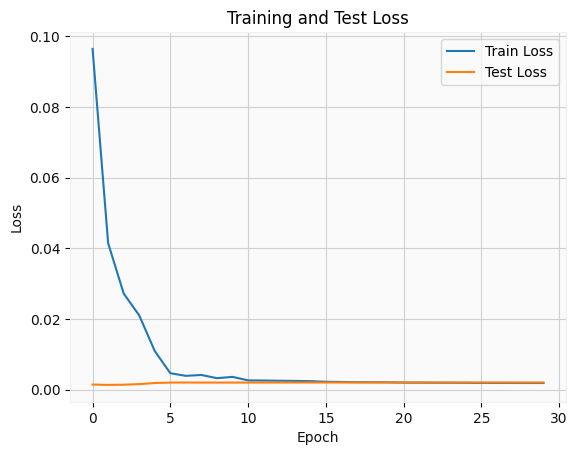

In [260]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# input_dim = 5  # Number of input features
# hidden_dim = 100  # Number of hidden units in the LSTM
# num_layers = 2  # Number of LSTM layers
# output_dim = 1  # Number of output units (1 for a single output)


# Instantiate the model and move it to the appropriate device (CPU or GPU)
# model = SingleOutputLSTM(input_dim, hidden_units, num_layers, output_dim).to(device)


# # Hyperparameters
input_dim = 26  # Number of input features (Open, High, Low, Volume)
hidden_units = 50  # Number of hidden units in the LSTM layer
num_layers = 3  # Number of LSTM layers
output_dim = 10  # Number of output features (e.g., predicting Close price)
learning_rate = 0.001
num_epochs = 30
batch_size = 64

# Define a custom weight initialization function
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)

# Instantiate the model and move it to the appropriate device (CPU or GPU)
model = InterdayLSTM_merged(input_dim, hidden_units, num_layers, output_dim).to(device)

# Apply weight initialization
model.apply(init_weights)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean squared error loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler to gradually reduce learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    
    for batch_X, batch_y in train_dataloader_merged:  # train_dataloader_merged is created using create_dataloader function
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move data to the same device as the model
        
        optimizer.zero_grad()  # Clear gradients
        
        # Forward pass
        outputs = model(batch_X)
        
        # Reshape batch_y to match the shape of outputs
#         batch_y = batch_y.view(-1, 1)
        
        # Calculate loss
        loss = criterion(outputs, batch_y)
        
        # Backpropagation
        loss.backward()
        
        # Clip gradients to prevent exploding gradients
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item() * len(batch_X)
    
    average_loss = total_loss / len(train_dataloader_merged.dataset)
    train_losses.append(average_loss)  # Append the loss value to the list
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_loss:.4f}")
    
    # Validation loop (on the test dataset)
    model.eval()
    total_test_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_dataloader_merged:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            # Inside the training loop
            # Reshape batch_y to match the shape of outputs
#             batch_y = batch_y.view(-1, 1)
            outputs = model(batch_X)
            test_loss = criterion(outputs, batch_y)
            total_test_loss += test_loss.item()
    
    average_test_loss = total_test_loss / len(test_dataloader_merged.dataset)
    test_losses.append(average_test_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {average_test_loss:.4f}")
    
    # Adjust learning rate using the scheduler
    scheduler.step()

print("Training finished!")

# Plot the loss
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')
plt.show()

# Save the model state dictionary to a file
torch.save(model.state_dict(), 'model_weights.pth')


In [261]:
# Example usage:
avg_test_loss, test_outputs, targets = evaluate_model(model, test_dataloader_merged)
print(f"Average Test Loss: {avg_test_loss:.4f}")
print(f"Total Loss: {total_loss:.4f}")
print(f"Number of Batches: {len(test_dataloader_merged)}")

Average Test Loss: 0.0066
Total Loss: 1.7945
Number of Batches: 2


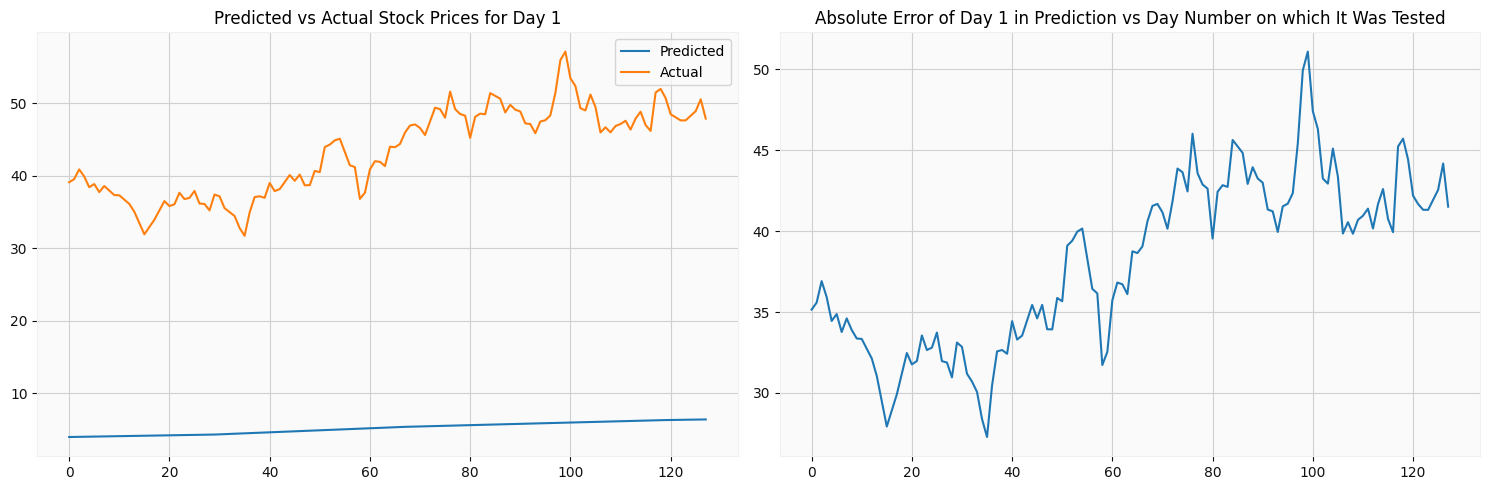

Average Absolute Error of Day 1:  38.119316674618844


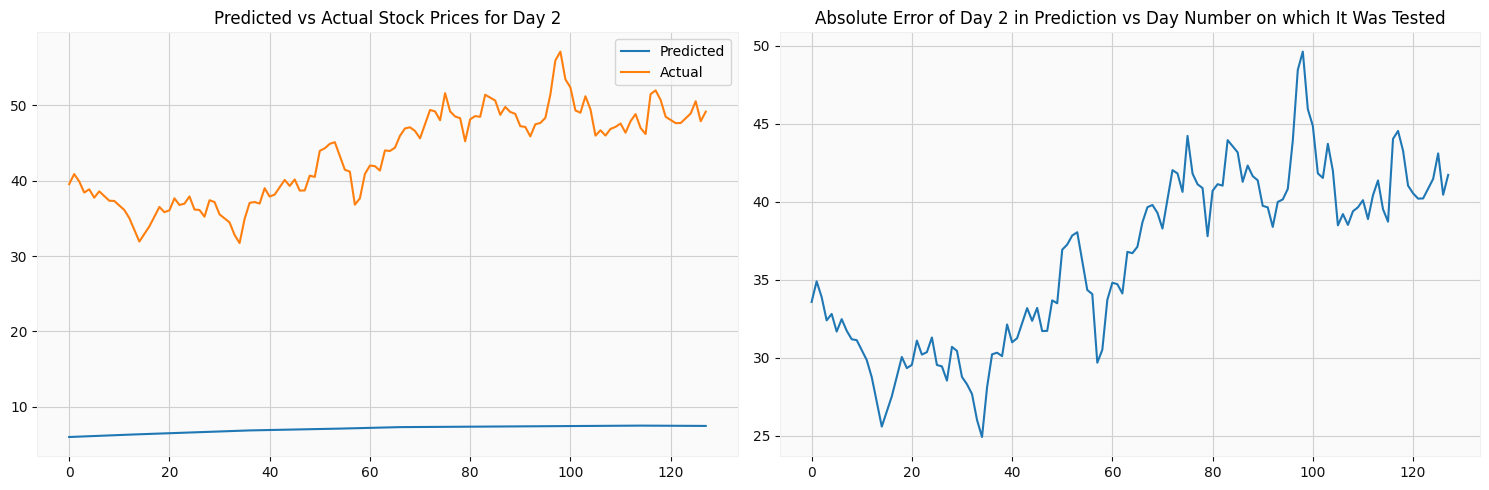

Average Absolute Error of Day 2:  36.295722628260705


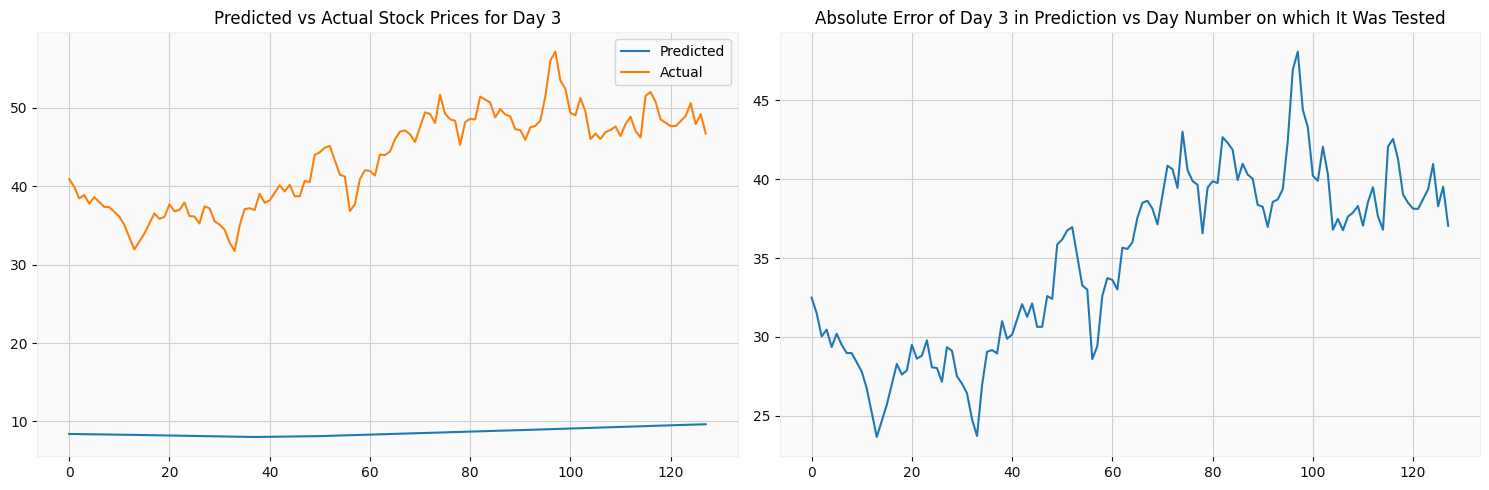

Average Absolute Error of Day 3:  34.829142637699974


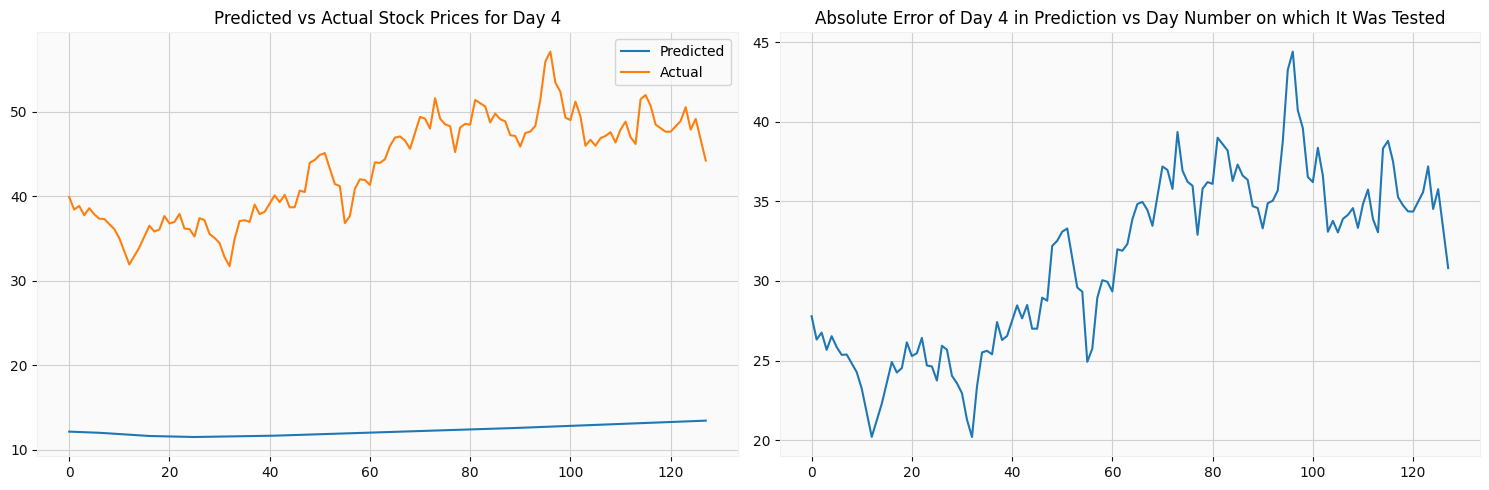

Average Absolute Error of Day 4:  31.220947261445748


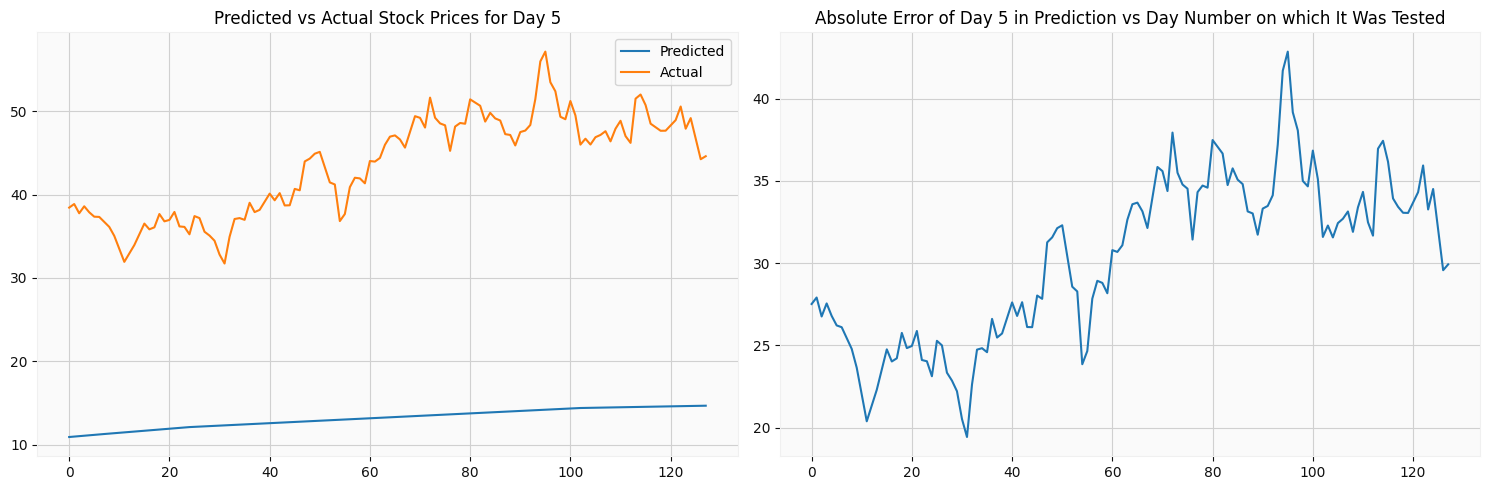

Average Absolute Error of Day 5:  30.276221044873452


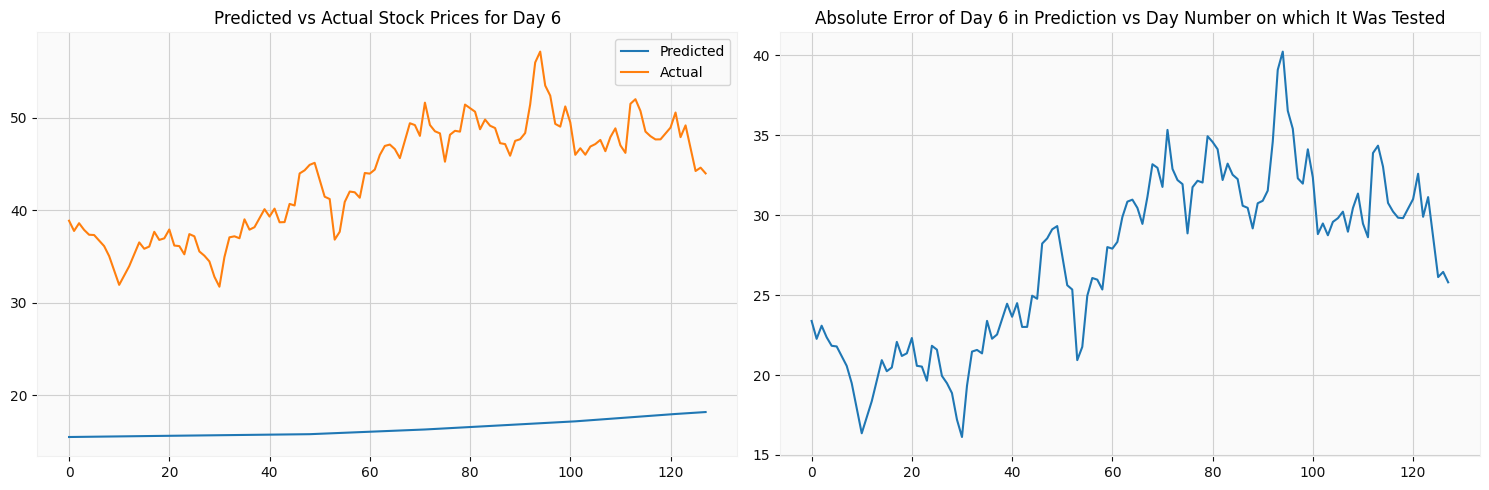

Average Absolute Error of Day 6:  27.16945738237478


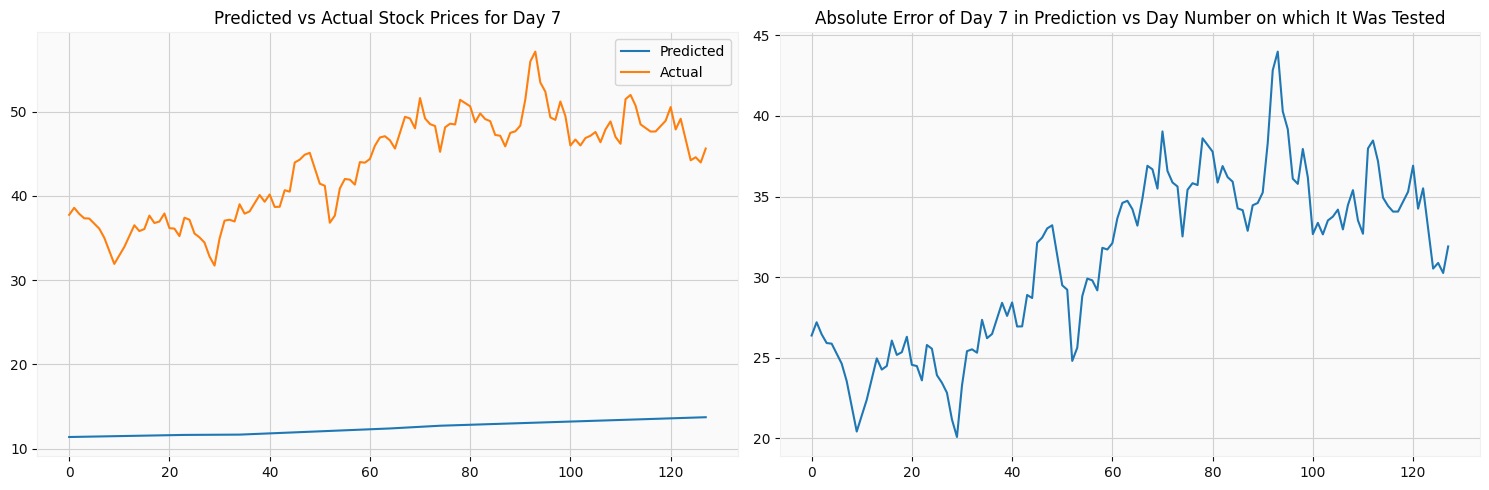

Average Absolute Error of Day 7:  31.141161412519537


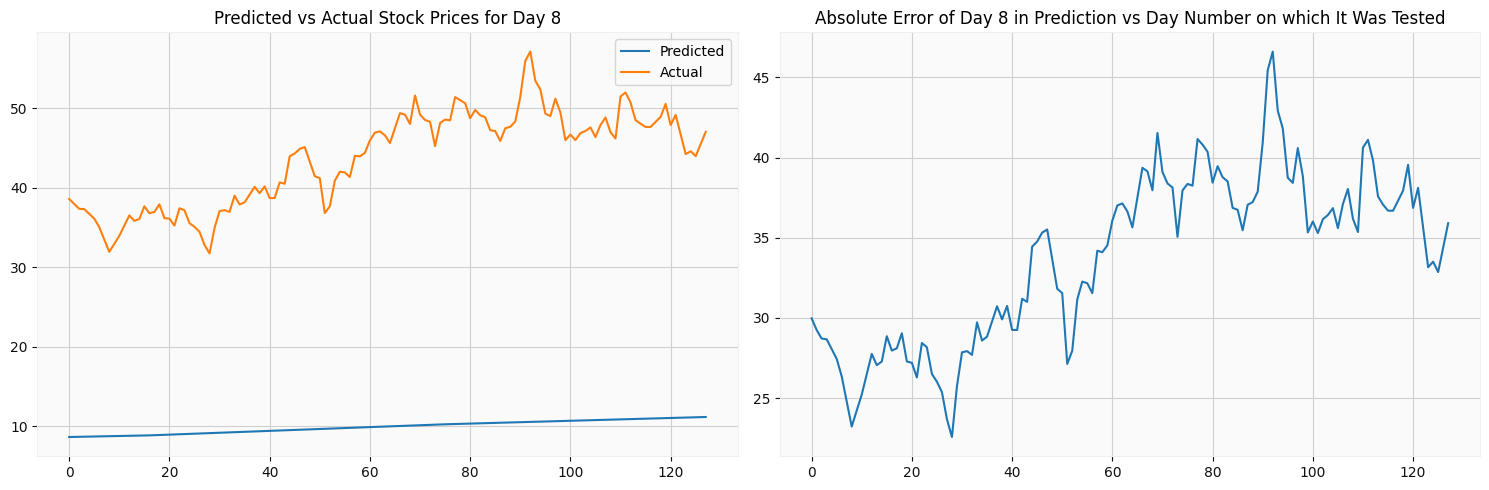

Average Absolute Error of Day 8:  33.752686759361296


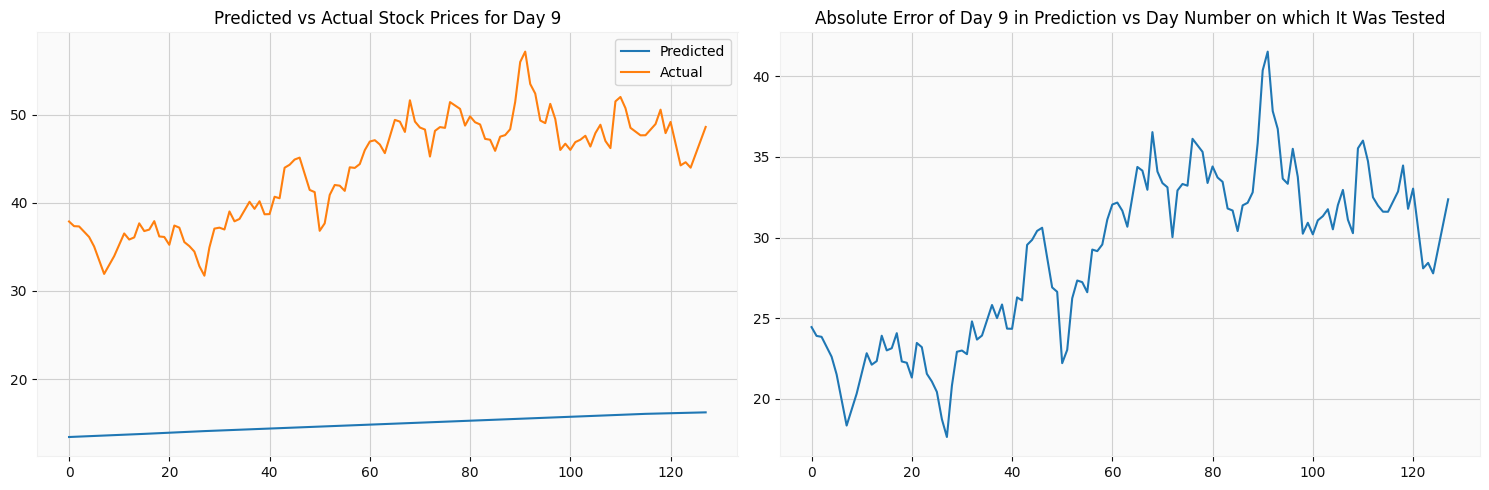

Average Absolute Error of Day 9:  28.8130948764189


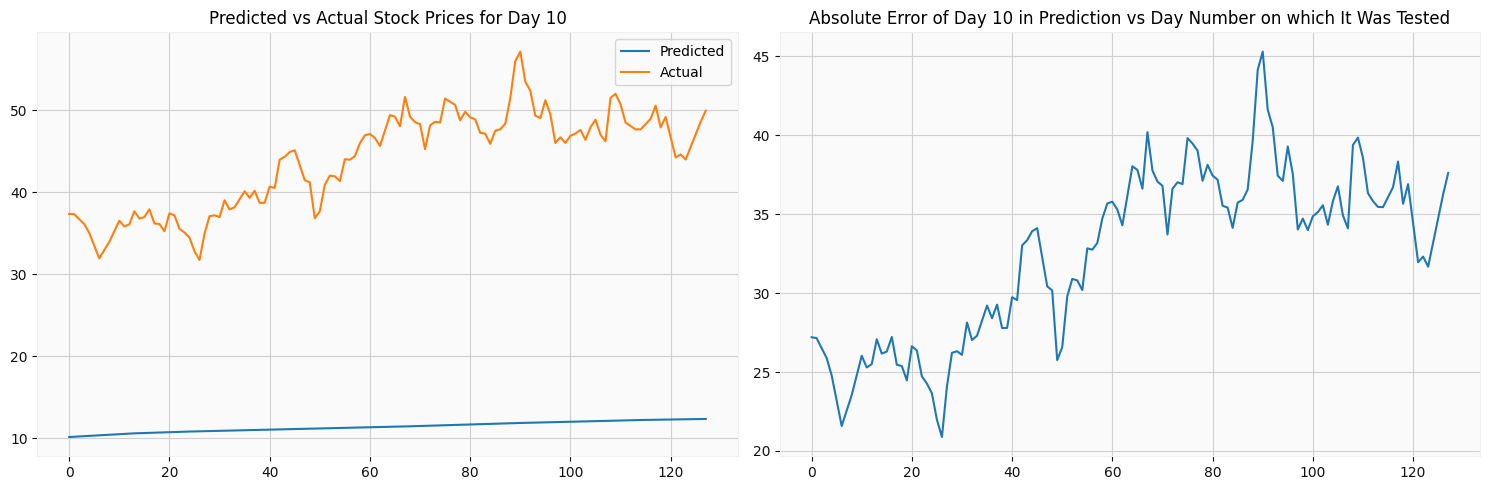

Average Absolute Error of Day 10:  32.45963360486836


Text(0, 0.5, 'Absolute difference')

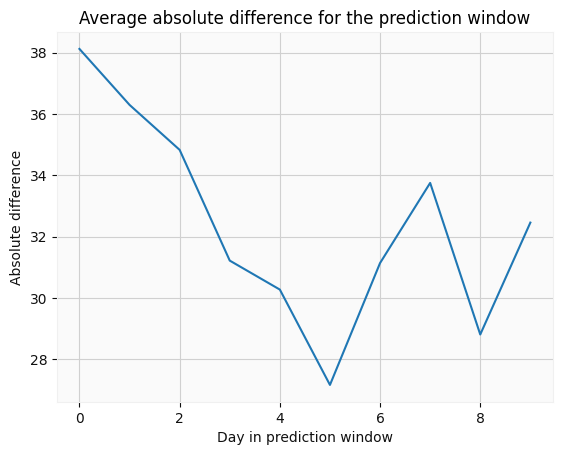

In [263]:
import numpy as np
import matplotlib.pyplot as plt
average_abs_diff = np.array([])
for i in range(output_dim): 
    # Convert `outputs` to a NumPy array
    normalized_close = np.array(np.array(test_outputs)[:, i], dtype=np.float64)
    targets_close = np.array(np.array(targets)[:, i], dtype=np.float64)
    # Denormalize the "Close" column
    min_close = np.float64(scaler.data_min_[-1])  # Minimum value of the original "Close" column
    max_close = np.float64(scaler.data_max_[-1])  # Maximum value of the original "Close" column
    denormalized_close = (normalized_close * (max_close - min_close)) + min_close
    denormalized_targets = (targets_close * (max_close - min_close)) + min_close
    
    # Create subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot predicted and actual values
    ax1.plot(denormalized_close.reshape(-1), label='Predicted')
    ax1.plot(denormalized_targets.reshape(-1), label='Actual')
    ax1.set_title(f"Predicted vs Actual Stock Prices for Day {i+1}")
    ax1.legend()

    # Plot absolute error
    abs_diff = np.abs(denormalized_close - denormalized_targets)
    ax2.plot(abs_diff)
    ax2.set_title(f"Absolute Error of Day {i+1} in Prediction vs Day Number on which It Was Tested")

    plt.tight_layout()
    plt.show()

    average_abs_diff = np.append(average_abs_diff,np.abs(denormalized_close - denormalized_targets).mean())
    print(f"Average Absolute Error of Day {i+1}: ", average_abs_diff[-1])

plt.plot(average_abs_diff)
plt.title("Average absolute difference for the prediction window")
plt.xlabel("Day in prediction window")
plt.ylabel("Absolute difference")

### Q9 c) Results

As we can see, the errors have increased yet again. This comes from the combination of the noise added from different stocks and the features dayOfWeek and dayOfYear.